# Data analysis
En este notebook se procedera con la exploracion de los datos, obtenidos al clasificar los articulos obtenidos (n=99) en las tablas que se encuentran en la carpeta /data. Primero se procede con el seteo del work directory, el importado de las librerias y funciones a usar, y la creacion de los dataframes para el analisis exploratorio de los datos.

## Primary stepts

Import libraries and functions

In [1]:
#Import libraries to be used
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt
from scipy import stats
from IPython.display import Image
from thefuzz import fuzz
import os

In [2]:
# Get the parent directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Change to the parent directory
os.chdir(parent_directory)

# Get the new current working directory to confirm
new_directory = os.getcwd()
print(f"New Directory: {new_directory}")

New Directory: c:\Users\dameliotomas\review-emotion-recognition-eda


In [3]:
#Import functions to be used
from scripts import functions as fn

Dataframes´s creation

In [4]:
#dataframes to be used, one for every sheet
df_metadata = pd.read_csv('.\data\cleaned\\Normalized Table - Metadata.csv')
df_data_type = pd.read_csv('.\data\cleaned\\Normalized Table - Data type.csv')
df_participants = pd.read_csv('.\data\cleaned\\Normalized Table - Participants.csv')
df_self_report = pd.read_csv('.\data\cleaned\\Normalized Table - Self-report.csv')
df_eet = pd.read_csv('.\data\cleaned\\Normalized Table - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('.\data\cleaned\\Normalized Table - EDA.csv')
df_alg_perf = pd.read_csv('.\data\cleaned\\Normalized Table - Statistical learning model - Performances.csv')

Set default plots caracteristiccs

In [5]:
sns.set_context('notebook')

## Analysis
Teniendo en cuenta las supracategorias () con las que fueron clasificados los articulos, se procede con el analisis de las mismas en orden.

### 1. Metadata

In [294]:
df_metadata=df_metadata.fillna('-')
df_metadata_without_duplicates = df_metadata.drop_duplicates(subset='paper_id')

#### 1.1. Countries

In [299]:
df_countries

0
first_author_country_affiliation    
Australia                          1
Austria                            2
Canada                             1
China                             16
Colombia                           1
Egypt                              1
Finland                            2
France                             1
Germany                            7
Greece                             3
India                              7
Indonesia                          1
Iran                               4
Italy                              5
Japan                              2
Korea                              2
Lithuania                          1
Macedonian                         2
Malaysia                           5
Pakistan                           3
Poland                             1
Portugal                           2
Romania                            3
Slovenia                           1
Spain                              4
Switzerland                        3
Taiwan                             3
Tunisia                            2
Turkey                             5
UK                                 1
USA                                7

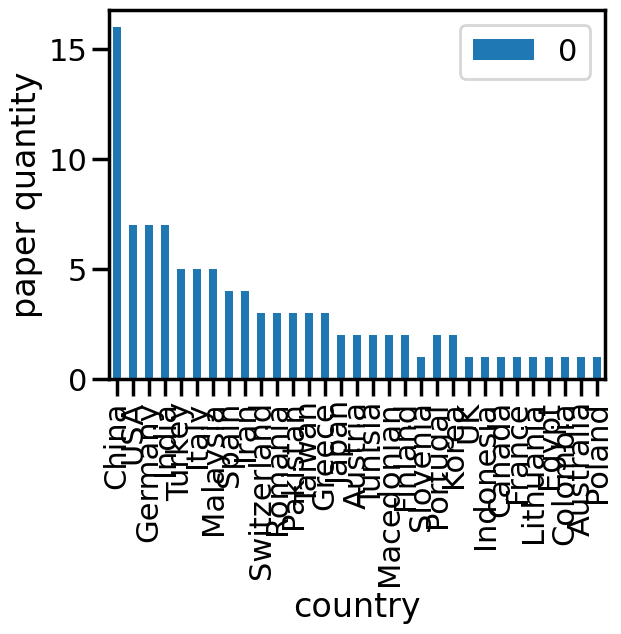

  continents  quantity
0       Asia        49
1     Europa        39
2    America         9
3     Africa         3
4  Australia         1


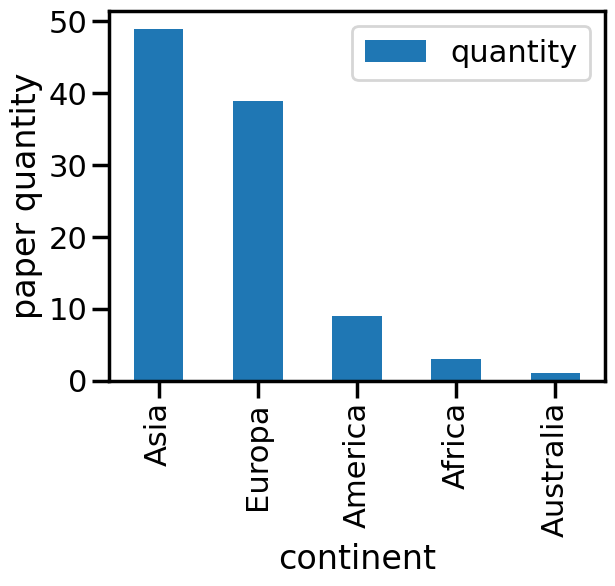

In [296]:
countries_1 = df_metadata_without_duplicates["first_author_country_affiliation"].unique()

countries = df_metadata_without_duplicates.pivot_table(columns=['first_author_country_affiliation'], aggfunc='size')
df_countries = pd.DataFrame(countries)

order = ['China','USA', 'Germany', 'India','Turkey','Italy', 'Malaysia','Spain','Iran', 'Switzerland','Romania','Pakistan', 'Taiwan','Greece', 'Japan',
'Austria', 'Tunisia','Macedonian', 'Finland', 'Slovenia', 'Portugal', 'Korea',
'UK', 'Indonesia','Canada', 'France', 'Lithuania','Egypt','Colombia', 'Australia', 'Poland']

df_countries.loc[order].plot(kind='bar', xlabel='country', ylabel='paper quantity')
plt.show()

#Papers por continente - plot
papers_continents = {'continents' : ['Asia', 'Europa','America','Africa','Australia'],
'quantity' : [49, 39, 9, 3, 1]}
df_continents = pd.DataFrame(papers_continents)
print(df_continents)

df_continents.set_index('continents').plot(kind='bar',xlabel='continent', ylabel='paper quantity')
plt.show()

In [303]:
df_countries

0
first_author_country_affiliation    
Australia                          1
Austria                            2
Canada                             1
China                             16
Colombia                           1
Egypt                              1
Finland                            2
France                             1
Germany                            7
Greece                             3
India                              7
Indonesia                          1
Iran                               4
Italy                              5
Japan                              2
Korea                              2
Lithuania                          1
Macedonian                         2
Malaysia                           5
Pakistan                           3
Poland                             1
Portugal                           2
Romania                            3
Slovenia                           1
Spain                              4
Switzerland                        3
Taiwan                             3
Tunisia                            2
Turkey                             5
UK                                 1
USA                                7

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\2583591573.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


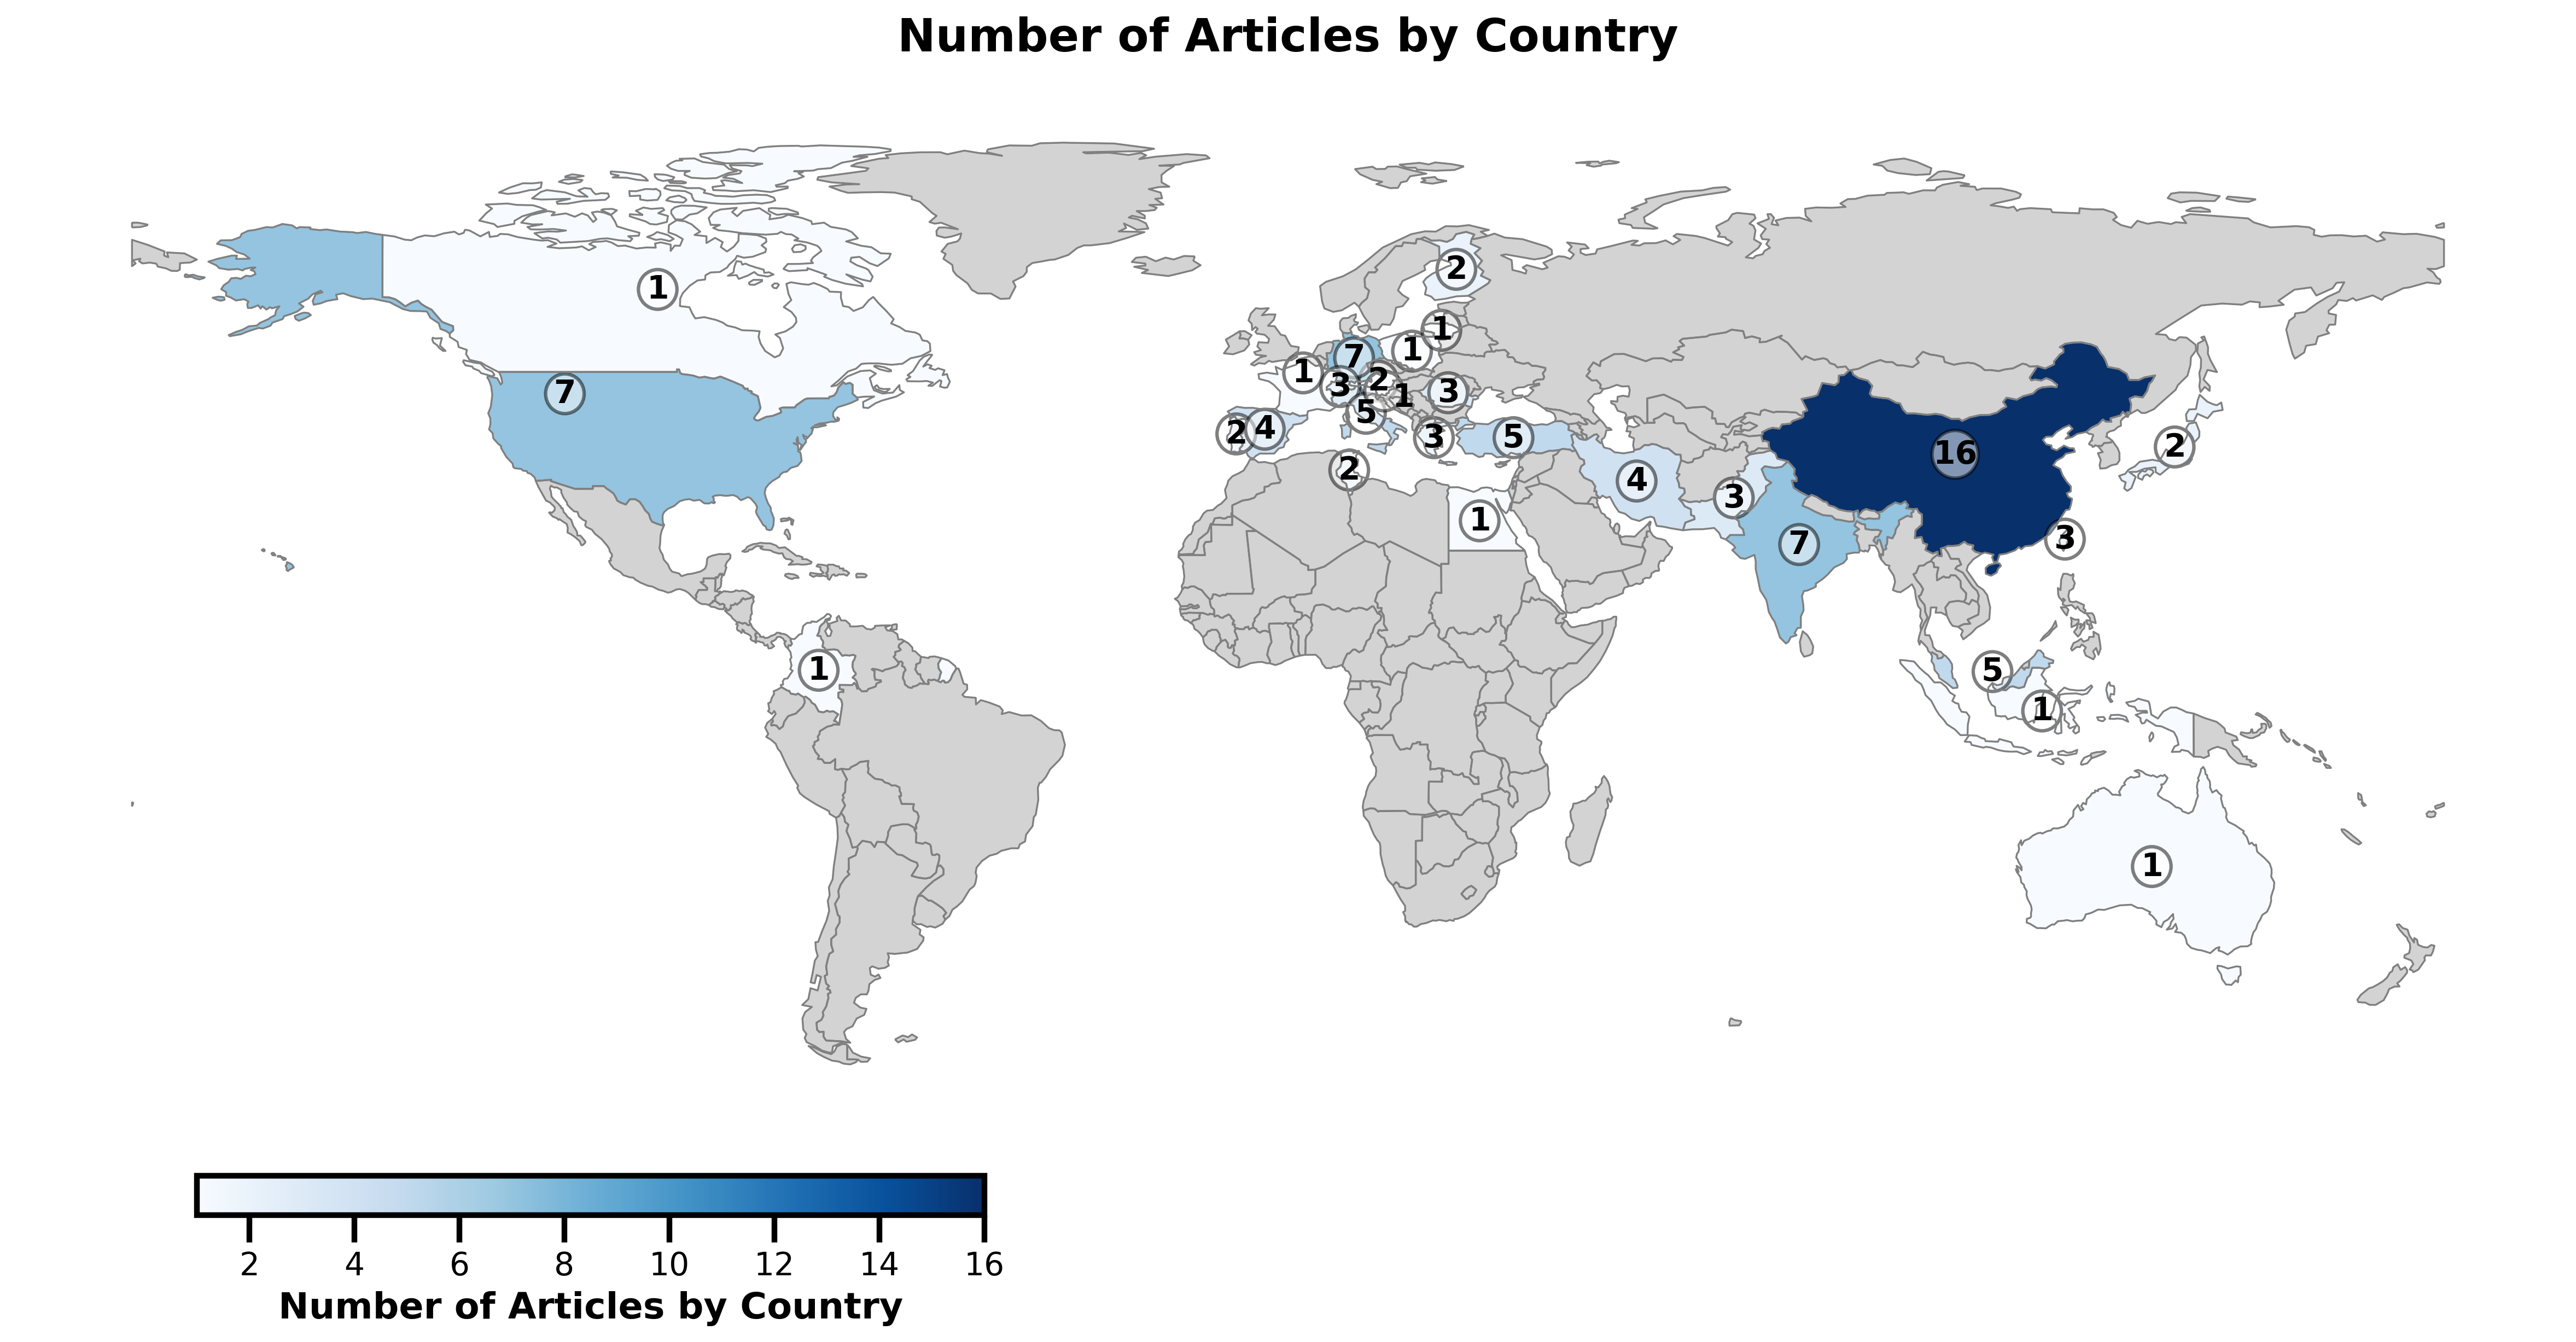

In [324]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

df_countries.columns = ['count']


# Cargamos el GeoDataFrame con geometría de países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Renombrar "USA" a "United States of America" en df_countries
df_countries.rename(index={'USA':'United States of America'}, inplace=True)

# Coordenadas de París
paris_coords = [2.3522, 48.8566]

# Coordenadas para ajustar Hungría
slovenia_adjust = [19.5033, 47.1625]

# Filtrar el GeoDataFrame para excluir la Antártida
world = world[world['name'] != 'Antarctica']

# Fusionamos el GeoDataFrame con tu DataFrame
world_merged = world.merge(df_countries, how="left", left_on="name", right_index=True)

# Crear el gráfico
fig, ax = plt.subplots(1, figsize=(20, 12), dpi=300)
world_merged.boundary.plot(ax=ax, linewidth=0.8, color='grey')
world_merged.plot(column='count', ax=ax, cmap='Blues',
                  missing_kwds={"color": "lightgrey"}, linewidth=0.5, edgecolor='black')

for idx, row in world_merged.iterrows():
    if not pd.isna(row['count']):
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        label = str(int(row['count']))
        
        # Ajustes específicos para Francia
        if row['name'] == 'France':
            x, y = paris_coords
        
        # Tamaño del círculo (20% más grande para China)
        circle_radius = 3 if row['name'] != 'China' else 3.6
        
        circle = plt.Circle((x, y), circle_radius, color='white', ec='black', fill=True, alpha=0.5, linewidth=1.5)
        ax.add_patch(circle)
        
        # Ajuste de la posición de la etiqueta para Slovenia
        if row['name'] == 'Slovenia':
            ax.annotate(label, xy=(x, y), xytext=(x + 3, y - 1),
                        fontsize=14, ha='center', va='center', fontweight='bold')
        else:
            ax.text(x, y, label, fontsize=14, ha='center', va='center', fontweight='bold')


# Título y barra de color
plt.title('Number of Articles by Country', fontsize=20, pad=20, fontweight='bold')
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=df_countries['count'].min(), vmax=df_countries['count'].max()))
sm.set_array([])

cbar = fig.colorbar(sm, orientation="horizontal", pad=0.01, shrink=0.5, ax=ax, fraction=0.046)
cbar.set_label('Number of Articles by Country', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_position([0.1, 0.1, 0.4, 0.02])

plt.show()


In [280]:
pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/27/27/2687abaa2ac02b5814e2929a5033da1e5d132c19a904dc56f77f63fd6eb9/geopandas-0.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/7f/27/b24c1610c7ae5716709321f04d38d7b8b71ed531f80df4f697b9ad99cfc3/fiona-1.9.5-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ------------------------ --------------- 30.7/51.1 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 51.1/51.1 kB 1.3 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.8.0 from https://files.pythonhosted.org/packages/9e/39/029c441d8af32ab423b229c4525ce5ce67

In [8]:
df_metadata_without_duplicates["first_author_country_affiliation"]

0        Spain
1        China
2       Turkey
4      Austria
9        China
        ...   
480     Taiwan
490     Poland
491      India
493      India
497    Germany
Name: first_author_country_affiliation, Length: 99, dtype: object

In [9]:
#Aquellos que tenian una frecuencia de 4 o menos los agrupamos en 'Others'
mapping_others ={
        
        'Australia': 'WEIRD',
        'Austria': 'WEIRD',
        'Canada': 'WEIRD',
        'Finland': 'WEIRD',
        'France': 'WEIRD',
        'Germany': 'WEIRD',
        'Italy': 'WEIRD',
        'Lithuania': 'WEIRD',
        'Poland': 'WEIRD',
        'Portugal': 'WEIRD',
        'Slovenia': 'WEIRD',
        'Spain': 'WEIRD',
        'Switzerland': 'WEIRD',
        'UK': 'WEIRD',
        'USA': 'WEIRD'}

df_countries_with_weird = df_metadata_without_duplicates.copy()
df_countries_with_weird.loc[:,'first_author_country_affiliation'] = df_countries_with_weird.loc[:,"first_author_country_affiliation"].replace(mapping_others)
df_countries_with_weird["first_author_country_affiliation"].value_counts()

first_author_country_affiliation
WEIRD         39
China         16
India          7
Turkey         5
Malaysia       5
Iran           4
Pakistan       3
Taiwan         3
Romania        3
Greece         3
Japan          2
Macedonian     2
Korea          2
Tunisia        2
Egypt          1
Indonesia      1
Colombia       1
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'WEIRD'),
  Text(1, 0, 'China'),
  Text(2, 0, 'Turkey'),
  Text(3, 0, 'India'),
  Text(4, 0, 'Malaysia'),
  Text(5, 0, 'Indonesia'),
  Text(6, 0, 'Tunisia'),
  Text(7, 0, 'Iran'),
  Text(8, 0, 'Macedonian'),
  Text(9, 0, 'Romania'),
  Text(10, 0, 'Greece'),
  Text(11, 0, 'Korea'),
  Text(12, 0, 'Pakistan'),
  Text(13, 0, 'Egypt'),
  Text(14, 0, 'Taiwan'),
  Text(15, 0, 'Japan'),
  Text(16, 0, 'Colombia')])

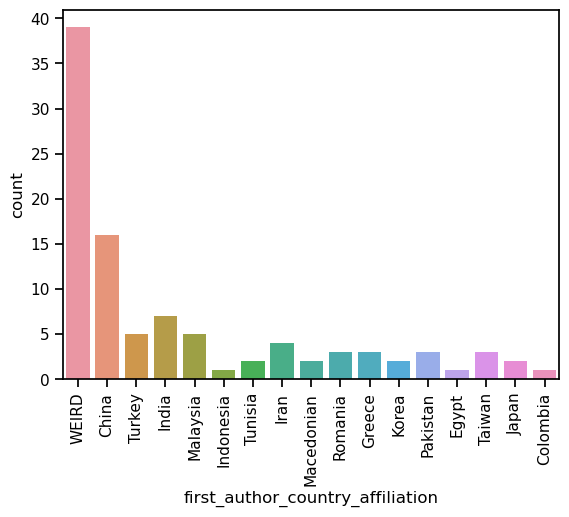

In [10]:
sns.countplot(x="first_author_country_affiliation", data=df_countries_with_weird)
plt.xticks(rotation=90)

#### 1.2. Source type

<Axes: xlabel='Source type', ylabel='count'>

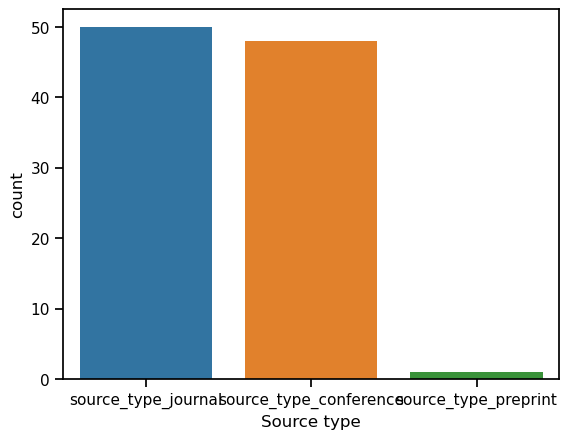

In [11]:
df_sources = df_metadata_without_duplicates.iloc[:,7:10]
def get_value(row):
     for c in df_sources.columns:
         if row[c]== 'x':
             return c

df_sources = df_sources.apply(get_value, axis=1)
df_sources = pd.DataFrame(df_sources)
df_sources.columns = ['Source type']

#ploteo
quantity = df_sources['Source type'].value_counts()
df_quantity = pd.DataFrame(quantity)


sns.countplot(x='Source type', data=df_sources)

In [12]:
df_quantity

count
Source type                  
source_type_journal        50
source_type_conference     48
source_type_preprint        1

#### ¿De que revistas cientificas provinieron la mayoria de los papers? ¿Cual era su orientacion (psicologica o ingenieria de datos)?
7. Gráfico frecuencia de papers según revista científica de origen, distinguiendo entre las que poseen orientación en ingeniería de datos y las que no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

c:\Users\dameliotomas\review-emotion-recognition-eda\scripts\functions.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


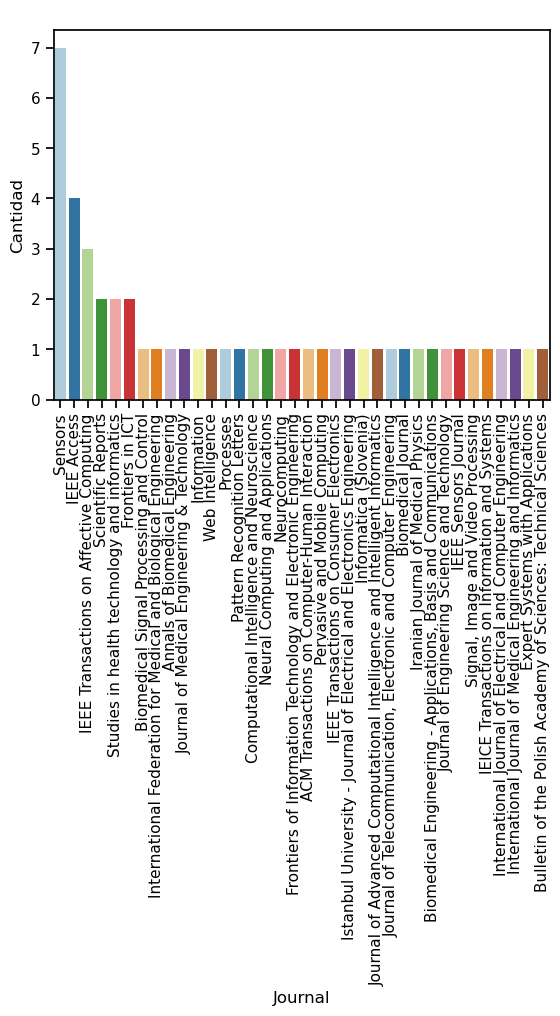

In [13]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_without_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_without_duplicates[['paper_id','source_title','source_type_journal']]
df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])] 

titulos = [' ', 'Journal', 'Cantidad']
fn.bar_plot('source_title',df_source_title,titulos)

In [14]:
df_source_title["source_title"].value_counts()

source_title
Sensors                                                                       7
IEEE Access                                                                   4
IEEE Transactions on Affective Computing                                      3
Scientific Reports                                                            2
Studies in health technology and informatics                                  2
Frontiers in ICT                                                              2
Biomedical Signal Processing and Control                                      1
International Federation for Medical and Biological Engineering               1
Annals of Biomedical Engineering                                              1
Journal of Medical Engineering & Technology                                   1
Information                                                                   1
Web Intelligence                                                              1
Processes                  

In [15]:
df_source_title["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

source_title
Sensors                                                                       14.0%
IEEE Access                                                                    8.0%
IEEE Transactions on Affective Computing                                       6.0%
Scientific Reports                                                             4.0%
Studies in health technology and informatics                                   4.0%
Frontiers in ICT                                                               4.0%
Biomedical Signal Processing and Control                                       2.0%
International Federation for Medical and Biological Engineering                2.0%
Annals of Biomedical Engineering                                               2.0%
Journal of Medical Engineering & Technology                                    2.0%
Information                                                                    2.0%
Web Intelligence                                               

In [16]:
serie_sources = df_source_title["source_title"].value_counts()
df_serie_sources = serie_sources.to_frame()
df_serie_sources = df_serie_sources.reset_index()
df_serie_sources.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

In [17]:
col1 = df_serie_sources.columns[0]
col2 = df_serie_sources.columns[1]

mapping_others = {}

for i, row in df_serie_sources.iterrows():
    if row[col2] == 1:
        mapping_others.update({row[col1]: "Others (=1)"})

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Sensors'),
  Text(1, 0, 'Others (=1)'),
  Text(2, 0, 'Scientific Reports'),
  Text(3, 0, 'Frontiers in ICT'),
  Text(4, 0, 'IEEE Transactions on Affective Computing'),
  Text(5, 0, 'IEEE Access'),
  Text(6, 0, 'Studies in health technology and informatics')])

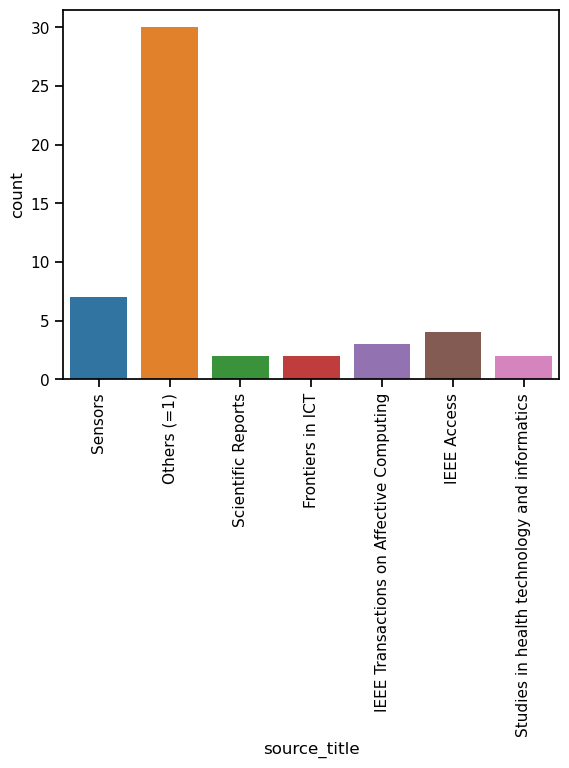

In [18]:
sources_with_others = df_source_title.copy()
sources_with_others.loc[:,'source_title'] = sources_with_others.loc[:,'source_title'].replace(mapping_others)
sources_with_others['source_title'].value_counts()

sns.countplot(x="source_title", data=sources_with_others)
plt.xticks(rotation=90)

In [19]:
sources_with_others["source_title"].value_counts()

source_title
Others (=1)                                     30
Sensors                                          7
IEEE Access                                      4
IEEE Transactions on Affective Computing         3
Scientific Reports                               2
Frontiers in ICT                                 2
Studies in health technology and informatics     2
Name: count, dtype: int64

In [20]:
sources_with_others["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

source_title
Others (=1)                                     60.0%
Sensors                                         14.0%
IEEE Access                                      8.0%
IEEE Transactions on Affective Computing         6.0%
Scientific Reports                               4.0%
Frontiers in ICT                                 4.0%
Studies in health technology and informatics     4.0%
Name: proportion, dtype: object

### 2. Data type

In [21]:
df_data_type = df_data_type.fillna('-')

#### ¿Cual es la evolucion temporal (2010-2020) del uso de las bases de datos privadas y publicas?
5. Gráfico de barra por año (2010-2020) según tipos de base de datos (privada, pública)

In [22]:
df_data_type = df_data_type.groupby(['paper_id', 'db_access']).nth(0)
df_data_type.reset_index(inplace=True)

In [23]:
df_data_type

index  paper_id  model_id  \
0       0         1         1   
1       1         2         2   
2       2         3         3   
3       4         4         5   
4       9         5        10   
..    ...       ...       ...   
95    480        95       482   
96    490        96       492   
97    491        97       493   
98    493        98       495   
99    497        99       499   

                                         apa_citation  year   db_access  \
0   Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  2017  restricted   
1   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  2016  restricted   
2   Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018        open   
3   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  2018        open   
4   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016  restricted   
..                                                ...   ...         ...   
95  Yang, H. C., & Lee, C. C. (2019, September). A...  2020        open   
96  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020  restricted   
97  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  2020        open   
98  Subramanian, R., Wache, J., Abadi, M. K., Vier...  2018        open   
99  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  2019  restricted   

   public_database use_multiple_db db_private db_public  ... driving_workload  \
0                -               -          x         -  ...                -   
1                -               -          x         -  ...                -   
2                -               -          -         -  ...                -   
3                -               -          -         -  ...                -   
4                -               -          x         -  ...                -   
..             ...             ...        ...       ...  ...              ...   
95               -               -          -         -  ...                -   
96               -               -          x         -  ...                -   
97               -               -          -         -  ...                -   
98               -               -          -         -  ...                -   
99               -               -          x         -  ...                -   

   liris sense_emotion pmemo hazumi1911 bio_vid_emo_db dreamer  \
0      -             -     -          -              -       -   
1      -             -     -          -              -       -   
2      -             -     -          -              -       -   
3      -             -     -          -              -       -   
4      -             -     -          -              -       -   
..   ...           ...   ...        ...            ...     ...   
95     -             -     -          -              -       -   
96     -             -     -          -              -       -   
97     -             -     -          -              -       -   
98     -             -     -          -              -       -   
99     -             -     -          -              -       -   

   non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status  \
0                                                   -                                    
1                                                   -                                    
2                                                   -                                    
3                                                   -                                    
4                                                   -                                    
..                                                ...                                    
95                                                  -                                    
96                                                  -                                    
97                                                  -                                    
98                                      

In [24]:
df_data_type["db_access"] = df_data_type["db_access"].str.capitalize()
df_data_type = df_data_type.rename(columns={"db_access":"Access"})

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Quantity')]

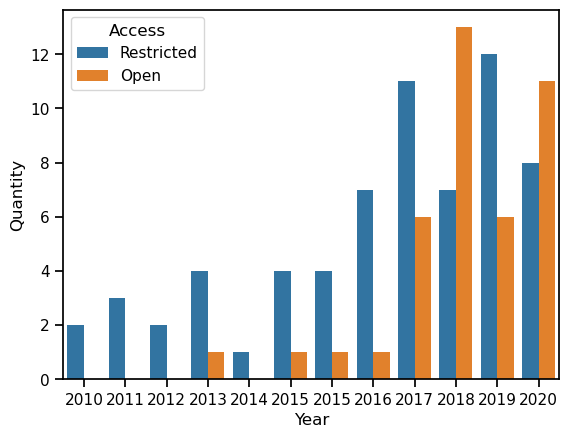

In [25]:
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g = sns.countplot(x='year', 
    data= df_data_type, 
    hue='Access', 
    order=category_order)
g.set(xlabel = 'Year', ylabel = 'Quantity')

In [26]:
df_data_type["Access"].value_counts()

Access
Restricted    61
Open          39
Name: count, dtype: int64

In [27]:
df_data_type["Access"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Access
Restricted    61.0%
Open          39.0%
Name: proportion, dtype: object

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Quantity')]

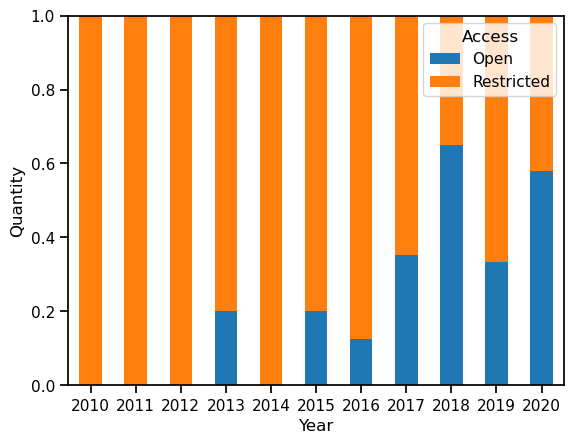

In [28]:
df_access = df_data_type[["paper_id","apa_citation",'Access', "year", "model_id"]]

df_access = df_access.groupby(
        ["paper_id",'Access']
        ).nth(0)
df_access.reset_index(inplace=True)

df_access_crosstab = pd.crosstab(index=df_access['year'], columns=df_access['Access'],normalize='index')

g = df_access_crosstab.plot(kind='bar',
                        stacked=True,
                        rot=0)
g.set_ylim([0, 1])
g.set(xlabel = 'Year', ylabel = 'Quantity')

#### ¿Cual es la frecuencia de uso de cada bse de datos encontrada?

6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

In [29]:
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

In [30]:
df_db = df_data_type.groupby(['paper_id',"public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']).nth(0)
df_db.reset_index(inplace=True)

In [31]:
df_db = fn.multi_reversing(df_db, 'model_id', df_db[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']])
df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')

In [32]:
df_db["variable"].value_counts()

variable
db_private          61
is_database         34
db_public            4
db_uppon_request     1
Name: count, dtype: int64

In [33]:
df_db["variable"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
db_private          61.0%
is_database         34.0%
db_public            4.0%
db_uppon_request     1.0%
Name: proportion, dtype: object

In [34]:
df_data_type[["Access", "model_id", "public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']]
df_data_type[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']].value_counts()


public_database  use_multiple_db  db_private  db_public  db_private_and_public  db_uppon_request  is_database
-                -                x           -          -                      -                 -              60
                                  -           -          -                      -                 x              34
                                              x          -                      -                 -               4
                                              -          -                      x                 -               1
                                  x           -          -                      -                 .               1
Name: count, dtype: int64

In [35]:
df_data_type["Access"].value_counts()

Access
Restricted    61
Open          39
Name: count, dtype: int64

In [36]:
freq_data_base = df_data_type.groupby(['paper_id', 'deap',
       'amigos', 'mahnob', 'case', 'ascertain', 'cog_load',
       'multimodal_dyadic_behavior', 'recola', 'decaf',
       'driving_workload', 'liris', 'sense_emotion', 'pmemo',
       'hazumi1911', 'bio_vid_emo_db', 'dreamer',
       'non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status',
       'stress_recognition_in_automobile_drivers_data_set', 'pspm_hra1']).nth(0)
freq_data_base.reset_index(inplace=True)

db_freq = fn.multi_reversing(freq_data_base, 'model_id', freq_data_base[['deap',
       'amigos', 'mahnob', 'case', 'ascertain', 'cog_load',
       'multimodal_dyadic_behavior', 'recola', 'decaf',
       'driving_workload', 'liris', 'sense_emotion', 'pmemo',
       'hazumi1911', 'bio_vid_emo_db', 'dreamer',
       'non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status',
       'stress_recognition_in_automobile_drivers_data_set', 'pspm_hra1']])
db_freq['variable'].value_counts()

variable
deap                          9
amigos                        7
mahnob                        7
pmemo                         3
ascertain                     2
recola                        2
multimodal_dyadic_behavior    1
liris                         1
hazumi1911                    1
bio_vid_emo_db                1
Name: count, dtype: int64

In [37]:
db_freq['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
deap                          26.5%
amigos                        20.6%
mahnob                        20.6%
pmemo                          8.8%
ascertain                      5.9%
recola                         5.9%
multimodal_dyadic_behavior     2.9%
liris                          2.9%
hazumi1911                     2.9%
bio_vid_emo_db                 2.9%
Name: proportion, dtype: object

In [38]:
db_freq['variable'] = db_freq['variable'].replace(
    to_replace=['multimodal_dyadic_behavior'], 
    value='MMDB')

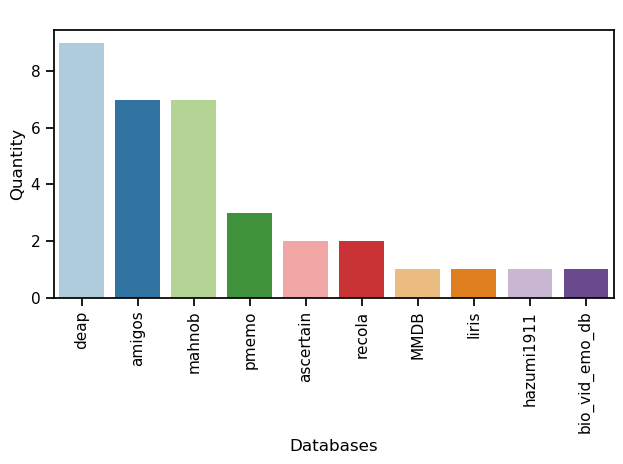

In [39]:
titulos = [' ', 'Databases', 'Quantity']
fn.bar_plot('variable',db_freq,titulos)

In [40]:
df_data_type

index  paper_id  model_id  \
0       0         1         1   
1       1         2         2   
2       2         3         3   
3       4         4         5   
4       9         5        10   
..    ...       ...       ...   
95    480        95       482   
96    490        96       492   
97    491        97       493   
98    493        98       495   
99    497        99       499   

                                         apa_citation  year      Access  \
0   Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  2017  Restricted   
1   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  2016  Restricted   
2   Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018        Open   
3   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  2018        Open   
4   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016  Restricted   
..                                                ...   ...         ...   
95  Yang, H. C., & Lee, C. C. (2019, September). A...  2020        Open   
96  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020  Restricted   
97  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  2020        Open   
98  Subramanian, R., Wache, J., Abadi, M. K., Vier...  2018        Open   
99  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  2019  Restricted   

   public_database use_multiple_db db_private db_public  ... driving_workload  \
0                -               -          x         -  ...                -   
1                -               -          x         -  ...                -   
2                -               -          -         -  ...                -   
3                -               -          -         -  ...                -   
4                -               -          x         -  ...                -   
..             ...             ...        ...       ...  ...              ...   
95               -               -          -         -  ...                -   
96               -               -          x         -  ...                -   
97               -               -          -         -  ...                -   
98               -               -          -         -  ...                -   
99               -               -          x         -  ...                -   

   liris sense_emotion pmemo hazumi1911 bio_vid_emo_db dreamer  \
0      -             -     -          -              -       -   
1      -             -     -          -              -       -   
2      -             -     -          -              -       -   
3      -             -     -          -              -       -   
4      -             -     -          -              -       -   
..   ...           ...   ...        ...            ...     ...   
95     -             -     -          -              -       -   
96     -             -     -          -              -       -   
97     -             -     -          -              -       -   
98     -             -     -          -              -       -   
99     -             -     -          -              -       -   

   non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status  \
0                                                   -                                    
1                                                   -                                    
2                                                   -                                    
3                                                   -                                    
4                                                   -                                    
..                                                ...                                    
95                                                  -                                    
96                                                  -                                    
97                                                  -                                    
98                                      

In [41]:
df_data_type[df_data_type['hazumi1911'] != "-"]['apa_citation']


89    Katada, S., Okada, S., Hirano, Y., & Komatani,...
Name: apa_citation, dtype: object

In [42]:
df_access = df_data_type[["paper_id","apa_citation",'Access', "year", "model_id"]]

df_access = df_access.groupby(
        ["paper_id",'Access']
        ).nth(0)
df_access.reset_index(inplace=True)

df_access_crosstab = pd.crosstab(index=df_access['year'], columns=df_access['Access'],normalize='index')

In [43]:
df_access_crosstab

Access      Open  Restricted
year                        
2010    0.000000    1.000000
2011    0.000000    1.000000
2012    0.000000    1.000000
2013    0.200000    0.800000
2014    0.000000    1.000000
2015    0.200000    0.800000
2016    0.125000    0.875000
2017    0.352941    0.647059
2018    0.650000    0.350000
2019    0.333333    0.666667
2020    0.578947    0.421053

In [328]:
# Adding a new row to the dataframe
new_row = pd.DataFrame({'model_id': [7], 'variable': ['wesad'], 'value': ['x']})
db_freq = pd.concat([db_freq, new_row], ignore_index=True)

## Figure 4

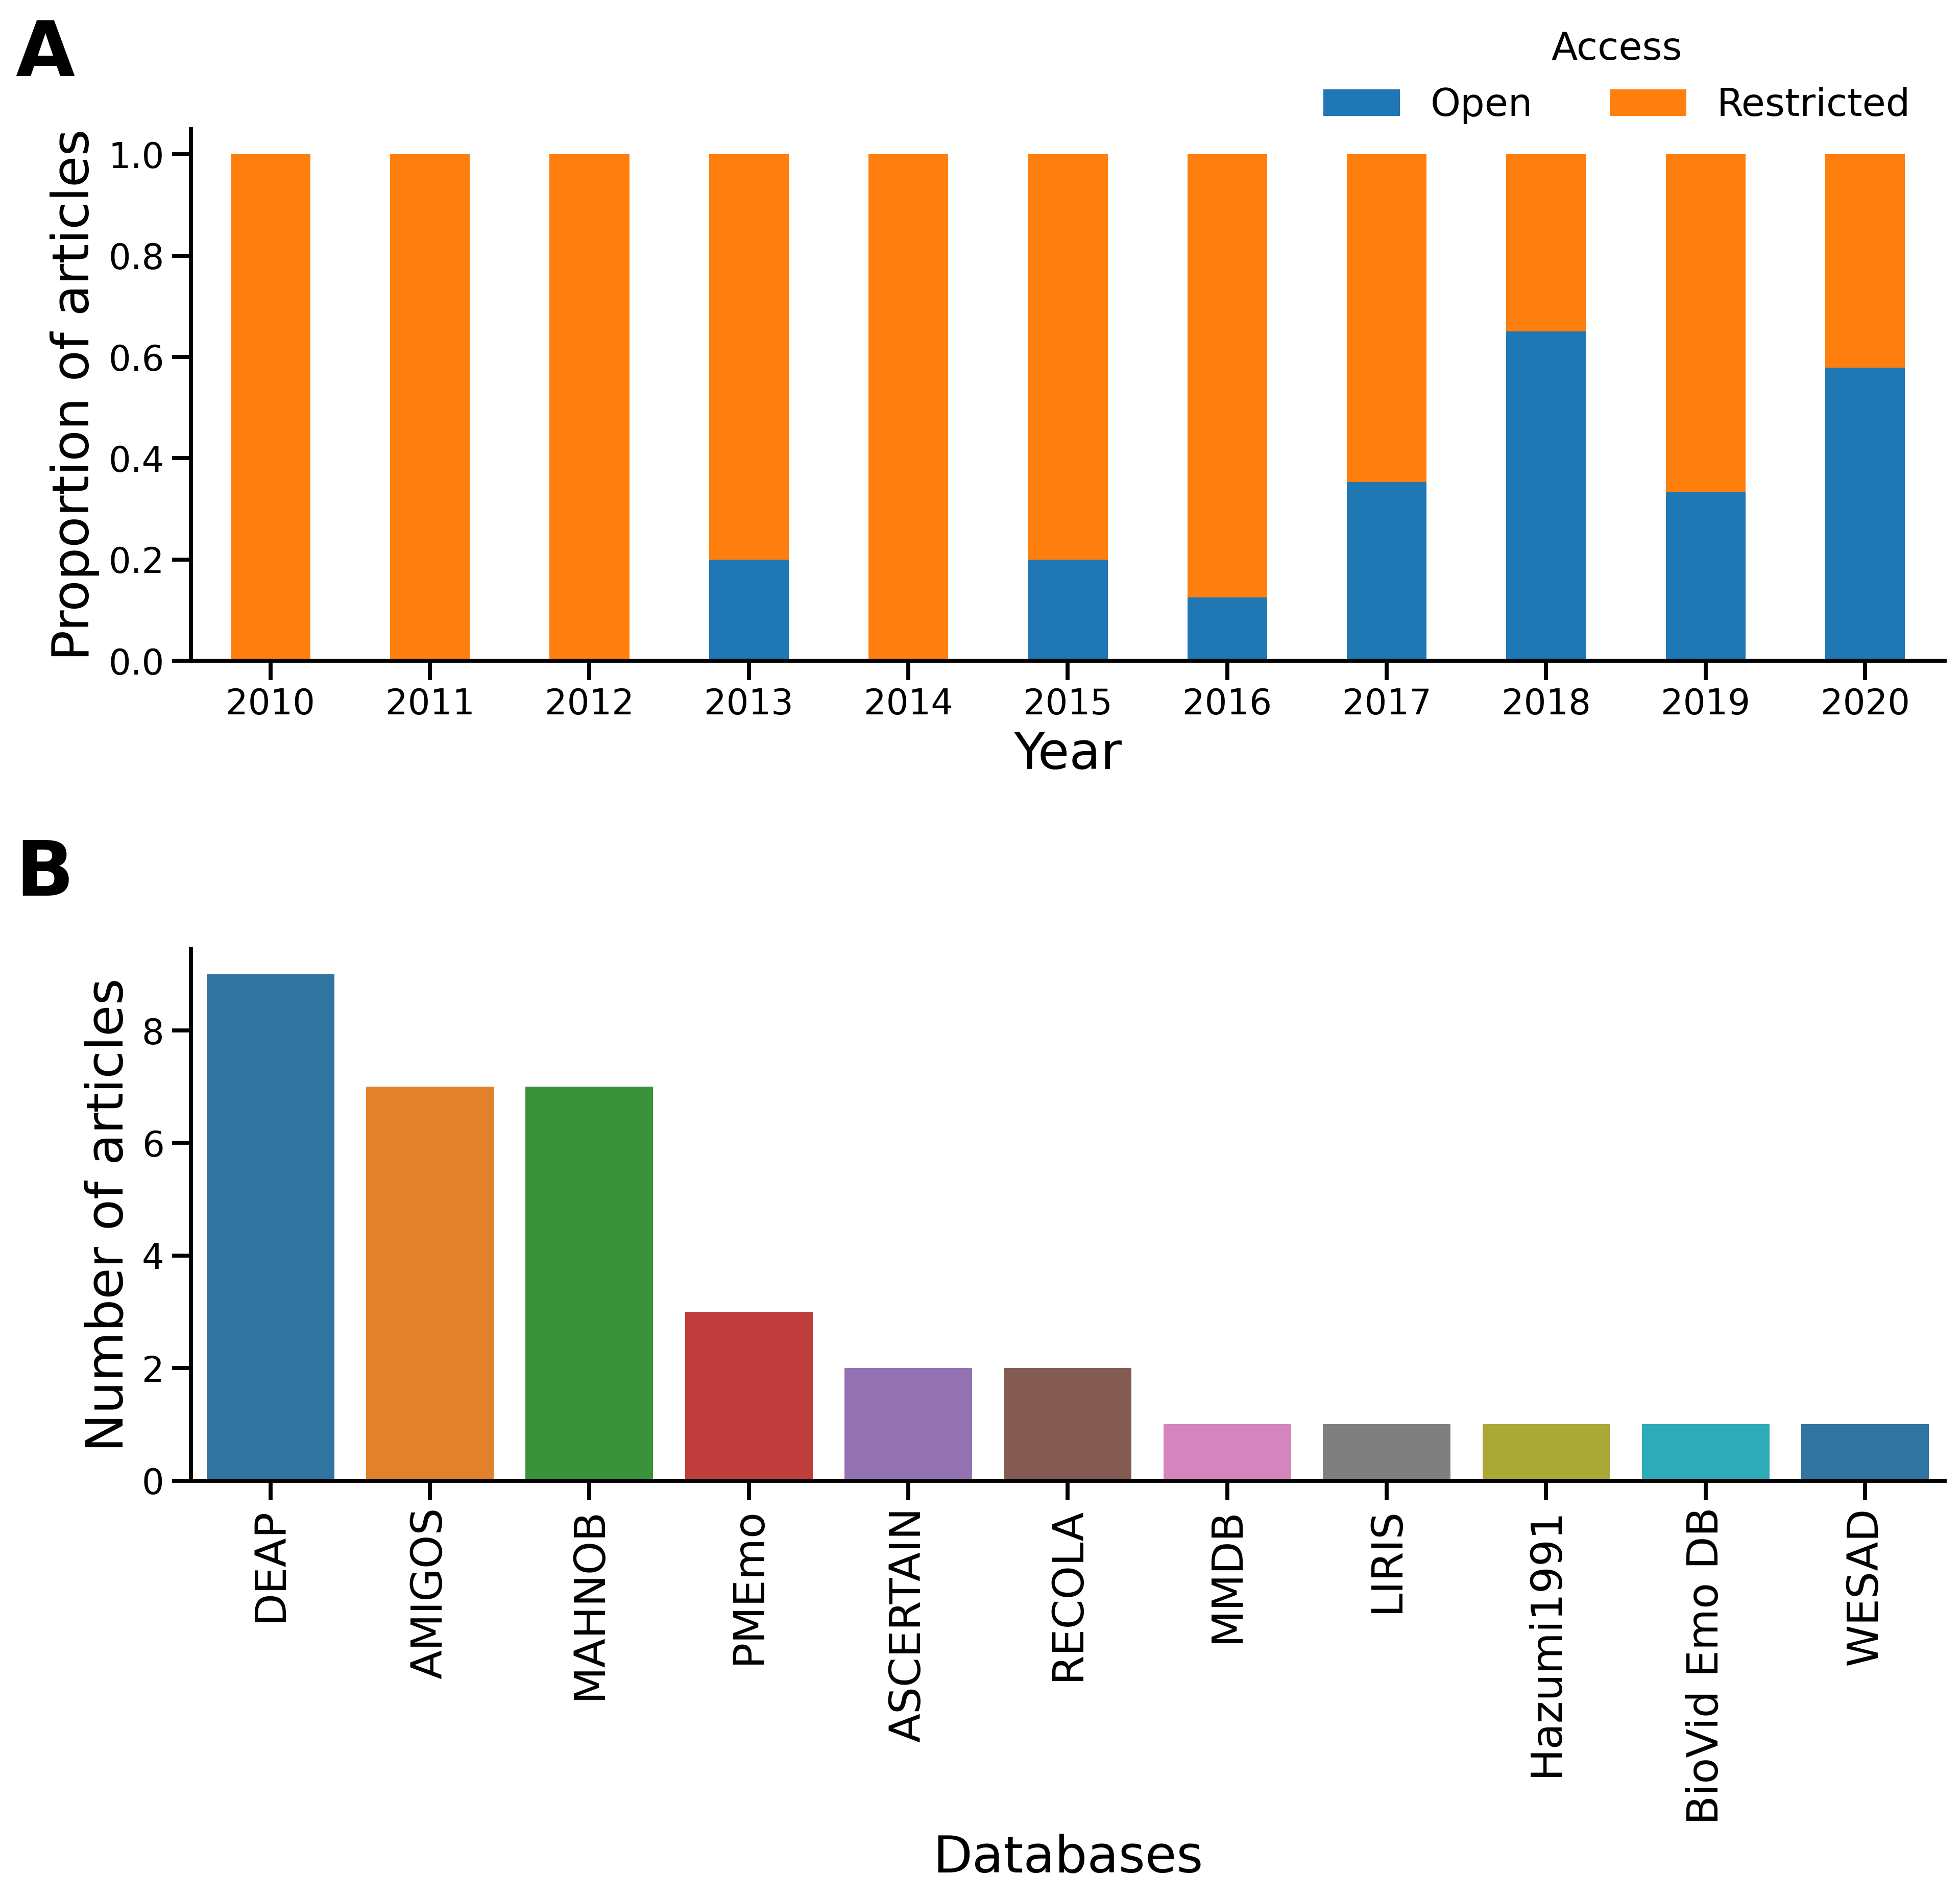

In [355]:
# Set the context for even bigger fonts
sns.set_context("talk")

# Create subplots
fig, axes = plt.subplots(2, 1)

fig.dpi = 300

# Adjust figure dimensions
fig.set_figheight(13)
fig.set_figwidth(13)

chosen_colors=sns.color_palette("tab10")[0:2]

# Plot the first subplot
ax1 = df_access_crosstab.plot(kind='bar',
                              stacked=True,
                              rot=0,
                              ax=axes[0],
                              color=chosen_colors)

# Plot the second subplot
ax2 = sns.countplot(x="variable",
                    data=db_freq,
                    order=getattr(db_freq, "variable").value_counts().index,
                    ax=axes[1],
                     palette="tab10")

# Set titles and labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
ax1.set_xlabel("Year", fontsize=24)
ax1.set_ylabel("Proportion of articles", fontsize=24)

# Put a legend below current axis
ax1.legend(title='Access', loc='upper right',bbox_to_anchor=(1, 1.25),
          frameon=False, fancybox=True, ncol=2, fontsize=18)

ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
ax2.set_xlabel("Databases", fontsize=24)
ax2.set_ylabel("Number of articles", fontsize=24)

# Set custom labels for the second subplot
custom_labels = ["DEAP", "AMIGOS", "MAHNOB",  "PMEmo", "ASCERTAIN", "RECOLA", "MMDB", "LIRIS", "Hazumi1991", "BioVid Emo DB", "WESAD"]
ax2.set_xticklabels(custom_labels, rotation=90, fontsize=20)


# Layout adjustment
fig.tight_layout()

sns.despine(ax=ax1)
sns.despine(ax=ax2)


plt.show()

### 3. Participants

In [45]:
df_participants= df_participants.fillna('-')
df_participants.head()

paper_id  model_id                                       apa_citation   n  \
0         1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  45   
1         2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   -   
2         3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  32   
3         3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  32   
4         4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27   

  n_female mean_age meadian_age range_age country  
0       20        -           -         -   Spain  
1        -        -           -         -   China  
2       16     26.9           -     19-37       -  
3       16     26.9           -     19-37       -  
4       16    26.06           -     19-40       -

#### country

In [46]:
df_participants_country = df_participants.groupby(['paper_id', 'country']).nth(0)
df_participants_country.reset_index(inplace =  True)
df_participants_country["country"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

country
-            77.8%
Malasya       5.1%
China         3.0%
Iran          3.0%
Spain         1.0%
USA           1.0%
Germany       1.0%
India         1.0%
Indonesia     1.0%
Canada        1.0%
French        1.0%
Finland       1.0%
Korea         1.0%
Italy         1.0%
Poland        1.0%
Name: proportion, dtype: object

In [47]:
participants_total = df_participants.groupby(['paper_id', 'n']).nth(0)
participants_total.reset_index(inplace =  True)

In [48]:
participants_total["n"].unique()

array(['45', '-', '32', '27', '121', '15', '6', '30', '19', '20', '39',
       '52', '25', '35', '46', '22', '8', '23', '11', '33', '40', '10',
       '255', '58', '21', '13', '42', '4', '31', '254', '26', '28', '18',
       '100', '162', '9', '55', '457', '24', '860'], dtype=object)

In [49]:
participants_total["n"].value_counts()

n
-      11
27     11
32     11
40      8
30      4
10      4
4       3
457     3
11      3
20      3
13      3
21      3
25      3
35      3
19      3
26      2
58      2
46      2
22      2
15      2
31      2
100     1
18      1
162     1
28      1
254     1
9       1
55      1
24      1
45      1
42      1
255     1
33      1
23      1
8       1
52      1
39      1
6       1
121     1
860     1
Name: count, dtype: int64

In [50]:
participants_without_n= participants_total[participants_total['n']== '27']
participants_without_n

index  paper_id  model_id  \
3        4         4         5   
4        9         5        10   
9       43        10        44   
15      92        16        93   
19     129        20       130   
34     194        35       195   
40     227        37       228   
64     302        59       304   
66     313        60       315   
75     358        69       360   
106    497        99       499   

                                          apa_citation   n n_female mean_age  \
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  27       27    19.44   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...  27       16    26.06   
15   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...  27       16    26.06   
19   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...  27       16    26.06   
34   Ferdinando, H., & Alasaarela, E. (2018). Emoti...  27       16    26.06   
40   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...  27       16    26.06   
64   Yu, D., & Sun, S. (2020). A systematic explora...  27       16    26.06   
66   Al Machot, F., Elmachot, A., Ali, M., Al Macho...  27       16    26.06   
75   Wei, W., Jia, Q., Feng, Y., & Chen, G. (2018)....  27       16    26.06   
106  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  27        -        -   

    meadian_age range_age country  
3             -     19-40       -  
4             -     18-22       -  
9             -     19-40       -  
15            -     19-40       -  
19            -     19-40       -  
34            -     19-40       -  
40            -     19-40       -  
64            -     19-40       -  
66            -     19-40       -  
75            -     19-40       -  
106           -         -       -

In [51]:
participants_n= participants_total[participants_total['n']!= '-']
participants_n

index  paper_id  model_id  \
0        0         1         1   
2        2         3         3   
3        4         4         5   
4        9         5        10   
5       11         6        12   
..     ...       ...       ...   
102    480        95       482   
103    490        96       492   
104    491        97       493   
105    493        98       495   
106    497        99       499   

                                          apa_citation    n n_female mean_age  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20        -   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
..                                                 ...  ...      ...      ...   
102  Yang, H. C., & Lee, C. C. (2019, September). A...   40       13     28.3   
103  Kołodziej, M., Tarnowski, P., Majkowski, A., &...   22        -       20   
104  Ganapathy, N., & Swaminathan, R. (2019). Emoti...   32       16     26.9   
105  Subramanian, R., Wache, J., Abadi, M. K., Vier...   58       21       30   
106  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   27        -        -   

    meadian_age range_age country  
0             -         -   Spain  
2             -     19-37       -  
3             -     19-40       -  
4             -     18-22       -  
5             -       1-3     USA  
..          ...       ...     ...  
102           -         -       -  
103           -         -  Poland  
104           -     19-37       -  
105           -         -       -  
106           -         -       -  

[96 rows x 10 columns]

57.020833333333336


C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\91305593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_n["n"] = participants_n["n"].astype(int)


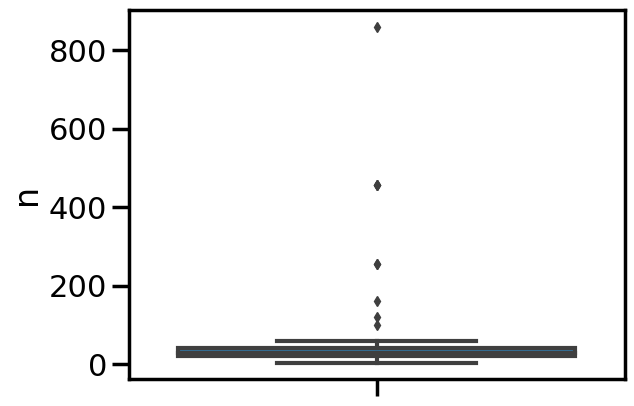

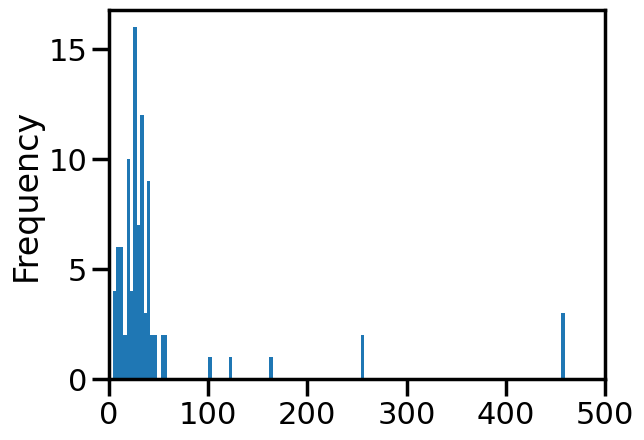

In [52]:
participants_n["n"] = participants_n["n"].astype(int)
print(participants_n['n'].mean())
g = sns.boxplot(y="n", data=participants_n)
plt.show()
g2 = participants_n['n'].plot(bins = 250,kind ='hist', xlim = [0,500])
plt.show()

In [53]:
participants_no_n= participants_total[participants_total['n']== '-']
participants_no_n

index  paper_id  model_id  \
1        1         2         2   
27     157        28       158   
39     220        37       221   
44     250        40       251   
51     268        47       270   
53     274        49       276   
58     283        54       285   
74     357        68       359   
78     367        72       369   
96     467        90       469   
100    477        93       479   

                                          apa_citation  n n_female mean_age  \
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  -        -        -   
27   Das, P., Khasnobish, A., & Tibarewala, D. N. (...  -        -        -   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...  -        -        -   
44   Milchevski, A., Rozza, A., & Taskovski, D. (20...  -        -        -   
51   Bornoiu, I.-V., Strungaru, R., & Grigore, O. (...  -        -        -   
53   Drungilas, D., Bielskis, A. A., & Denisov, V. ...  -        -        -   
58   Cheng, J., & Liu, G. (2013). Computing nonline...  -        -       20   
74   García-Faura, Á., Hernández-García, A., Fernán...  -        -    23.11   
78   Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...  -        -        -   
96   Katada, S., Okada, S., Hirano, Y., & Komatani,...  -        -        -   
100  Rahim, A., Sagheer, A., Nadeem, K., Dar, M. N....  -        -        -   

    meadian_age range_age country  
1             -         -   China  
27            -         -       -  
39            -         -       -  
44            -         -       -  
51            -     25-65       -  
53            -         -       -  
58            -         -       -  
74            -     17-60       -  
78            -         -       -  
96            -         -       -  
100           -         -       -

In [54]:
participants_female = df_participants.groupby(['paper_id', 'n_female']).nth(0)
participants_female.reset_index(inplace =  True)

In [55]:
participants_without_female= participants_female[participants_female['n_female'] == '-']
participants_without_female

index  paper_id  model_id  \
1        1         2         2   
5       11         6        12   
7       39         8        40   
11      46        12        47   
12      50        13        51   
14      66        15        67   
20     131        21       132   
21     143        22       144   
23     148        24       149   
25     153        26       154   
27     157        28       158   
39     220        37       221   
43     250        40       251   
47     261        44       263   
50     268        47       270   
52     274        49       276   
53     275        50       277   
55     277        52       279   
56     278        53       280   
57     283        54       285   
59     291        56       293   
60     293        57       295   
62     301        58       303   
66     331        62       333   
72     357        68       359   
76     367        72       369   
87     439        83       441   
89     453        85       455   
94     467        90       469   
98     477        93       479   
101    490        96       492   
104    497        99       499   

                                          apa_citation    n n_female mean_age  \
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...    -        -        -   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...    6        -        -   
11   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...   20        -    22.83   
12   Setyohadi, D. B., Kusrohmaniah, S., Gunawan, S...   39        -        -   
14   Md Ali, S. H., Ibne Reaz, M., Ahmad, S. A., Mi...   25        -    23.92   
20   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...    8        -        -   
21   Nisa’Minhad, K., Ali, S. H. M., Khai, J. O. S....   19        -        -   
23   Greco, A., Valenza, G., Citi, L., & Scilingo, ...   25        -        -   
25   Zhang, Q., Lai, X., & Liu, G. (2016). Emotion ...   35        -        -   
27   Das, P., Khasnobish, A., & Tibarewala, D. N. (...    -        -        -   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...    -        -        -   
43   Milchevski, A., Rozza, A., & Taskovski, D. (20...    -        -        -   
47   Lanatà, A., Valenza, G., & Scilingo, E. P. (20...   35        -        -   
50   Bornoiu, I.-V., Strungaru, R., & Grigore, O. (...    -        -        -   
52   Drungilas, D., Bielskis, A. A., & Denisov, V. ...    -        -        -   
53   Wu, G., Liu, G., & Hao, M. (2010). The Analysi...  254        -        -   
55   Safta, I., Grigore, O., & Căruntu, C.(2011). E...   13        -        -   
56   Ren, P., Barreto, A., Gao, Y., & Adjouadi, M. ...   30        -        -   
57   Cheng, J., & Liu, G. (2013). Computing nonline...    -        -       20   
59   Guo, R., Li, S., He, L., Gao, W., Qi, H., & Ow...    4        -        -   
60   Henriques, R., Paiva, A., & Antunes, C. (2013)...   26        -       21   
62   Li, S., Guo, R., He, L., Gao, W., Qi, H., & Ow...    4        -        -   
66   Martinez, R., Salazar-Ramirez, A., Arruti, A.,...   32        -        -   
72   García-Faura, Á., Hernández-García, A., Fernán...    -        -    23.11   
76   Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...    -        -        -   
87   Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   21        -        -   
89   Xie, J., Xu, X., & Shu, L. (2018, May). WT fea...  860        -        -   
94   Katada, S., Okada, S., Hirano, Y., & Komatani,...    -        -        -   
98   Rahim, A., Sagheer, A., Nadeem, K., Dar, M. N....    -        -        -   
101  Kołodziej, M., Tarnowski, P., Majkowski, A., &...   22        -       20   
104  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   27        -        -   

    meadian_age range_age    country  
1             -         -      China  
5             -       1-3        USA  
7             -         -          -  
11            -     19-30    Malasya  
12           

In [56]:
participants_female= participants_female[participants_female['n_female'] != '-']
participants_female

index  paper_id  model_id  \
0        0         1         1   
2        2         3         3   
3        4         4         5   
4        9         5        10   
6       19         7        20   
..     ...       ...       ...   
97     476        93       478   
99     478        94       480   
100    480        95       482   
102    491        97       493   
103    493        98       495   

                                          apa_citation    n n_female mean_age  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20        -   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...   15        3     27.5   
..                                                 ...  ...      ...      ...   
97   Rahim, A., Sagheer, A., Nadeem, K., Dar, M. N....   40       13     28.3   
99   Yin, G., Sun, S., Zhang, H., Yu, D., Li, C., Z...  457      236        -   
100  Yang, H. C., & Lee, C. C. (2019, September). A...   40       13     28.3   
102  Ganapathy, N., & Swaminathan, R. (2019). Emoti...   32       16     26.9   
103  Subramanian, R., Wache, J., Abadi, M. K., Vier...   58       21       30   

    meadian_age range_age  country  
0             -         -    Spain  
2             -     19-37        -  
3             -     19-40        -  
4             -     18-22        -  
6             -         -  Germany  
..          ...       ...      ...  
97            -         -        -  
99            -         -        -  
100           -         -        -  
102           -     19-37        -  
103           -         -        -  

[73 rows x 10 columns]

In [57]:
participants_female["n_female"].unique()

array(['20', '16', '27', '3', '9', '33', '14', '12', '15', '11', '4',
       '13', '6', '117', '21', '7', '19', '2', '18', '5', '45', '76', '1',
       '37', '10', '236', '8'], dtype=object)

25.589041095890412


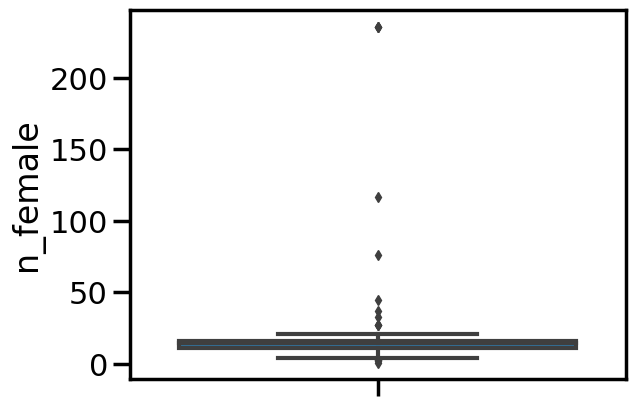

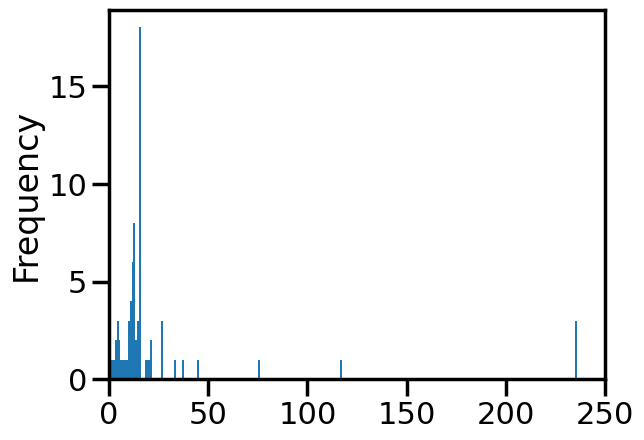

In [58]:
participants_female["n_female"] = participants_female["n_female"].astype(int)
print(participants_female['n_female'].mean())
g = sns.boxplot(y="n_female", data=participants_female)
plt.show()
participants_female['n_female'].plot(bins = 250,kind ='hist', xlim = [0,250])
plt.show()

In [59]:
df_p_range_age = df_participants.groupby(['paper_id', 'range_age']).nth(0)
df_p_range_age.reset_index(inplace =  True)

In [60]:
df_p_range_age['range_age'].unique()

array(['-', '19-37', '19-40', '18-22', '1-3', '21-30', '20-40', '19-30',
       '21-39', '21-25', '21-59', '23-36', '25-35', '19-25', '23-57',
       '22-45', '20-35', '21-24', '20-50', '25-28', '25-65', '21-38',
       '23-44', '20-25', '24-34', '19-24', '20-34', '17-60', '18-29',
       '22-32', '18-28', '20-26', '20-36', '18-45', '21-28', '20-23'],
      dtype=object)

In [61]:
df_p_range_age_no_cero= df_p_range_age[df_p_range_age['range_age'] != '-']

In [62]:
df_p_range_age_no_cero

index  paper_id  model_id  \
2        2         3         3   
3        4         4         5   
4        9         5        10   
5       11         6        12   
8       42         9        43   
9       43        10        44   
10      44        11        45   
11      46        12        47   
14      66        15        67   
15      92        16        93   
16      94        17        95   
18     128        19       129   
19     129        20       130   
21     143        22       144   
22     146        23       147   
23     148        24       149   
24     150        25       151   
25     153        26       154   
34     194        35       195   
35     198        36       199   
37     206        37       207   
38     213        37       214   
39     227        37       228   
40     241        38       242   
44     258        42       259   
45     260        43       261   
46     261        44       263   
47     262        45       264   
48     267        46       269   
49     268        47       270   
50     269        48       271   
53     276        51       278   
54     277        52       279   
57     286        55       288   
59     293        57       295   
62     302        59       304   
63     308        60       310   
64     313        60       315   
65     328        61       330   
67     339        63       341   
70     344        66       346   
72     357        68       359   
73     358        69       360   
74     359        70       361   
79     383        75       385   
80     416        76       418   
81     418        77       420   
83     421        79       423   
85     429        81       431   
87     439        83       441   
88     451        84       453   
90     459        86       461   
91     461        87       463   
92     462        88       464   
93     463        89       465   
101    491        97       493   

                                          apa_citation    n n_female mean_age  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...   27       16    26.06   
10   Girardi, D., Lanubile, F., & Novielli, N. (201...   19        3        -   
11   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...   20        -    22.83   
14   Md Ali, S. H., Ibne Reaz, M., Ahmad, S. A., Mi...   25        -    23.92   
15   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   27       16    26.06   
16   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...   35       14        -   
18   Hernández-García, A., Fernández-Martínez, F., ...   22       12        -   
19   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   27       16    26.06   
21   Nisa’Minhad, K., Ali, S. H. M., Khai, J. O. S....   19        -        -   
22   Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   32       16     26.9   
23   Greco, A., Valenza, G., Citi, L., & Scilingo, ...   25        -        -   
24   Minhad, K. N., Ali, S. H. M. D., & Reaz, M. B....   23       15        -   
25   Zhang, Q., Lai, X., & Liu, G. (2016). Emotion ...   35        -        -   
34   Ferdinando, H., & Alasaarela, E. (2018). Emoti...   27       16    26.06   
35   Zhang, S., Liu, G., & Lai, X. (2015). Classifi...  255      117     22.1   
37   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   32       16     26.9   
38   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   10        7    35.60   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   27       16    26.06   
40   Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   32       16     26.9   
44   Kostoulas, T., Chanel, G., Muszynski

In [63]:
df_p_range_age_no_cero["range_age"].value_counts()

range_age
19-37    10
19-40     9
18-22     2
19-25     2
21-38     2
23-36     2
17-60     1
20-25     1
24-34     1
19-24     1
20-34     1
18-29     1
22-32     1
18-28     1
20-26     1
20-36     1
18-45     1
21-28     1
23-44     1
20-50     1
25-65     1
25-28     1
21-24     1
20-35     1
22-45     1
23-57     1
25-35     1
21-59     1
21-25     1
21-39     1
19-30     1
20-40     1
21-30     1
1-3       1
20-23     1
Name: count, dtype: int64

In [64]:
df_p_range_age_cero_na= df_p_range_age[df_p_range_age['range_age'] == '-']
df_p_range_age_cero_na
#48

index  paper_id  model_id  \
0        0         1         1   
1        1         2         2   
6       19         7        20   
7       39         8        40   
12      50        13        51   
13      51        14        52   
17     126        18       127   
20     131        21       132   
26     154        27       155   
27     157        28       158   
28     166        29       167   
29     172        30       173   
30     175        31       176   
31     178        32       179   
32     184        33       185   
33     190        34       191   
36     199        37       200   
41     249        39       250   
42     250        40       251   
43     254        41       255   
51     274        49       276   
52     275        50       277   
55     278        53       280   
56     283        54       285   
58     291        56       293   
60     298        57       300   
61     301        58       303   
66     331        62       333   
68     342        64       344   
69     343        65       345   
71     356        67       358   
75     365        71       367   
76     367        72       369   
77     372        73       374   
78     375        74       377   
82     420        78       422   
84     425        80       427   
86     437        82       439   
89     453        85       455   
94     467        90       469   
95     469        91       471   
96     475        92       477   
97     476        93       478   
98     478        94       480   
99     480        95       482   
100    490        96       492   
102    493        98       495   
103    497        99       499   

                                          apa_citation    n n_female mean_age  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20        -   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...    -        -        -   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...   15        3     27.5   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...    6        -        -   
12   Setyohadi, D. B., Kusrohmaniah, S., Gunawan, S...   39        -        -   
13   Soleymani, M., & Mortillaro, M. (2018). Behavi...   52       33     25.7   
17   Keren, G., Kirschstein, T., Marchi, E., Ringev...   46       27       22   
20   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...    8        -        -   
26   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...   11       11    22.73   
27   Das, P., Khasnobish, A., & Tibarewala, D. N. (...    -        -        -   
28   Gupta, R., Abadi, M. K., Cabré, J. A. C., Morr...   33       12     29.7   
29   Ooi, J. S. K., Ahmad, S. A., Chong, Y. Z., Ali...   20        4    22.83   
30   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...   11       11    22.73   
31   Siddharth,  null, Jung, T.-P., & Sejnowski, T....   40       13     28.3   
32   Goshvarpour, A., Abbasi, A., & Goshvarpour, A....   11       11    22.73   
33   Dumitriu, T., Cimpanu, C., Ungureanu, F., & Ma...   10        6        -   
36   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   58       21       30   
41   Martínez-Rodrigo, A., Zangróniz, R., Pastor, J...   21       12        -   
42   Milchevski, A., Rozza, A., & Taskovski, D. (20...    -        -        -   
43   Ringeval, F., Eyben, F., Kroupi, E., Yuce, A.,...   46       27       22   
51   Drungilas, D., Bielskis, A. A., & Denisov, V. ...    -        -        -   
52   Wu, G., Liu, G., & Hao, M. (2010). The Analysi...  254        -        -   
55   Ren, P., Barreto, A., Gao, Y., & Adjouadi, M. ...   30        -        -   
56   Cheng, J., & Liu, G. (2013). Computing nonline...    -        -       20   
58   Guo, R., Li, S., He, L., Gao, W., Qi, H., & Ow...    4        -        -   
60   Henriques, R., Paiva, A., & Antunes, C. (2013)...   13        5        -   
61   Li, S., Guo, R., He, L., Gao, W., Qi, H., & Ow...    4        -        -   
66   Martinez, R., Salazar-Ramirez, A., Arruti, A.,...   32        -  

In [65]:
df_p_mean_age = df_participants.groupby(['paper_id', 'mean_age']).nth(0)
df_p_mean_age.reset_index(inplace =  True)

In [66]:
df_p_mean_with_age= df_p_mean_age[df_p_mean_age['mean_age'] != '-']
df_p_mean_with_age

index  paper_id  model_id  \
2        2         3         3   
3        4         4         5   
4        9         5        10   
6       19         7        20   
9       43        10        44   
..     ...       ...       ...   
99     476        93       478   
102    480        95       482   
103    490        96       492   
104    491        97       493   
105    493        98       495   

                                          apa_citation   n n_female mean_age  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  27       27    19.44   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...  15        3     27.5   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...  27       16    26.06   
..                                                 ...  ..      ...      ...   
99   Rahim, A., Sagheer, A., Nadeem, K., Dar, M. N....  40       13     28.3   
102  Yang, H. C., & Lee, C. C. (2019, September). A...  40       13     28.3   
103  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  22        -       20   
104  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  32       16     26.9   
105  Subramanian, R., Wache, J., Abadi, M. K., Vier...  58       21       30   

    meadian_age range_age  country  
2             -     19-37        -  
3             -     19-40        -  
4             -     18-22        -  
6             -         -  Germany  
9             -     19-40        -  
..          ...       ...      ...  
99            -         -        -  
102           -         -        -  
103           -         -   Poland  
104           -     19-37        -  
105           -         -        -  

[63 rows x 10 columns]

In [67]:
df_p_mean_with_no_age= df_p_mean_age[df_p_mean_age['mean_age'] == '-']
df_p_mean_with_no_age
#44

index  paper_id  model_id  \
0        0         1         1   
1        1         2         2   
5       11         6        12   
7       39         8        40   
8       42         9        43   
10      44        11        45   
12      50        13        51   
16      94        17        95   
18     128        19       129   
20     131        21       132   
21     143        22       144   
23     148        24       149   
24     150        25       151   
25     153        26       154   
27     157        28       158   
33     190        34       191   
39     220        37       221   
43     249        39       250   
44     250        40       251   
48     261        44       263   
50     267        46       269   
51     268        47       270   
53     274        49       276   
54     275        50       277   
55     276        51       278   
56     277        52       279   
57     278        53       280   
60     291        56       293   
62     298        57       300   
63     301        58       303   
68     331        62       333   
71     343        65       345   
78     367        72       369   
85     421        79       423   
86     425        80       427   
87     429        81       431   
89     439        83       441   
91     453        85       455   
93     461        87       463   
96     467        90       469   
97     469        91       471   
100    477        93       479   
101    478        94       480   
106    497        99       499   

                                          apa_citation    n n_female mean_age  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20        -   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...    -        -        -   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...    6        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
10   Girardi, D., Lanubile, F., & Novielli, N. (201...   19        3        -   
12   Setyohadi, D. B., Kusrohmaniah, S., Gunawan, S...   39        -        -   
16   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...   35       14        -   
18   Hernández-García, A., Fernández-Martínez, F., ...   22       12        -   
20   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...    8        -        -   
21   Nisa’Minhad, K., Ali, S. H. M., Khai, J. O. S....   19        -        -   
23   Greco, A., Valenza, G., Citi, L., & Scilingo, ...   25        -        -   
24   Minhad, K. N., Ali, S. H. M. D., & Reaz, M. B....   23       15        -   
25   Zhang, Q., Lai, X., & Liu, G. (2016). Emotion ...   35        -        -   
27   Das, P., Khasnobish, A., & Tibarewala, D. N. (...    -        -        -   
33   Dumitriu, T., Cimpanu, C., Ungureanu, F., & Ma...   10        6        -   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...    -        -        -   
43   Martínez-Rodrigo, A., Zangróniz, R., Pastor, J...   21       12        -   
44   Milchevski, A., Rozza, A., & Taskovski, D. (20...    -        -        -   
48   Lanatà, A., Valenza, G., & Scilingo, E. P. (20...   35        -        -   
50   GOUIZI, K., BEREKSI REGUIG, F., & MAAOUI, C. (...    4        2        -   
51   Bornoiu, I.-V., Strungaru, R., & Grigore, O. (...    -        -        -   
53   Drungilas, D., Bielskis, A. A., & Denisov, V. ...    -        -        -   
54   Wu, G., Liu, G., & Hao, M. (2010). The Analysi...  254        -        -   
55   Giakoumis, D., Tzovaras, D., Moustakas, K., & ...   19        4        -   
56   Safta, I., Grigore, O., & Căruntu, C.(2011). E...   13        -        -   
57   Ren, P., Barreto, A., Gao, Y., & Adjouadi, M. ...   30        -        -   
60   Guo, R., Li, S., He, L., Gao, W., Qi, H., & Ow...    4        -        -   
62   Henriques, R., Paiva, A., & Antunes, C. (2013)...   13        5        -   
63   Li, S., Guo, R., He, L., Gao, W., Qi, H

25.812857142857144
19.44
36.1


C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\2064706475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_mean_with_age["mean_age"] = df_p_mean_with_age["mean_age"].astype(float)


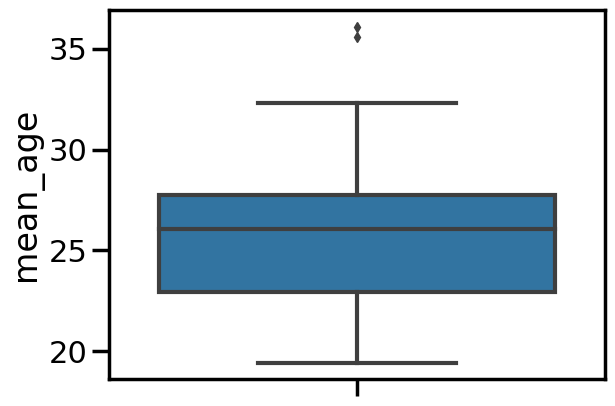

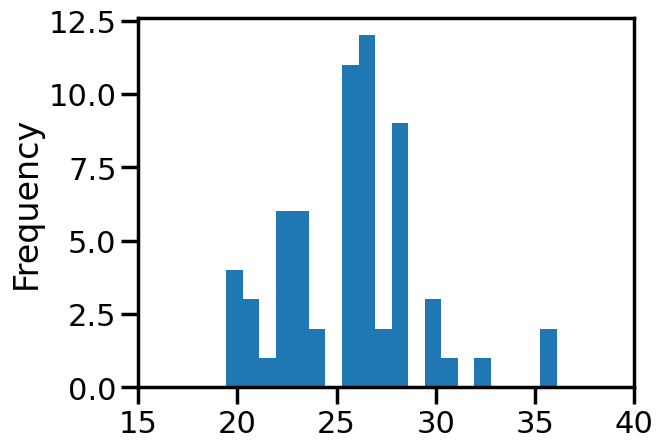

In [68]:
df_p_mean_with_age["mean_age"] = df_p_mean_with_age["mean_age"].astype(float)
print(df_p_mean_with_age['mean_age'].mean())
print(df_p_mean_with_age['mean_age'].min())
print(df_p_mean_with_age['mean_age'].max())
g = sns.boxplot(y="mean_age", data=df_p_mean_with_age)
plt.show()
df_p_mean_with_age['mean_age'].plot(bins = 20,kind ='hist', xlim = [15,40])
plt.show()

In [69]:
df_participants.loc[df_participants['range_age'] == "-", 'range_age'] = "0"

In [70]:
range_age = df_p_range_age[df_p_range_age['range_age'] != '-']
range_age

index  paper_id  model_id  \
2        2         3         3   
3        4         4         5   
4        9         5        10   
5       11         6        12   
8       42         9        43   
9       43        10        44   
10      44        11        45   
11      46        12        47   
14      66        15        67   
15      92        16        93   
16      94        17        95   
18     128        19       129   
19     129        20       130   
21     143        22       144   
22     146        23       147   
23     148        24       149   
24     150        25       151   
25     153        26       154   
34     194        35       195   
35     198        36       199   
37     206        37       207   
38     213        37       214   
39     227        37       228   
40     241        38       242   
44     258        42       259   
45     260        43       261   
46     261        44       263   
47     262        45       264   
48     267        46       269   
49     268        47       270   
50     269        48       271   
53     276        51       278   
54     277        52       279   
57     286        55       288   
59     293        57       295   
62     302        59       304   
63     308        60       310   
64     313        60       315   
65     328        61       330   
67     339        63       341   
70     344        66       346   
72     357        68       359   
73     358        69       360   
74     359        70       361   
79     383        75       385   
80     416        76       418   
81     418        77       420   
83     421        79       423   
85     429        81       431   
87     439        83       441   
88     451        84       453   
90     459        86       461   
91     461        87       463   
92     462        88       464   
93     463        89       465   
101    491        97       493   

                                          apa_citation    n n_female mean_age  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...   27       16    26.06   
10   Girardi, D., Lanubile, F., & Novielli, N. (201...   19        3        -   
11   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...   20        -    22.83   
14   Md Ali, S. H., Ibne Reaz, M., Ahmad, S. A., Mi...   25        -    23.92   
15   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   27       16    26.06   
16   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...   35       14        -   
18   Hernández-García, A., Fernández-Martínez, F., ...   22       12        -   
19   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...   27       16    26.06   
21   Nisa’Minhad, K., Ali, S. H. M., Khai, J. O. S....   19        -        -   
22   Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   32       16     26.9   
23   Greco, A., Valenza, G., Citi, L., & Scilingo, ...   25        -        -   
24   Minhad, K. N., Ali, S. H. M. D., & Reaz, M. B....   23       15        -   
25   Zhang, Q., Lai, X., & Liu, G. (2016). Emotion ...   35        -        -   
34   Ferdinando, H., & Alasaarela, E. (2018). Emoti...   27       16    26.06   
35   Zhang, S., Liu, G., & Lai, X. (2015). Classifi...  255      117     22.1   
37   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   32       16     26.9   
38   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   10        7    35.60   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...   27       16    26.06   
40   Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...   32       16     26.9   
44   Kostoulas, T., Chanel, G., Muszynski

In [71]:
range_age['range_age'] = range_age['range_age'].str.replace('-',' ')
range_age['range_age'].str.split()
df_ranges = range_age['range_age'].str.split(pat = ' ', expand = True)
df_ranges = df_ranges.dropna()
df_ranges

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\176192115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_age['range_age'] = range_age['range_age'].str.replace('-',' ')


0   1
2    19  37
3    19  40
4    18  22
5     1   3
8    21  30
9    19  40
10   20  40
11   19  30
14   21  39
15   19  40
16   21  25
18   21  59
19   19  40
21   23  36
22   19  37
23   25  35
24   23  36
25   18  22
34   19  40
35   19  25
37   19  37
38   23  57
39   19  40
40   19  37
44   22  45
45   20  35
46   21  24
47   20  50
48   25  28
49   25  65
50   21  38
53   23  44
54   20  25
57   24  34
59   19  24
62   19  40
63   19  37
64   19  40
65   20  34
67   19  37
70   19  37
72   17  60
73   19  40
74   19  37
79   18  29
80   22  32
81   18  28
83   19  25
85   20  26
87   20  36
88   18  45
90   19  37
91   21  28
92   21  38
93   20  23
101  19  37

In [72]:
df_ranges[0] = df_ranges[0].astype(int)
df_ranges[1] = df_ranges[1].astype(int)

In [73]:
df_ranges[0].min()

1

In [74]:
df_ranges[1].max()

65

In [75]:
first = df_ranges[0].to_list()
second = df_ranges[1].to_list()
final_list = first + second
df_range_merged = pd.DataFrame(final_list, columns = ['ages'])
df_range_merged

ages
0      19
1      19
2      18
3       1
4      21
..    ...
107    37
108    28
109    38
110    23
111    37

[112 rows x 1 columns]

In [76]:
print(df_range_merged['ages'].mean())

27.794642857142858


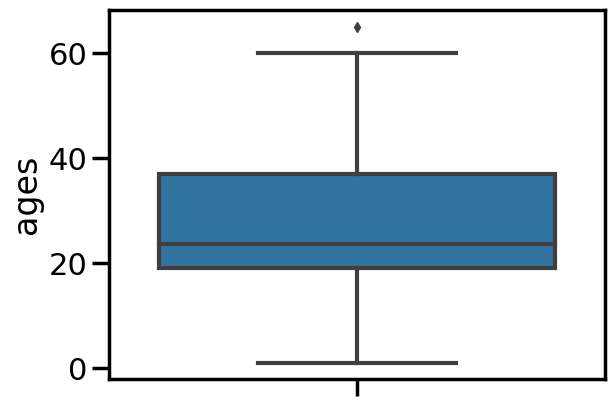

In [77]:
g = sns.boxplot(y="ages", data=df_range_merged)
plt.show()

### 4. Self-report

In [78]:
df_self_report = df_self_report.fillna('-')

#### ¿Cuantas veces fueron testeadas juntas las distintas dimensiones y categorias emocionales?

##### Primero obtenemos las categorias emocionales usadas y su frecuencia

* Hubo 55 modelos que usaron categorias emocionales, siendo disgust, fear, y sadness las mas repetidas.
* Tener en cuenta que un modelo puede usar mas de una categoria, por lo que la funcion get_values no funciona en este caso, y un paper puede concentrar la mayoria de los usos de un conjunto de categorias

In [79]:
emotional_categories_grouped = df_self_report.groupby(['paper_id','stress', 'disgust', 'fear', 'sadness', 'surprise' ,'happiness', 'pleasant',
                            'anxiety', 'neutral', 'funny', 'boredom', 'relaxation', 'amusement', 'joy']).nth(0)
emotional_categories_grouped.reset_index(inplace=True)

In [80]:
emotional_categories_grouped = fn.multi_reversing(
    emotional_categories_grouped, 'paper_id', 
    emotional_categories_grouped
    [[
    'stress', 'disgust', 'fear', 'sadness', 'surprise' ,'happiness', 'pleasant',
    'anxiety', 'neutral', 'funny', 'boredom', 'relaxation', 'amusement', 'joy'
    ]])

In [81]:
emotional_categories_grouped

paper_id variable value
74          72   stress     x
106          4  disgust     x
112         10  disgust     x
118         16  disgust     x
122         20  disgust     x
...        ...      ...   ...
1376        37      joy     x
1399        59      joy     x
1400        60      joy     x
1410        69      joy     x
1431        90      joy     x

[138 rows x 3 columns]

In [82]:
print(emotional_categories_grouped['variable'].value_counts())
print(emotional_categories_grouped['variable'].unique())

variable
disgust       19
fear          19
sadness       19
neutral       19
surprise      17
anxiety       11
amusement     10
joy           10
happiness      8
boredom        2
stress         1
pleasant       1
funny          1
relaxation     1
Name: count, dtype: int64
['stress' 'disgust' 'fear' 'sadness' 'surprise' 'happiness' 'pleasant'
 'anxiety' 'neutral' 'funny' 'boredom' 'relaxation' 'amusement' 'joy']


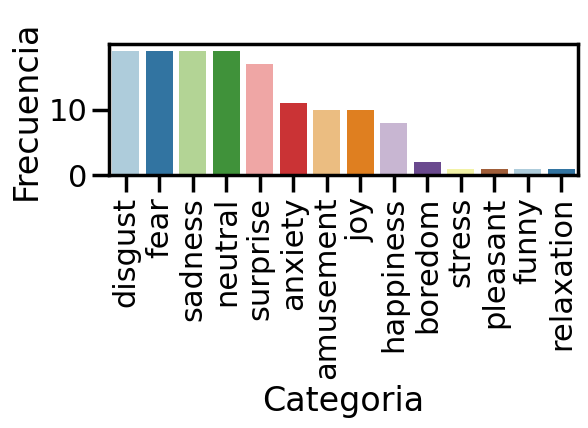

In [83]:
titulos = [' ', 'Categoria', 'Frecuencia']
fn.bar_plot('variable',emotional_categories_grouped,titulos)

In [84]:
emotional_dimensions_grouped = df_self_report.groupby([
    'paper_id','valence',
    'arousal', 'dominance', 'like_dislike', 'familiarity', 'engagement',
    'predictability']).nth(0)
emotional_dimensions_grouped.reset_index(inplace=True)

In [85]:
emotional_dimensions_grouped = fn.multi_reversing(
    emotional_dimensions_grouped, 'paper_id', 
    emotional_dimensions_grouped
    [[
    'valence',
    'arousal', 'dominance', 'like_dislike', 'familiarity', 'engagement',
    'predictability'
    ]])

In [86]:
emotional_dimensions_grouped

paper_id        variable value
2           3         valence     x
3           4         valence     x
4           5         valence     x
9          10         valence     x
10         11         valence     x
..        ...             ...   ...
658        35  predictability     x
663        37  predictability     x
685        59  predictability     x
686        60  predictability     x
696        69  predictability     x

[177 rows x 3 columns]

In [87]:
print(emotional_dimensions_grouped['variable'].value_counts())
print(emotional_dimensions_grouped['variable'].unique())

variable
valence           49
arousal           49
dominance         29
like_dislike      20
familiarity       19
predictability     9
engagement         2
Name: count, dtype: int64
['valence' 'arousal' 'dominance' 'like_dislike' 'familiarity' 'engagement'
 'predictability']


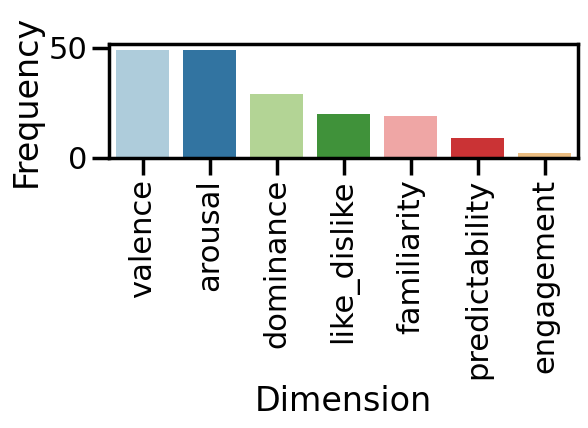

In [88]:
titulos = [' ', 'Dimension', 'Frequency']
fn.bar_plot('variable',emotional_dimensions_grouped,titulos)

In [89]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [90]:
df_alg_perf['model']  = df_alg_perf.apply(lambda row: label_model(row), axis=1)

In [91]:
df_alg_perf['model'].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [92]:
df_models = df_alg_perf[["apa_citation",'model', "year", "model_id"]]

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de modelos')]

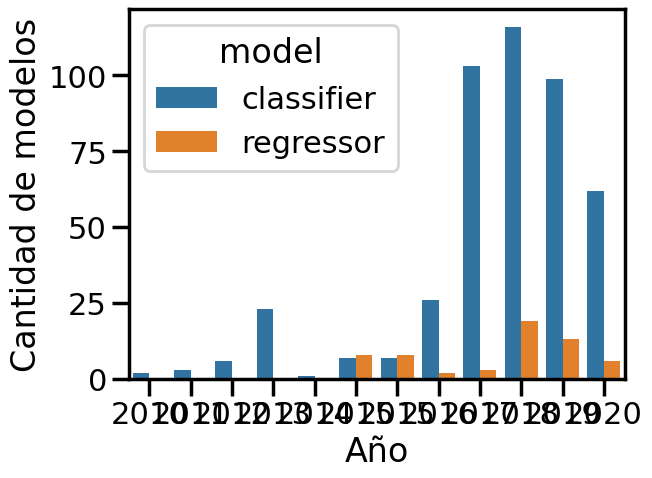

In [93]:
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de modelos')

In [94]:
df_models["model"].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [95]:
df_models["model"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

model
classifier    89.8%
regressor     10.2%
Name: proportion, dtype: object

#### Grafo

In [372]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)

df_self_report.columns = [col.capitalize() for col in df_self_report.columns]

self_0 = df_self_report[df_self_report['Is_categorial']!= '-']

df_matrix_con_paperid_0 = self_0.groupby(
        ["Paper_id", 'Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant','Anxiety', 'Neutral', 'Funny', 'Amusement', 'Joy']
        ).nth(0)
df_matrix_con_paperid_0.reset_index(inplace=True)

print(df_matrix_con_paperid_0)

df_matrix = df_matrix_con_paperid_0[['Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant','Anxiety', 'Neutral', 'Funny', 'Amusement', 'Joy']]

df_matrix = df_matrix.replace('-', 0)
df_matrix = df_matrix.replace('x', 1)
adj_matrix = df_matrix.T.dot(df_matrix)
np.fill_diagonal(adj_matrix.values, 0)

    index  Paper_id  Model_id  \
0       4         4         5   
1      43        10        44   
2      92        16        93   
3     129        20       130   
4     178        32       179   
5     194        35       195   
6     227        37       228   
7     234        37       235   
8     260        43       261   
9     302        59       304   
10    308        60       310   
11    342        64       344   
12    356        67       358   
13    358        69       360   
14    365        71       367   
15    367        72       369   
16    375        74       377   
17    383        75       385   
18    437        82       439   
19    453        85       455   
20    467        90       469   
21    476        93       478   
22    480        95       482   

                                         Apa_citation Use_questionnaire  \
0   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....               Yes   
1   Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...    

In [373]:
adj_matrix

Disgust  Fear  Sadness  Surprise  Happiness  Pleasant  Anxiety  \
Disgust          0    19       19        17          8         1       10   
Fear            19     0       19        17          8         1       10   
Sadness         19    19        0        17          8         1       10   
Surprise        17    17       17         0          8         0        9   
Happiness        8     8        8         8          0         0        0   
Pleasant         1     1        1         0          0         0        1   
Anxiety         10    10       10         9          0         1        0   
Neutral         17    17       17        17          8         0        9   
Funny            0     0        0         0          0         0        0   
Amusement       10    10       10         9          0         0        9   
Joy              9     9        9         9          0         0        9   

           Neutral  Funny  Amusement  Joy  
Disgust         17      0         10    9  
Fear            17      0         10    9  
Sadness         17      0         10    9  
Surprise        17      0          9    9  
Happiness        8      0          0    0  
Pleasant         0      0          0    0  
Anxiety          9      0          9    9  
Neutral          0      1          9    9  
Funny            1      0          0    0  
Amusement        9      0          0    9  
Joy              9      0          9    0

In [374]:
G = nx.DiGraph(adj_matrix)

In [375]:
weights = nx.get_edge_attributes(G,'weight').values()


"""labels=nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G,pos,
        edge_labels=labels,
        font_size=20,
        font_color="black",
        font_weight="bold")"""

'labels=nx.get_edge_attributes(G, "weight")\nnx.draw_networkx_edge_labels(G,pos,\n        edge_labels=labels,\n        font_size=20,\n        font_color="black",\n        font_weight="bold")'

In [376]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

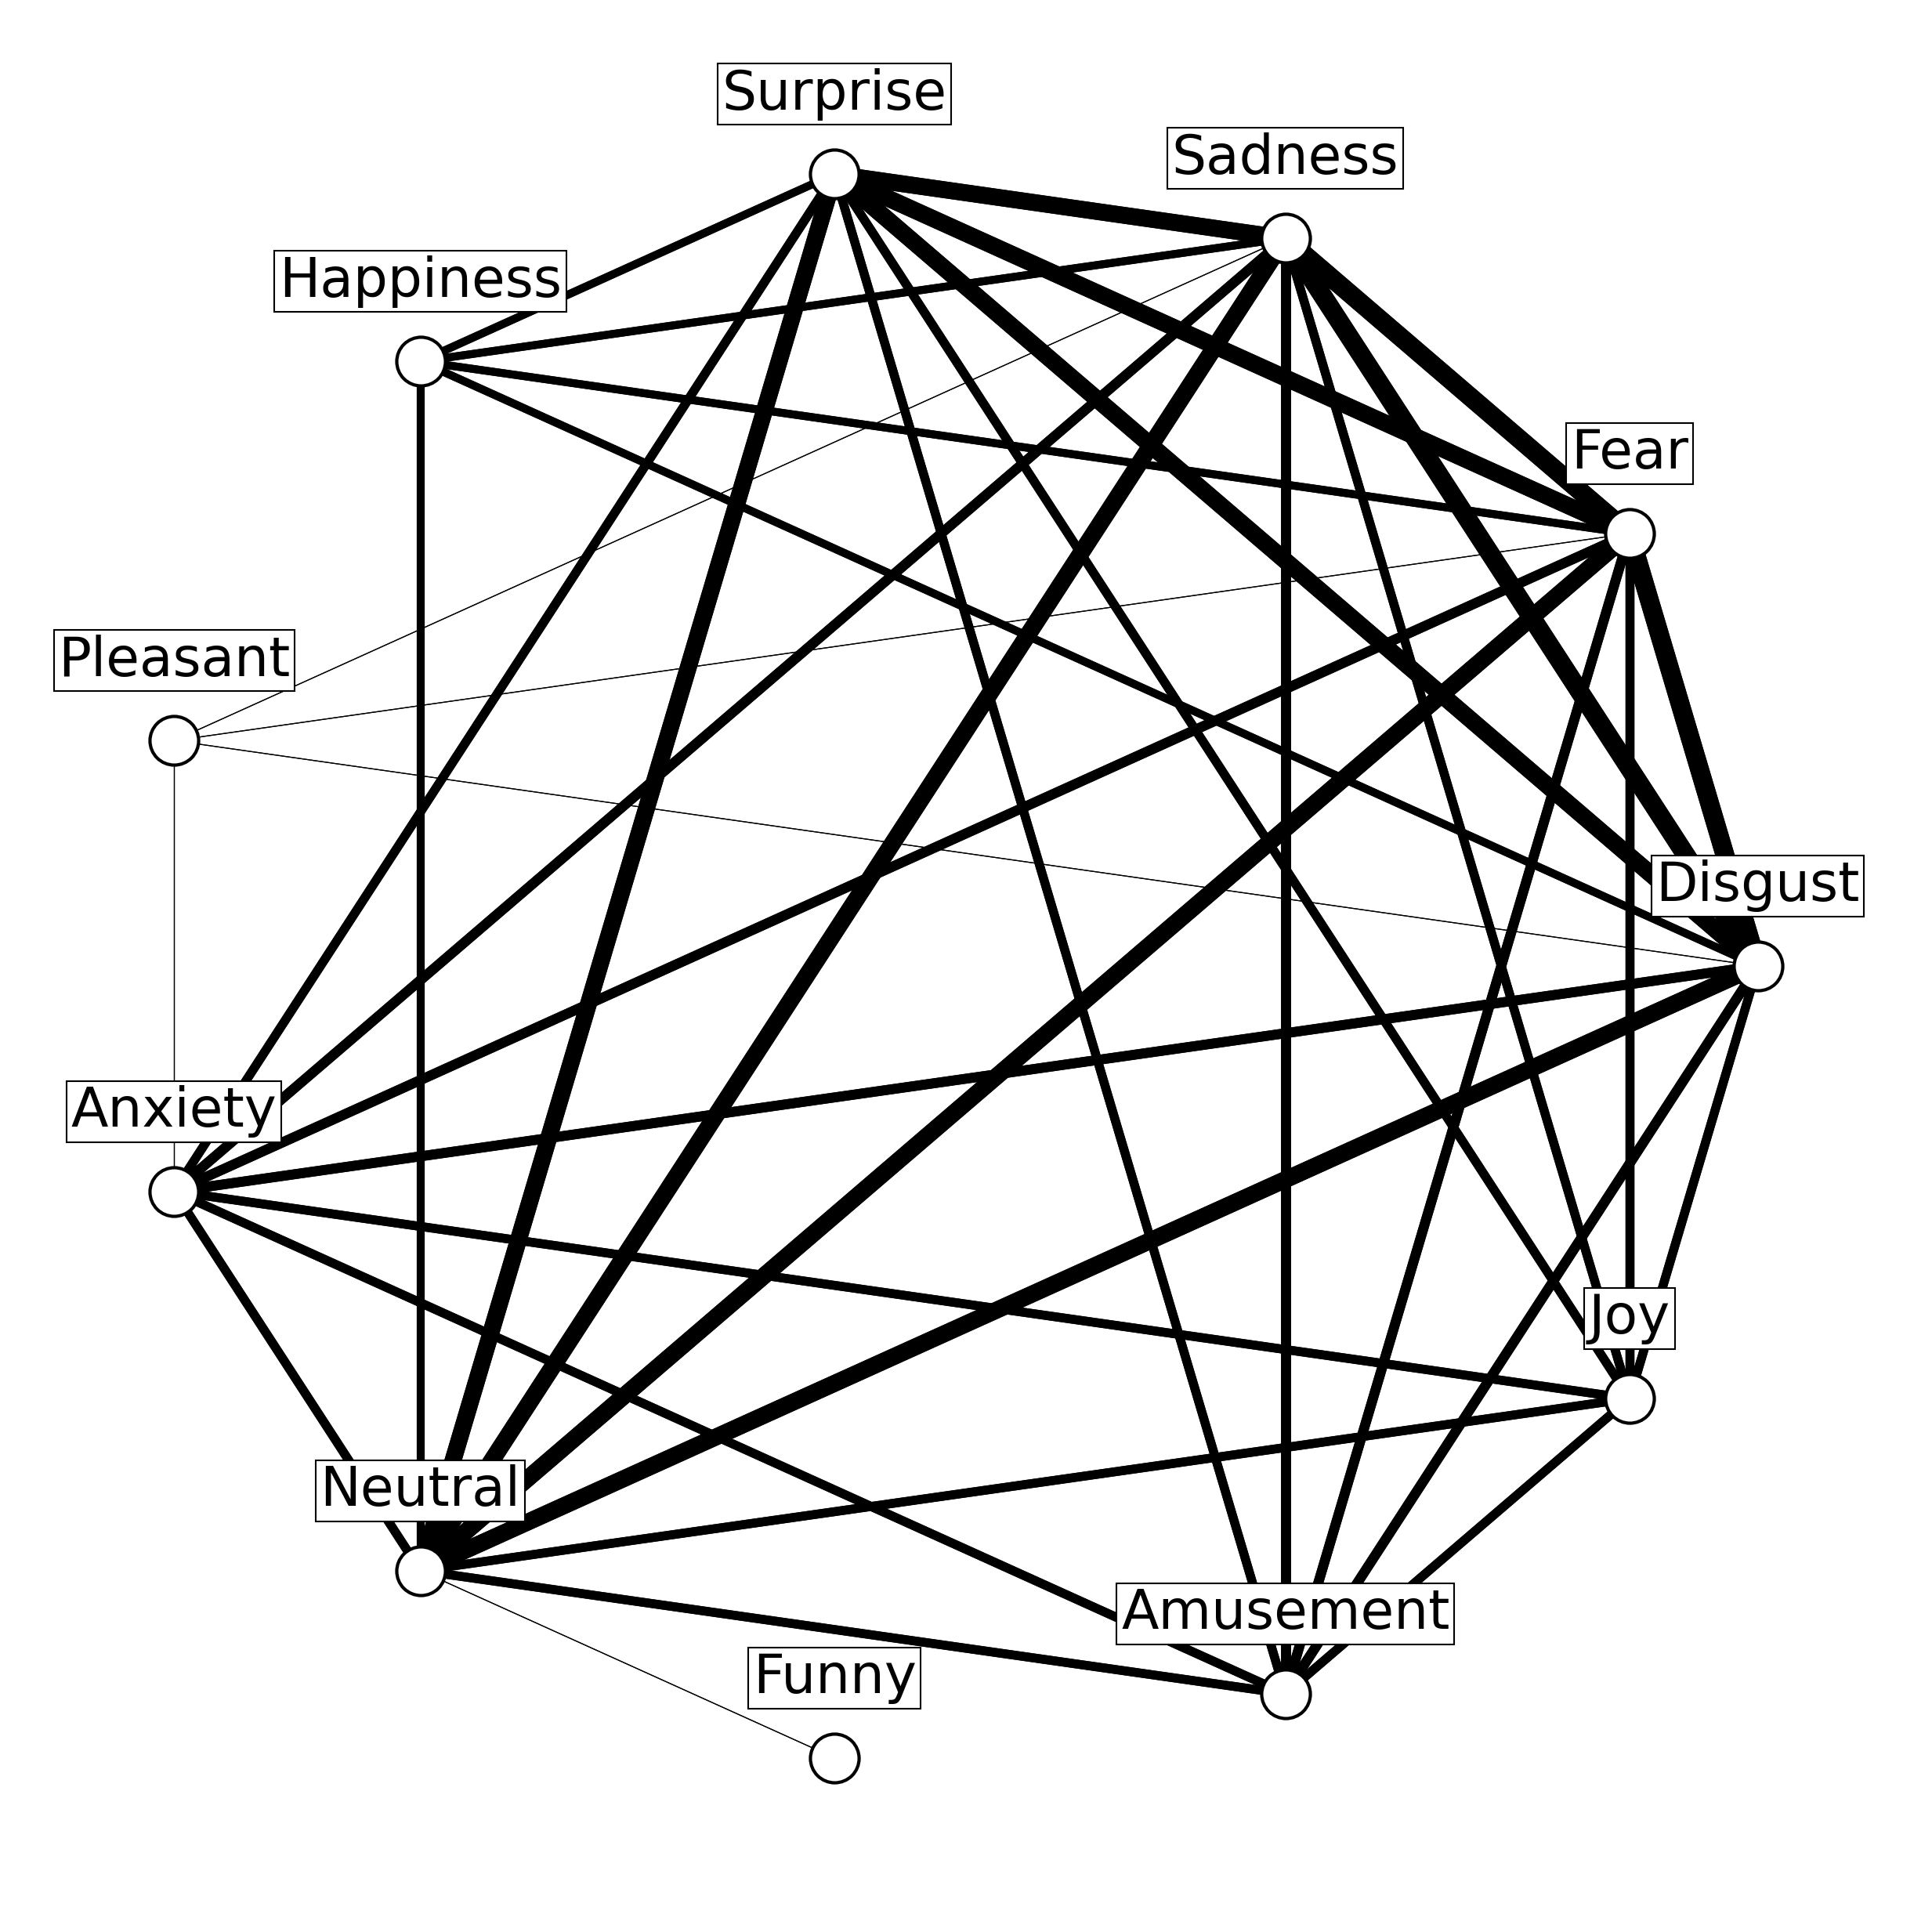

In [377]:
fig, ax = plt.subplots(figsize=(25, 25))

pos = nx.circular_layout(G)

nx.draw(G, pos, 
        edgecolors="black", 
        node_color='white',
        width=[i/1.1 for i in weights],
        node_size=2000,
        linewidths=3,
        alpha=1,
        font_size=25,
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

boxes = dict(facecolor='white', alpha=1)

pos_nodes = nudge(pos, 0, 0.1)    
nx.draw_networkx_labels(G, pos=pos_nodes, labels=None, font_size=50, font_color='k',
                        font_family='sans serif', font_weight='normal', alpha=None, bbox=boxes, horizontalalignment='center', 
                        verticalalignment='center', ax=None, clip_on=True)

plt.tight_layout()

In [378]:
fn.relaciones(weights)

Interacciones con 9 conexiones se observaron 12.0 veces.
Interacciones con 17 conexiones se observaron 7.0 veces.
Interacciones con 10 conexiones se observaron 6.0 veces.
Interacciones con 1 conexiones se observaron 5.0 veces.
Interacciones con 8 conexiones se observaron 5.0 veces.
Interacciones con 19 conexiones se observaron 3.0 veces.


Grafo para dimensiones emocionales (no categorias emocionales)

In [379]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)

df_self_report.rename(columns={'Like_dislike': 'Preference'}, inplace=True)

self_dim = df_self_report[df_self_report['Is_dimensional']!= '-']

df_matrix_con_paperid_dim = self_dim.groupby(
        ['Paper_id', 'Valence','Arousal', 'Dominance', 'Preference', 'Familiarity', 'Engagement','Predictability', "Stress", "Boredom", "Relaxation"]
        ).nth(0)
df_matrix_con_paperid_dim.reset_index(inplace=True)

df_matrix_dim = df_matrix_con_paperid_dim[
        ['Valence','Arousal', 'Dominance', 'Preference', 'Familiarity', 'Engagement','Predictability', "Stress", "Boredom", "Relaxation"]
        ]

df_matrix_dim = df_matrix_dim.replace('-', 0)
df_matrix_dim = df_matrix_dim.replace('x', 1)
adj_matrix_dim = df_matrix_dim.T.dot(df_matrix_dim)
np.fill_diagonal(adj_matrix_dim.values, 0)

In [380]:
adj_matrix_dim

Valence  Arousal  Dominance  Preference  Familiarity  \
Valence               0       49         29          20           19   
Arousal              49        0         29          20           19   
Dominance            29       29          0          17           17   
Preference           20       20         17           0           19   
Familiarity          19       19         17          19            0   
Engagement            2        2          0           2            2   
Predictability        9        9          9           0            0   
Stress                0        0          0           0            0   
Boredom               0        0          0           0            0   
Relaxation            0        0          0           0            0   

                Engagement  Predictability  Stress  Boredom  Relaxation  
Valence                  2               9       0        0           0  
Arousal                  2               9       0        0           0  
Dominance                0               9       0        0           0  
Preference               2               0       0        0           0  
Familiarity              2               0       0        0           0  
Engagement               0               0       0        0           0  
Predictability           0               0       0        0           0  
Stress                   0               0       0        0           0  
Boredom                  0               0       0        0           0  
Relaxation               0               0       0        0           0

In [381]:
Gd = nx.DiGraph(adj_matrix_dim)

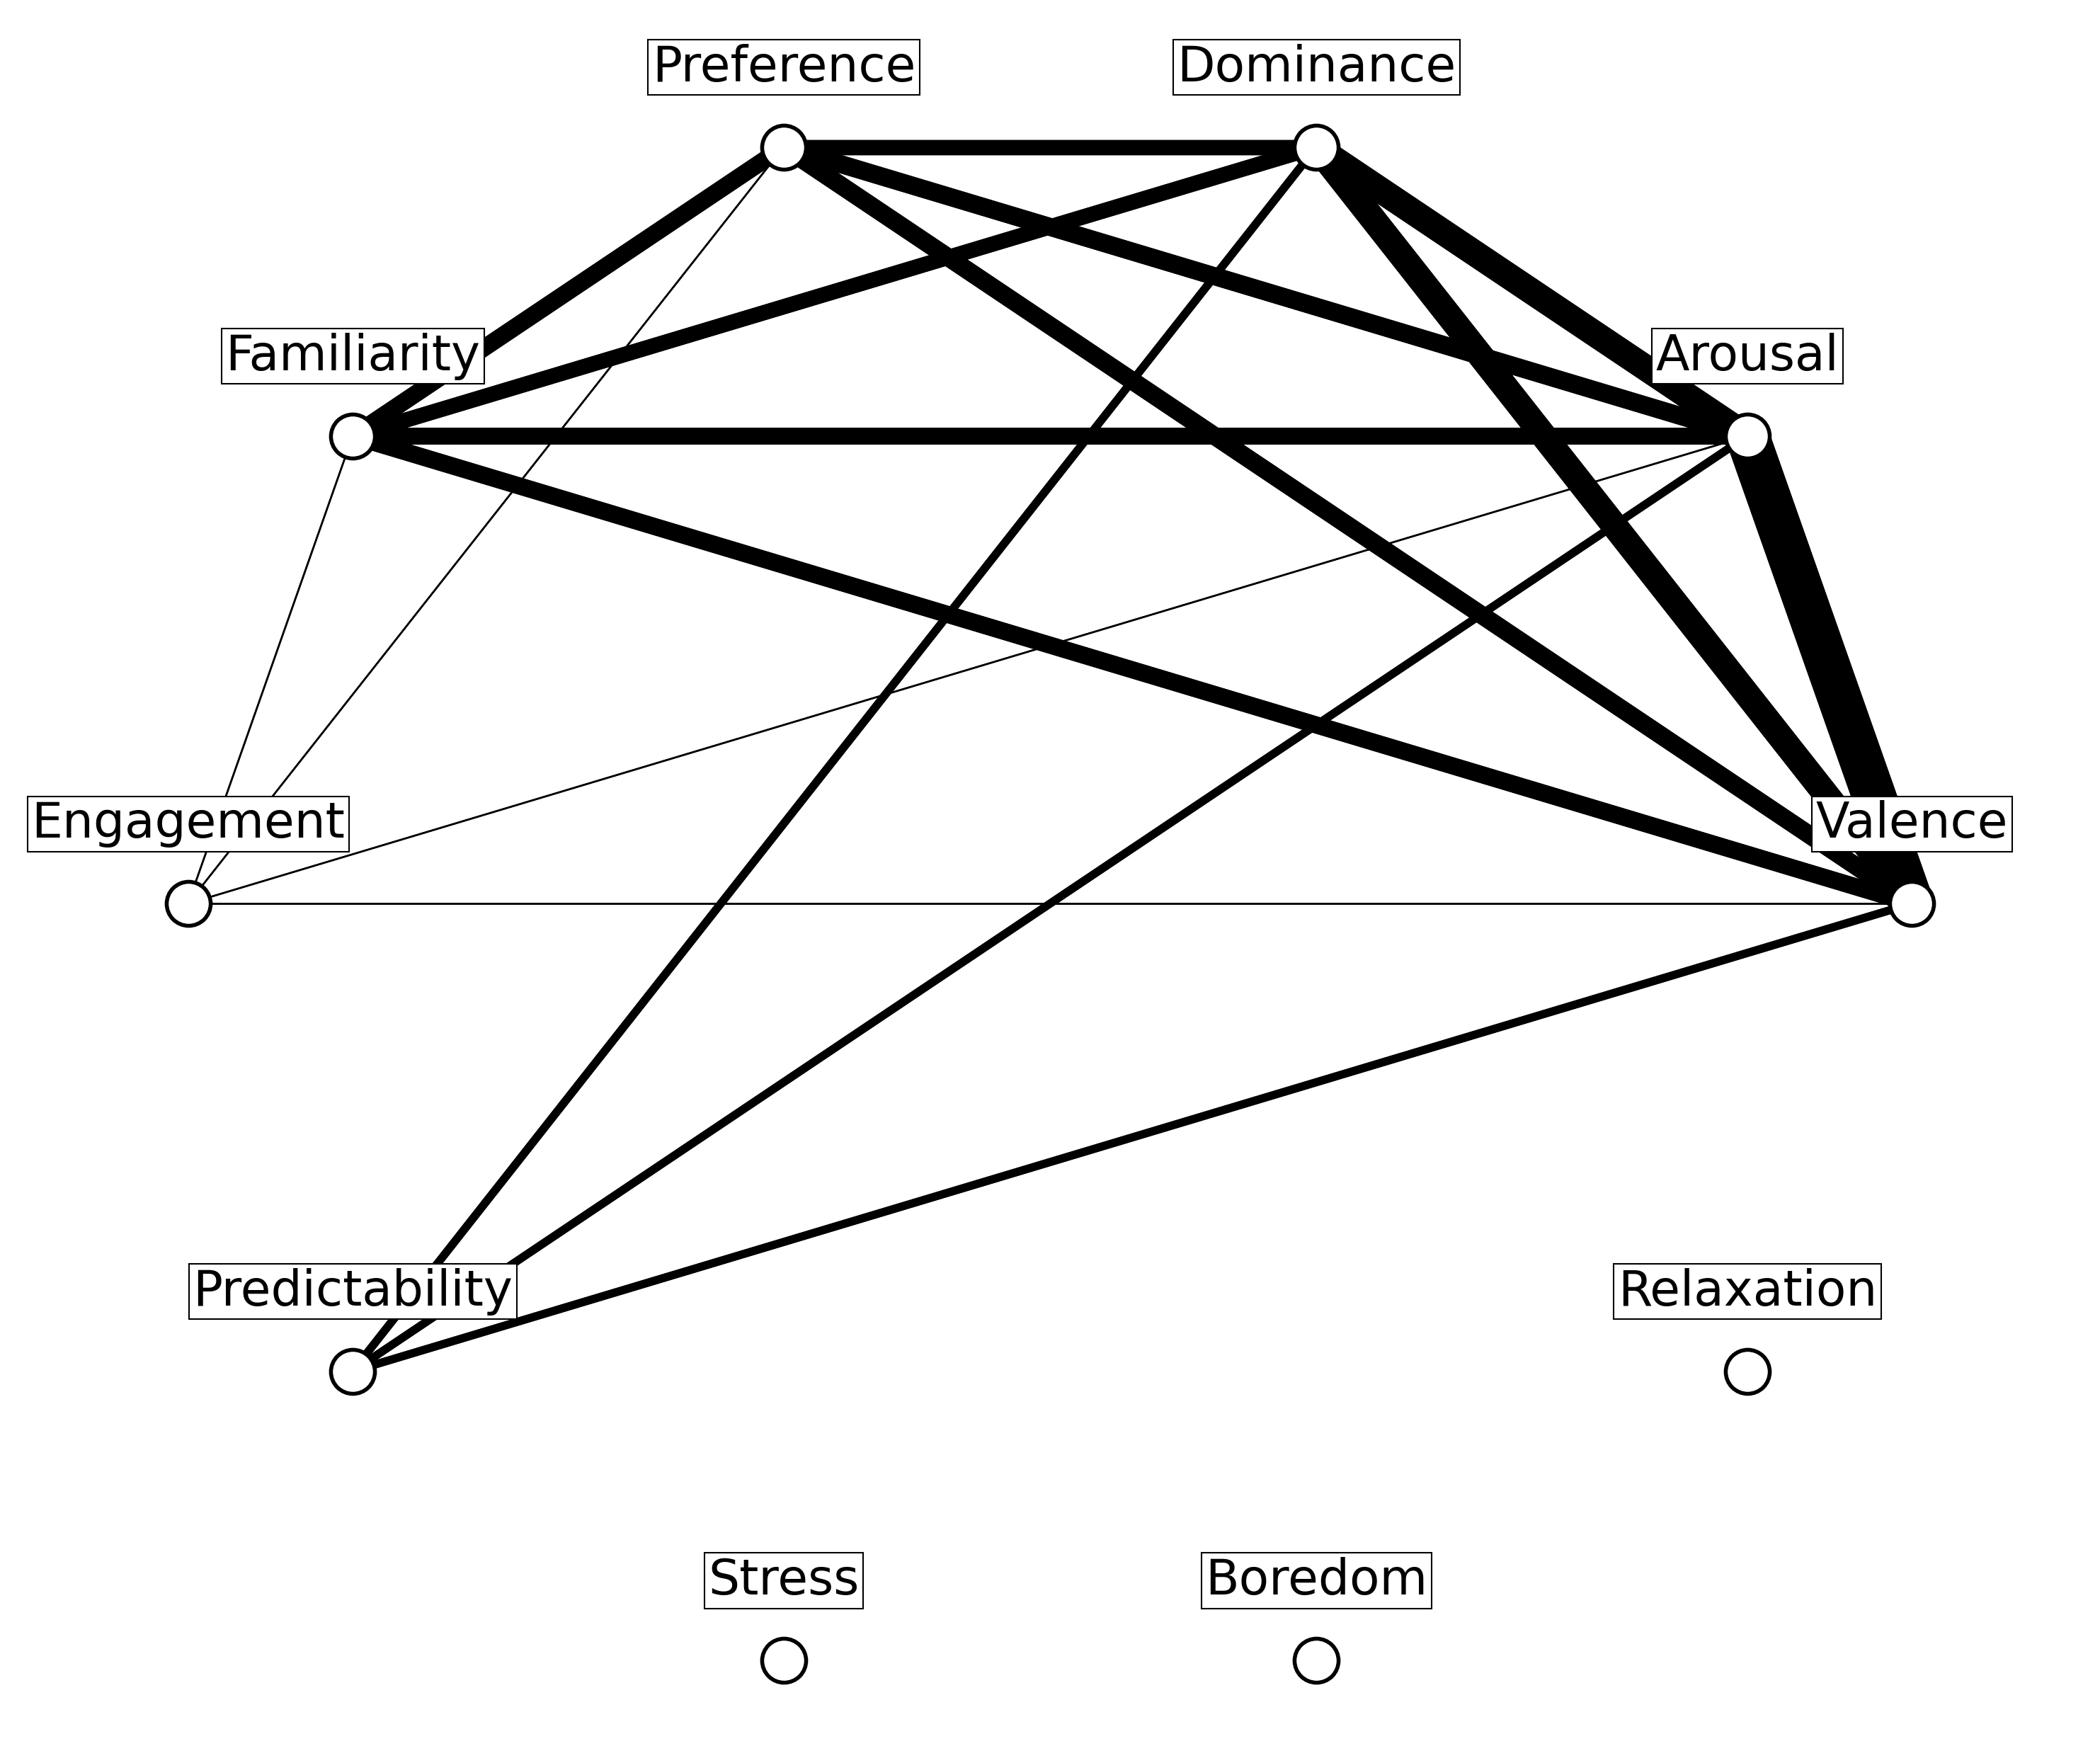

In [382]:
weights2 = nx.get_edge_attributes(Gd,'weight').values()

fig, ax = plt.subplots(figsize=(30, 25))

pos = nx.circular_layout(Gd)

nx.draw(Gd, pos, 
        edgecolors="black", 
        node_color='white',
        width=[i/1.1 for i in weights2],
  
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

boxes = dict(facecolor='white', alpha=1)

pos_nodes = nudge(pos, 0, 0.1)    
nx.draw_networkx_labels(Gd, pos=pos_nodes, labels=None, font_size=50, font_color='k',
                        font_family='sans serif', font_weight='normal', alpha=None, bbox=boxes, horizontalalignment='center', 
                        verticalalignment='center', ax=None, clip_on=True)

plt.tight_layout()

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3075779137.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=90)
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3075779137.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dimensions, rotation=90)


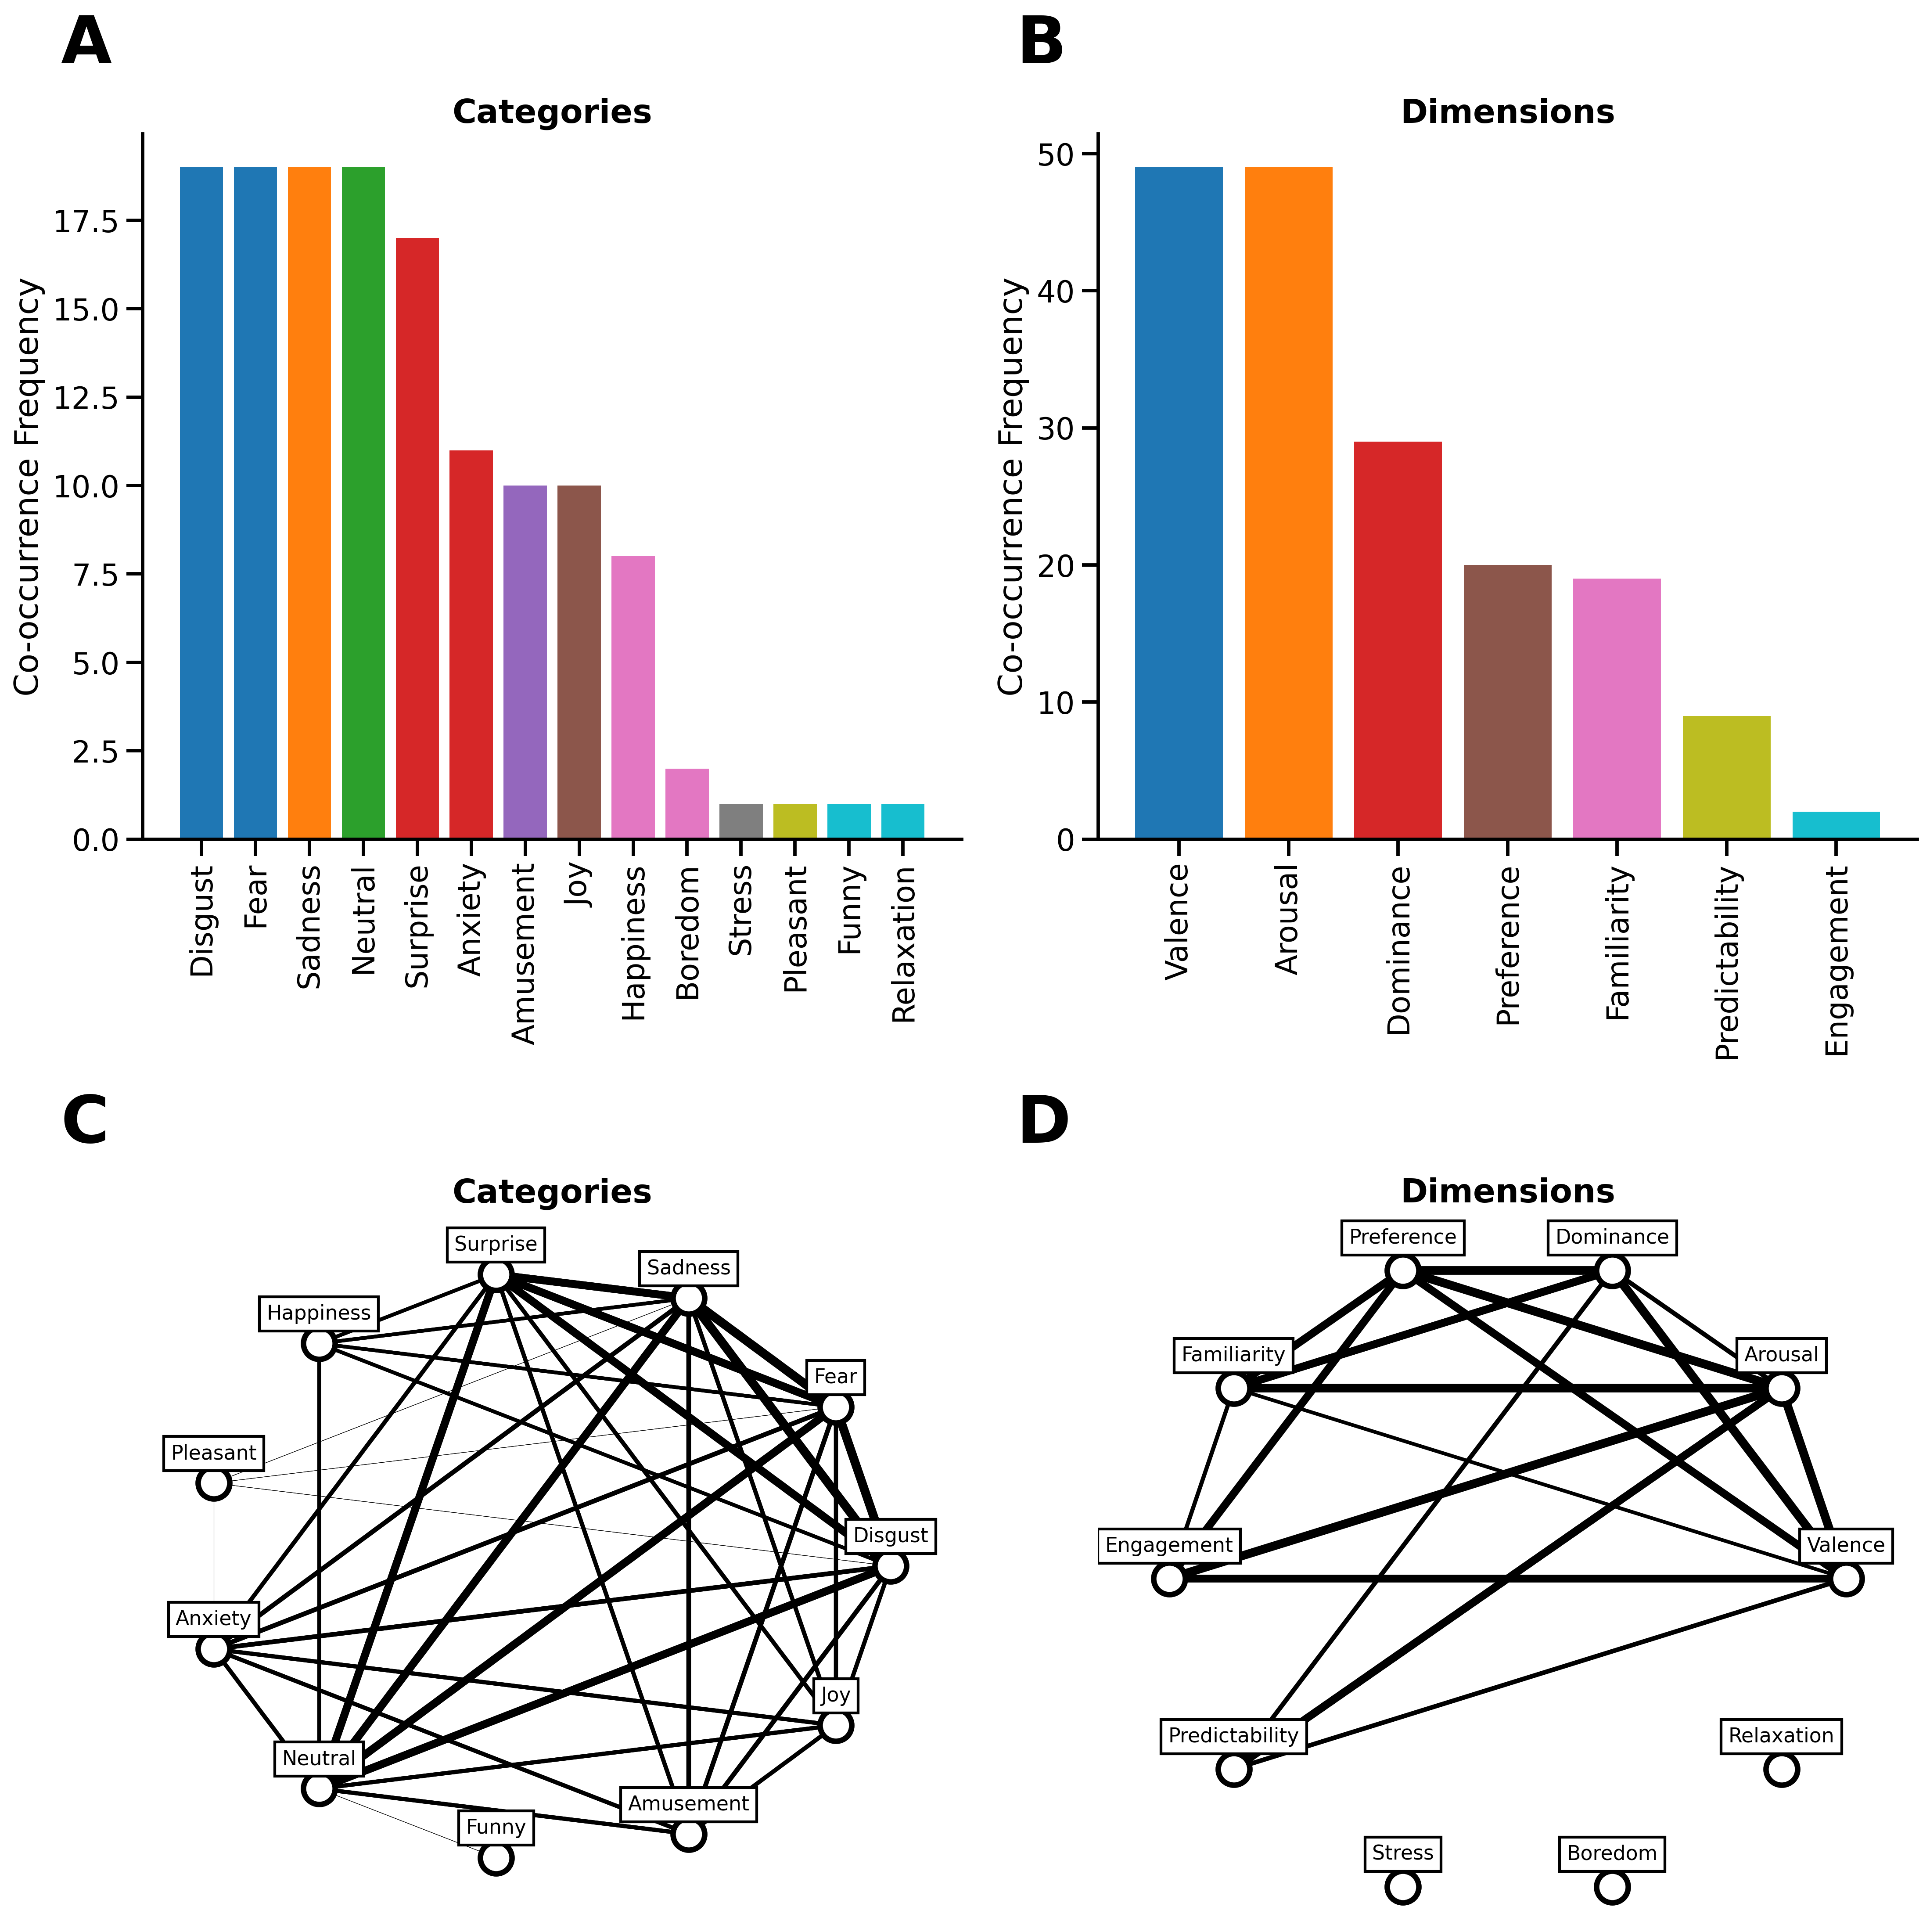

In [387]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import seaborn as sns

# Set the context for even bigger fonts
sns.set_context("talk")

# Count frequencies
categories_count = emotional_categories_grouped['variable'].value_counts()
dimensions_count = emotional_dimensions_grouped['variable'].value_counts()

# Create figure with custom GridSpec
fig = plt.figure(figsize=(15, 15), dpi=300)
gs = gridspec.GridSpec(2, 2) #, height_ratios=[0.4, 1], width_ratios=[1, 1])

# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
categories = categories_count.index.tolist()
categories = [category.capitalize() for category in categories]
values = categories_count.tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
ax1.bar(categories, values, color=colors)
ax1.set_title('Categories', fontweight='bold')
ax1.set_ylabel('Co-occurrence Frequency')
ax1.set_xticklabels(categories, rotation=90)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')

# SUBPLOT B
ax2 = plt.subplot(gs[0, 1])
dimensions = dimensions_count.index.tolist()
dimensions = [dimension.capitalize() for dimension in dimensions]
dimensions = ['Preference' if dim == 'Like_dislike' else dim for dim in dimensions]
values2 = dimensions_count.tolist()
colors_b = plt.cm.tab10(np.linspace(0, 1, len(dimensions)))
ax2.bar(dimensions, values2, color=colors_b)
ax2.set_title('Dimensions', fontweight='bold')
ax2.set_ylabel('Co-occurrence Frequency')
ax2.set_xticklabels(dimensions, rotation=90)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')



# SUBPLOT C
ax3 = plt.subplot(gs[1, 0])
pos_C = nx.circular_layout(G)
# Nudging labels to the lower left corner for Subplot C
pos_nodes_C = nudge(pos_C, 0, 0.1)
nx.draw(G, pos_C, ax=ax3, edgecolors="black", node_color='white', linewidths=3, font_size=10, font_weight="bold", width=[i/4 for i in weights],arrows=False)
nx.draw_networkx_labels(G, pos=pos_nodes_C, labels=None, font_size=11, font_color='k',
                        font_family='sans-serif', font_weight='normal', alpha=None, bbox=boxes, 
                        horizontalalignment='center', verticalalignment='center', ax=ax3)
ax3.set_title('Categories', fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=36, fontweight='bold')

# SUBPLOT D
ax4 = plt.subplot(gs[1, 1])
pos_D = nx.circular_layout(Gd)
# Nudging labels to the lower left corner for Subplot D
pos_nodes_D = nudge(pos_D, 0, 0.1)
nx.draw(Gd, pos_D, ax=ax4, edgecolors="black", node_color='white', linewidths=3, font_size=10, font_weight="bold", width=[i/4 for i in weights], arrows=False)
nx.draw_networkx_labels(Gd, pos=pos_nodes_D, labels=None, font_size=11, font_color='k',
                        font_family='sans-serif', font_weight='normal', alpha=None, bbox=boxes, 
                        horizontalalignment='center', verticalalignment='center', ax=ax4)
ax4.set_title('Dimensions', fontweight='bold')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=36, fontweight='bold')

sns.despine(ax=ax1)
sns.despine(ax=ax2)
sns.despine(ax=ax3)
sns.despine(ax=ax4)

# Tight layout and show
plt.tight_layout()
plt.show()

In [108]:
fn.relaciones(weights)

Interacciones con 9 conexiones se observaron 12.0 veces.
Interacciones con 17 conexiones se observaron 7.0 veces.
Interacciones con 10 conexiones se observaron 6.0 veces.
Interacciones con 1 conexiones se observaron 5.0 veces.
Interacciones con 8 conexiones se observaron 5.0 veces.
Interacciones con 19 conexiones se observaron 3.0 veces.


In [109]:
df_self_report

Paper_id  Model_id                                       Apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

                   Use_questionnaire Affective_questionnaire_sam  \
0    Relies on other's questionnaire                           x   
1                                 No                           -   
2                                Yes                           x   
3                                Yes                           x   
4                                Yes                           x   
..                               ...                         ...   
494                              Yes                           -   
495                              Yes                           -   
496                              Yes                           -   
497                              Yes                           x   
498                              Yes                           x   

    Affective_questionnaire_pss Affective_questionnaire_panas  \
0                             -                             -   
1                             -                             -   
2                             -                             -   
3                             -                             -   
4                             -                             -   
..                          ...                           ...   
494                           -                             -   
495                           -                             -   
496                           -                             -   
497                           -                             -   
498                           -                             -   

    Affective_questionnaire_des Affective_questionnaire_affective_grid  \
0                             -                                      -   
1                             -                                      -   
2                             -                                      -   
3                             -                                      -   
4                             -                                      -   
..                          ...                                    ...   
494                           -                                      -   
495                           -                                      -   
496                           -                                      -   
497                           -                                      -   
498                           -                                      -   

    Is_dimensional  ... Fear Sadness Surprise Happiness Pleasant Anxiety  \
0                -  ...    -       -        -         -        -       -   
1                -  ...    -       -        -         -        -       -   
2                x  ...    -       -        -         -        -       -   
3                x  ...    -       -        -         -        -       -   
4                x  ...    x       x        x         -        -       x   
..             ...  ...  ...     ...      ...       ...      ...     ...   
494              x  ...    -       -        -    

In [110]:
df_self_report

Paper_id  Model_id                                       Apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

                   Use_questionnaire Affective_questionnaire_sam  \
0    Relies on other's questionnaire                           x   
1                                 No                           -   
2                                Yes                           x   
3                                Yes                           x   
4                                Yes                           x   
..                               ...                         ...   
494                              Yes                           -   
495                              Yes                           -   
496                              Yes                           -   
497                              Yes                           x   
498                              Yes                           x   

    Affective_questionnaire_pss Affective_questionnaire_panas  \
0                             -                             -   
1                             -                             -   
2                             -                             -   
3                             -                             -   
4                             -                             -   
..                          ...                           ...   
494                           -                             -   
495                           -                             -   
496                           -                             -   
497                           -                             -   
498                           -                             -   

    Affective_questionnaire_des Affective_questionnaire_affective_grid  \
0                             -                                      -   
1                             -                                      -   
2                             -                                      -   
3                             -                                      -   
4                             -                                      -   
..                          ...                                    ...   
494                           -                                      -   
495                           -                                      -   
496                           -                                      -   
497                           -                                      -   
498                           -                                      -   

    Is_dimensional  ... Fear Sadness Surprise Happiness Pleasant Anxiety  \
0                -  ...    -       -        -         -        -       -   
1                -  ...    -       -        -         -        -       -   
2                x  ...    -       -        -         -        -       -   
3                x  ...    -       -        -         -        -       -   
4                x  ...    x       x        x         -        -       x   
..             ...  ...  ...     ...      ...       ...      ...     ...   
494              x  ...    -       -        -    

In [111]:
df_self_report.columns = [col.lower() for col in df_self_report.columns]


In [112]:
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace('x',"Yes")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace('-',"No")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace("Relies on  other's questionnaire","Relies on other's questionnaire")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace("Relies on other´s questionaire","Relies on other's questionnaire")

In [113]:
df_self_report.iloc[:,0:9]
used_questionnaries = df_self_report.groupby(['paper_id', "use_questionnaire"]).nth(0)
used_questionnaries.reset_index(inplace= True)
used_questionnaries["use_questionnaire"].value_counts()

use_questionnaire
No                                 48
Yes                                48
Relies on other's questionnaire     6
No                                  1
Name: count, dtype: int64

In [114]:
used_questionnaries["use_questionnaire"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

use_questionnaire
No                                 46.6%
Yes                                46.6%
Relies on other's questionnaire     5.8%
No                                  1.0%
Name: proportion, dtype: object

In [115]:
questionnaries = df_self_report.groupby(['paper_id', 'affective_questionnaire_sam','affective_questionnaire_pss', 
                                         "affective_questionnaire_panas", "affective_questionnaire_des", "affective_questionnaire_affective_grid"]).nth(0)
questionnaries.reset_index(inplace= True)
questionnaries = fn.multi_reversing(questionnaries, 'paper_id', questionnaries[['affective_questionnaire_sam','affective_questionnaire_pss', "affective_questionnaire_panas", "affective_questionnaire_des", "affective_questionnaire_affective_grid"]])
questionnaries['variable'].value_counts()

variable
affective_questionnaire_sam               37
affective_questionnaire_panas             12
affective_questionnaire_affective_grid     2
affective_questionnaire_pss                1
affective_questionnaire_des                1
Name: count, dtype: int64

In [116]:
questionnaries['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
affective_questionnaire_sam               69.8%
affective_questionnaire_panas             22.6%
affective_questionnaire_affective_grid     3.8%
affective_questionnaire_pss                1.9%
affective_questionnaire_des                1.9%
Name: proportion, dtype: object

#### relax_bore_stress

In [117]:
df_self_report_compressed = df_self_report[["apa_citation", "boredom", "relaxation", "stress"]]
relax_bore_stress = df_self_report_compressed[df_self_report_compressed['boredom'].isin(['x', 'X']) | df_self_report_compressed['relaxation'].isin(['x', 'X']) | df_self_report_compressed['stress'].isin(['x', 'X'])]

In [118]:
relax_bore_stress

apa_citation boredom relaxation  \
276  Giakoumis, D., Tzovaras, D., Moustakas, K., & ...       x          -   
328  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
329  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
330  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
331  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
332  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
333  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
334  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
335  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
336  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
337  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
338  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
367  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
368  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
369  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
370  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
371  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   

    stress  
276      -  
328      -  
329      -  
330      -  
331      -  
332      -  
333      -  
334      -  
335      -  
336      -  
337      -  
338      -  
367      x  
368      x  
369      x  
370      x  
371      x

### 5. Emotion elicitation techniques

In [119]:
df_eet.fillna('-', inplace= True)

In [120]:
df_technniques_no_dup = df_eet.drop_duplicates(subset="paper_id")

In [121]:
df_technniques_no_dup = df_technniques_no_dup.groupby(['paper_id',"technique_name"]).nth(0)
df_technniques_no_dup.reset_index(inplace=True)

In [122]:
df_technniques_no_dup["technique_name"].value_counts()

technique_name
-                                               75
IAPS                                            10
survival task                                    2
Rapid-ABC play protocol                          1
TSST                                             1
Trier Social Stress Test (TSST)                  1
Flickr                                           1
IADS                                             1
Robin                                            1
-G25\r\nLogitech steering wheel kit              1
Stroop color-word interference test’’ (SCWT)     1
Trier social stress test                         1
Visit website with interruptions                 1
Stroop                                           1
Stoop color word interfence test (SCWT)          1
Name: count, dtype: int64

In [123]:
df_technniques_no_dup["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
-                                               75.8%
IAPS                                            10.1%
survival task                                    2.0%
Rapid-ABC play protocol                          1.0%
TSST                                             1.0%
Trier Social Stress Test (TSST)                  1.0%
Flickr                                           1.0%
IADS                                             1.0%
Robin                                            1.0%
-G25\r\nLogitech steering wheel kit              1.0%
Stroop color-word interference test’’ (SCWT)     1.0%
Trier social stress test                         1.0%
Visit website with interruptions                 1.0%
Stroop                                           1.0%
Stoop color word interfence test (SCWT)          1.0%
Name: proportion, dtype: object

In [124]:
df_eet.columns

Index(['paper_id', 'model_id', 'apa_citation', 'is_multimodal',
       'modality_visual', 'modality_auditory', 'modality_somatosensory',
       'task_type_active', 'task_type_pasive', 'technique_name',
       'visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
       'auditory_music', 'auditory_other',
       'technique_clasif_multiple_techniques', 'technique_clasif_driving',
       'technique_clasif_imagination_techniques_or_memory_recall',
       'technique_clasif_social_interactions',
       'technique_clasif_virtual_reality', 'technique_clasif_meditation',
       'technique_clasif_reading', 'technique_clasif_ux',
       'technique_clasif_tactile_enhanced_multimedia_clips',
       'technique_clasif_videogame', 'technique_clasif_puzzle',
       'technique_description', 'elicitation_duration',
       'elicitation_duration_range', 'elicitation_duration_mean',
       'elicitation_duration_median'],
      dtype='object')

In [125]:
df_eet["technique_name"].value_counts()

technique_name
-                                               388
IAPS                                             29
TSST                                             20
Flickr                                           15
Rapid-ABC play protocol                           8
survival task                                     6
Robin                                             6
Stroop color-word interference test’’ (SCWT)      5
Visit website with interruptions                  5
Stroop                                            5
Stoop color word interfence test (SCWT)           5
-G25\r\nLogitech steering wheel kit               3
IADS                                              2
Trier Social Stress Test (TSST)                   1
Trier social stress test                          1
Name: count, dtype: int64

In [126]:
df_eet["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
-                                               77.8%
IAPS                                             5.8%
TSST                                             4.0%
Flickr                                           3.0%
Rapid-ABC play protocol                          1.6%
survival task                                    1.2%
Robin                                            1.2%
Stroop color-word interference test’’ (SCWT)     1.0%
Visit website with interruptions                 1.0%
Stroop                                           1.0%
Stoop color word interfence test (SCWT)          1.0%
-G25\r\nLogitech steering wheel kit              0.6%
IADS                                             0.4%
Trier Social Stress Test (TSST)                  0.2%
Trier social stress test                         0.2%
Name: proportion, dtype: object

In [127]:
techniques_defined = df_eet[df_eet["technique_name"] != "-"]
techniques_defined["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
IAPS                                            26.1%
TSST                                            18.0%
Flickr                                          13.5%
Rapid-ABC play protocol                          7.2%
survival task                                    5.4%
Robin                                            5.4%
Stroop color-word interference test’’ (SCWT)     4.5%
Visit website with interruptions                 4.5%
Stroop                                           4.5%
Stoop color word interfence test (SCWT)          4.5%
-G25\r\nLogitech steering wheel kit              2.7%
IADS                                             1.8%
Trier Social Stress Test (TSST)                  0.9%
Trier social stress test                         0.9%
Name: proportion, dtype: object

In [128]:
df_eet["is_multimodal"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

is_multimodal
x    65.9%
-    34.1%
Name: proportion, dtype: object

In [129]:
type_task = df_eet.groupby(['paper_id', 'task_type_active','task_type_pasive']).nth(0)
type_task.reset_index(inplace= True)

In [130]:
len(type_task[(type_task['task_type_active'] == '-') &
            (type_task['task_type_pasive'] == '-')])

21

In [131]:
task_type = fn.multi_reversing(type_task, 'model_id', type_task[['task_type_active','task_type_pasive']])
task_type['variable'].value_counts()

variable
task_type_pasive    66
task_type_active    20
Name: count, dtype: int64

In [132]:
task_type['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
task_type_pasive    76.7%
task_type_active    23.3%
Name: proportion, dtype: object

In [133]:
freq_modality = df_eet.groupby(['paper_id','is_multimodal','modality_visual','modality_auditory', 'modality_somatosensory']).nth(0)
freq_modality.reset_index(inplace=True)

In [134]:
df_modality = fn.multi_reversing(freq_modality, 'model_id', freq_modality[['is_multimodal','modality_visual','modality_auditory', 'modality_somatosensory']])
df_modality['variable'].value_counts()

variable
modality_visual           82
modality_auditory         73
is_multimodal             58
modality_somatosensory     1
Name: count, dtype: int64

In [135]:
df_modality['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
modality_visual           38.3%
modality_auditory         34.1%
is_multimodal             27.1%
modality_somatosensory     0.5%
Name: proportion, dtype: object

In [136]:
number_modality = sum(df_modality['variable'].value_counts())
print (f'Se hallaron {number_modality} instancias en total entre multimodal, visual, auditory y somatosensory.')

Se hallaron 214 instancias en total entre multimodal, visual, auditory y somatosensory.


In [137]:
visual_modality = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other']).nth(0)
visual_modality.reset_index(inplace=True)

df_visual_modality = fn.multi_reversing(visual_modality, 'model_id', visual_modality[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other']])
df_visual_modality['variable'].value_counts()

variable
visual_videos      56
visual_pictures    16
visual_words        2
Name: count, dtype: int64

In [138]:
df_visual_modality['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
visual_videos      75.7%
visual_pictures    21.6%
visual_words        2.7%
Name: proportion, dtype: object

In [139]:
other_techniques = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
'auditory_music', 'auditory_other', 'technique_clasif_driving',
'technique_clasif_imagination_techniques_or_memory_recall',
'technique_clasif_social_interactions',
'technique_clasif_virtual_reality', 'technique_clasif_meditation',
'technique_clasif_reading', 'technique_clasif_ux',
'technique_clasif_tactile_enhanced_multimedia_clips',
'technique_clasif_videogame', 'technique_clasif_puzzle']).nth(0)
other_techniques.reset_index(inplace=True)

df_other_techniques = fn.multi_reversing(other_techniques, 'model_id', other_techniques[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
'auditory_music', 'auditory_other', 'technique_clasif_driving',
'technique_clasif_imagination_techniques_or_memory_recall',
'technique_clasif_social_interactions',
'technique_clasif_virtual_reality', 'technique_clasif_meditation',
'technique_clasif_reading', 'technique_clasif_ux',
'technique_clasif_tactile_enhanced_multimedia_clips',
'technique_clasif_videogame', 'technique_clasif_puzzle']])
df_other_techniques['variable'].value_counts()

variable
visual_videos                                         59
auditory_music                                        22
visual_pictures                                       16
auditory_other                                        11
technique_clasif_driving                               4
technique_clasif_social_interactions                   4
visual_words                                           2
technique_clasif_meditation                            2
technique_clasif_virtual_reality                       1
technique_clasif_reading                               1
technique_clasif_ux                                    1
technique_clasif_tactile_enhanced_multimedia_clips     1
technique_clasif_videogame                             1
Name: count, dtype: int64

In [140]:
all_techniques = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
                                                            'auditory_music', 'auditory_other', 'technique_clasif_driving',
                                                            'technique_clasif_imagination_techniques_or_memory_recall',
                                                            'technique_clasif_social_interactions',
                                                            'technique_clasif_virtual_reality', 'technique_clasif_meditation',
                                                            'technique_clasif_reading', 'technique_clasif_ux',
                                                            'technique_clasif_tactile_enhanced_multimedia_clips',
                                                            'technique_clasif_videogame', 'technique_clasif_puzzle']).nth(0)
all_techniques.reset_index(inplace=True)

df_all_techniques = fn.multi_reversing(all_techniques, 'model_id', all_techniques[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
                                                            'auditory_music', 'auditory_other',
                                                            'technique_clasif_driving',
                                                            'technique_clasif_imagination_techniques_or_memory_recall',
                                                            'technique_clasif_social_interactions',
                                                            'technique_clasif_virtual_reality', 'technique_clasif_meditation',
                                                            'technique_clasif_reading', 'technique_clasif_ux',
                                                            'technique_clasif_tactile_enhanced_multimedia_clips',
                                                            'technique_clasif_videogame', 'technique_clasif_puzzle']])
df_all_techniques['variable'].value_counts()

variable
visual_videos                                         59
auditory_music                                        22
visual_pictures                                       16
auditory_other                                        11
technique_clasif_driving                               4
technique_clasif_social_interactions                   4
visual_words                                           2
technique_clasif_meditation                            2
technique_clasif_virtual_reality                       1
technique_clasif_reading                               1
technique_clasif_ux                                    1
technique_clasif_tactile_enhanced_multimedia_clips     1
technique_clasif_videogame                             1
Name: count, dtype: int64

In [141]:
len(df_all_techniques['variable'])

125

### 6.EDA

In [142]:
df_eda = df_eda.fillna('-')
eda_devices = df_eda[df_eda['eda_device_specification']!= '-']  #me quedo solo con las rows que usaron dispositivos

#### ¿En cuantas ocasiones no aclara el dispositivo de EDA utilizado?

In [143]:
aver = df_eda.groupby(['paper_id', 'eda_device_specification']).nth(0)
aver.reset_index(inplace= True)
len(aver[aver['eda_device_specification'] == '-'])

13

In [144]:
len(aver["eda_device_specification"])

111

In [145]:
aver["eda_device_specification"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
-                                           11.7%
Biosemi ActiveTwo                            9.0%
Biosemi activeTwo                            8.1%
Shimmer 2R                                   7.2%
MP150 BIOPAC                                 2.7%
                                            ...  
Nexus 4 Biofeedback system3                  0.9%
Bodymedia                                    0.9%
ProComp Infinity                             0.9%
MP35 Biopac                                  0.9%
(BITalino (r)evolution Plugged\r\nKit BT     0.9%
Name: proportion, Length: 62, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 [Text(0, 0, '-'),
  Text(1, 0, 'Biosemi ActiveTwo '),
  Text(2, 0, 'Biosemi activeTwo'),
  Text(3, 0, 'Shimmer 2R'),
  Text(4, 0, 'MP150 BIOPAC'),
  Text(5, 0, 'Empatica E4'),
  Text(6, 0, 'Shimmer'),
  Text(7, 0, 'PowerLab'),
  Text(8, 0, 'BIOPAC'),
  Text(9, 0, 'GSR-2'),
  Text(10, 0, 'BioRadio 150'),
  Text(11, 0, 'Biopac\r\nMP36'),
  Text(12, 0, 'Commercial bluetooth sensor'),
  Text(13, 0, 'Gen II integrated wearable device from Analog Devices, Inc'),
  Text(14, 0, 'Varioport'),
  Text(15, 0, 'MP150 Biopac'),
  Text(16, 0, 'Procomp5 Infiniti'),
  Text(17, 0, 'Varioport-B'),
  Text(18, 0, 'Four Affectiva Q-sensors'),
  Text(19, 0, 'BIOPAC-MP150'),
  Text(20, 0, 'Affectiva-QSensors5'),
  Text(21, 0, 'Grov

) missing from current font.da3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.da3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


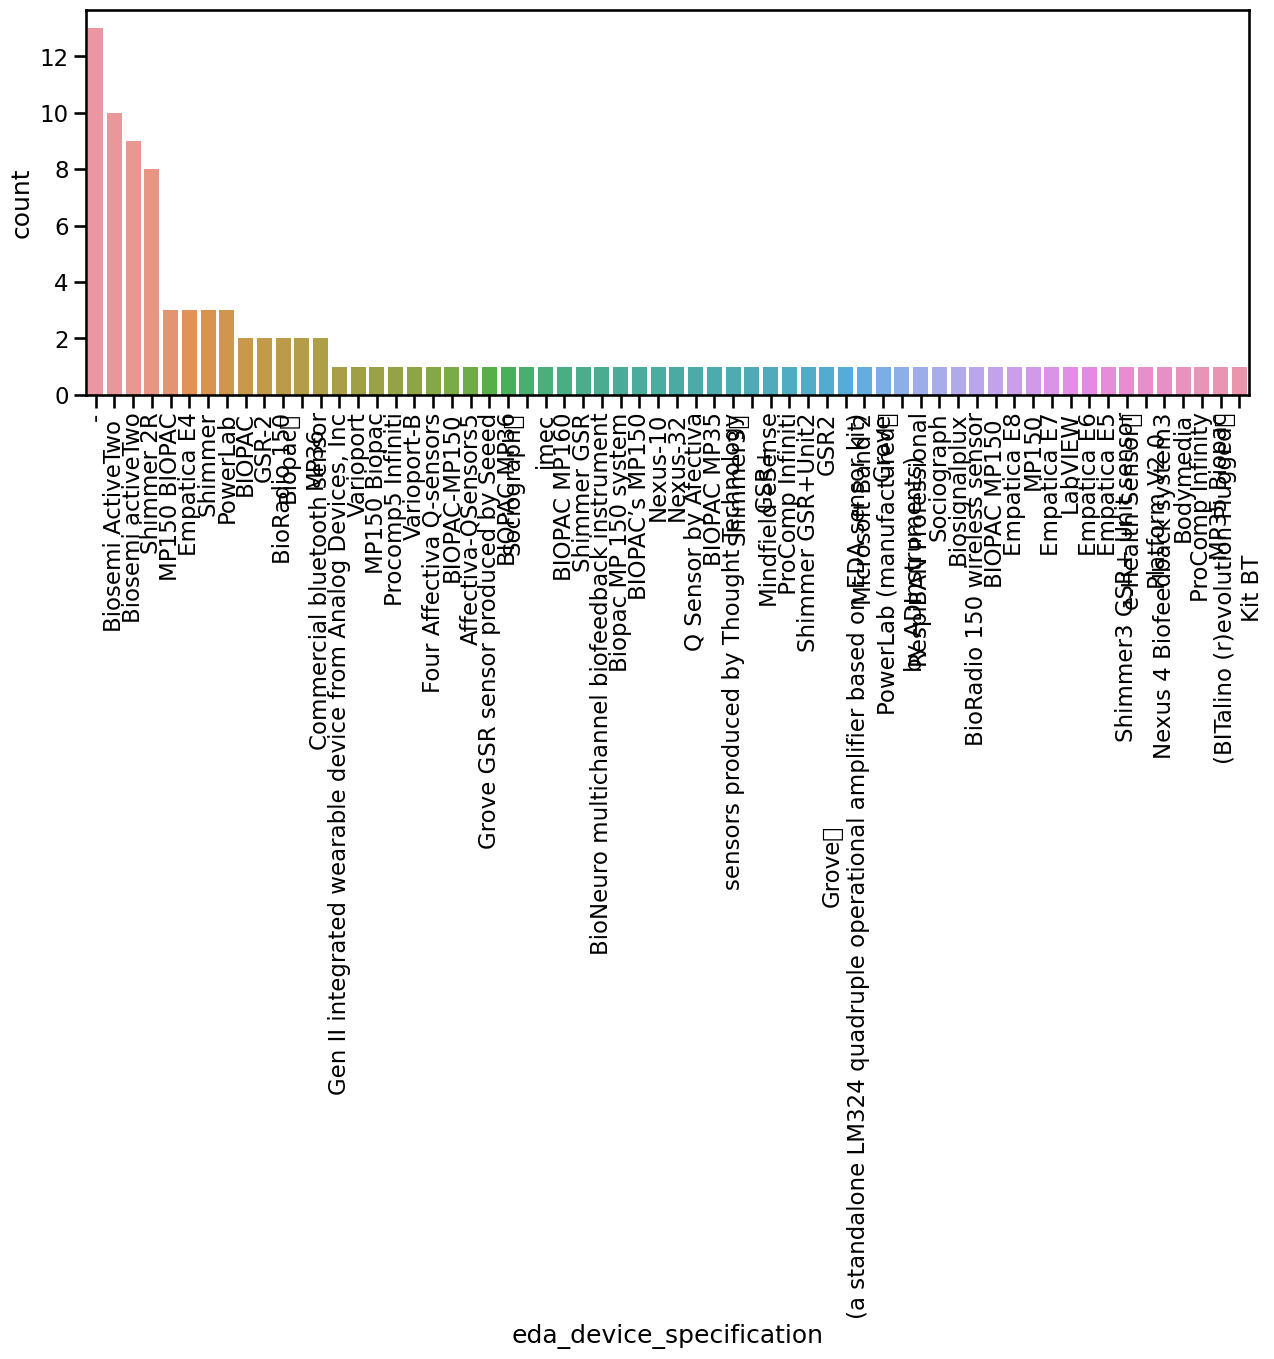

In [146]:
aver["eda_device_specification"].value_counts()
plt.figure(figsize = (15,5))
g = sns.countplot(x="eda_device_specification", data=aver, order = getattr(aver, "eda_device_specification").value_counts().index)
plt.xticks(rotation=90)

#### ¿Cuantos eda devices HOMEMADE hay?

In [147]:
df_eda

paper_id  model_id                                       apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

    eda_device_is_homemade                  eda_device_specification  \
0                      Yes                                         -   
1                        x          e-Health Sensor\r\nPlatform V2.0   
2                        -                        Biosemi ActiveTwo    
3                        -                        Biosemi ActiveTwo    
4                        -                         Biosemi activeTwo   
..                     ...                                       ...   
494                      -               Commercial bluetooth sensor   
495                      -               Commercial bluetooth sensor   
496                      -               Commercial bluetooth sensor   
497                      -  (BITalino (r)evolution Plugged\r\nKit BT   
498                      -  (BITalino (r)evolution Plugged\r\nKit BT   

    location_hemibody is_hands finger_thumb finger_index finger_mIddle  \
0        not dominant        -            -            -             -   
1                   -        x            -            x             x   
2                left        x            -            -             x   
3                left        x            -            -             x   
4                   -        x            -            x             x   
..                ...      ...          ...          ...           ...   
494              left        x            -            x             x   
495              left        x            -            x             x   
496              left        x            -            x             x   
497                 -        -            -            -             -   
498                 -        -            -            -             -   

    finger_ring finger_little phalange_proximal phalange_medial  \
0             -             -                 -               -   
1             -             -                 -               -   
2             x             -                 -               -   
3             x             -                 -               -   
4             -             -                 -               -   
..          ...           ...               ...             ...   
494           -             -                 -               -   
495           -             -                 -               -   
496           -             -                 -               -   
497           -             -                 -               -   
498           -             -                 -               -   

    phalange_distal wrist chest left_lobe_temporalis  
0                 -     x     -                    -  
1                 -     -     -                    -  
2                 -     -     -                    -  
3                 -     -     -                    -  
4                 x     -     -                    -  
..              ...   ...   ...                  ...  
494               -     x     -                    -  
495               -     x     -                    -  
496           

In [148]:
# Filtering the DataFrame to find the APA citations of the papers where 'eda_device_specification' contains 'ariport'
filtered_apa_citations = df_eda[df_eda['eda_device_specification'].str.contains('ariport', case=False)]['apa_citation'].tolist()

filtered_apa_citations

[]

In [149]:
df_eda['eda_device_is_homemade'].value_counts()

eda_device_is_homemade
-           467
No           20
x             5
homemade      5
Yes           2
Name: count, dtype: int64

In [150]:
df_eda['eda_device_is_homemade'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_is_homemade
-           93.6%
No           4.0%
x            1.0%
homemade     1.0%
Yes          0.4%
Name: proportion, dtype: object

In [151]:
eda_devices = eda_devices.groupby(['paper_id', 'eda_device_specification']).nth(0)
eda_devices.reset_index(inplace=True)

In [152]:
eda_devices['eda_device_specification'].value_counts()

eda_device_specification
Biosemi ActiveTwo                           10
Biosemi activeTwo                            9
Shimmer 2R                                   8
Shimmer                                      3
MP150 BIOPAC                                 3
                                            ..
LabVIEW                                      1
Shimmer3 GSR+ Unit sensor                    1
Nexus 4 Biofeedback system3                  1
Bodymedia                                    1
(BITalino (r)evolution Plugged\r\nKit BT     1
Name: count, Length: 61, dtype: int64

In [153]:
# REDUCIMOS LAS CATEGORÍAS AGRUPANDOLAS
main_categories = ['BIOPAC', 'Empatica','GSR2','Sociograph', 'Variport', 'Shimmer', 'BioRadio 150', 'Affectiva-QSensors5','ProComp Infinity','PowerLab', 'Grove']

def reduce_categories(list_categories):
    '''
    esta función toma una lista de categorias y reemplaza por ellas a las rows con categorías similares
    
    ej: reemplaza por BIOPAC a 'BIOPAC 150'

    '''
    for category in list_categories:
        for i in eda_devices.loc[:,'eda_device_specification']:
            if fuzz.ratio(category, i) > 45:
                eda_devices.loc[:,'eda_device_specification'] = eda_devices.loc[:,'eda_device_specification'].replace({i:category})

# Reducimos algunas categorías a partir de la funcion reduce_categories
reduce_categories(main_categories)

# Aún quedan algunas categorias sin unificar asi que unifico las restantes y resuelvo las inconsistencias por diferencias de tipeo o abreviaciones
mapping_eda = {
    'MP150 Biopac': 'BIOPAC', 'MP35 Biopac' : 'BIOPAC','MP150':'BIOPAC','Biopac\r\nMP36' : 'BIOPAC',
    'Biosemi activeTwo' : 'Biosemi ActiveTwo', 'Biosemi ActiveTwo ':'Biosemi ActiveTwo',
    'PowerLab (manufactured\r\nby ADInstruments)': 'PowerLab',
    'Affectiva-QSensors5': 'Q Sensor by Afectiva',
    'Shimmer3 GSR+ Unit sensor':'Shimmer',
    'sensors produced by Thought Technology' : 'Thought Technology',
    'Grove\r\n(a standalone LM324 quadruple operational amplifier based on EDA sensor kit)':'Grove',
    'Grove GSR sensor produced by Seeed':'Grove',
    'Gen II integrated wearable device from Analog Devices, Inc': 'Gen II Analog Devices',
    'e-Health Sensor\nPlatform V2.0' : 'e-Health Sensor Platform V2.0',
    '(BITalino (r)evolution Plugged\r\nKit BT':'(BITalino (r)evolution Plugged Kit BT ',
    'Nexus-10' : 'NEXUS', 'Nexus 4 Biofeedback system3':'NEXUS', #NO ESTOY SEGURO SI ESTO REALMENTE SON LO MISMO, O SIQUIERA SI NEXUS ES LA MARCA
    'Nexus-32' : 'NEXUS'         }


eda_devices.loc[:,'eda_device_specification'] = eda_devices.loc[:,'eda_device_specification'].replace(mapping_eda)

In [154]:
eda_devices['eda_device_specification'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                               19.4%
Shimmer                                         16.3%
BIOPAC                                          16.3%
Empatica                                         7.1%
BioRadio 150                                     4.1%
PowerLab                                         4.1%
Grove                                            3.1%
GSR2                                             3.1%
NEXUS                                            3.1%
ProComp Infinity                                 3.1%
Q Sensor by Afectiva                             3.1%
Variport                                         2.0%
Commercial bluetooth sensor                      2.0%
Sociograph                                       2.0%
Mindfield eSense                                 1.0%
BioNeuro multichannel biofeedback instrument     1.0%
Thought Technology                               1.0%
e-Health Sensor\r\nPlatform V2.0                 1.0%
Bod

In [155]:
#In percentage
#Plot
eda_devices['eda_device_specification'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                               19.4%
Shimmer                                         16.3%
BIOPAC                                          16.3%
Empatica                                         7.1%
BioRadio 150                                     4.1%
PowerLab                                         4.1%
Grove                                            3.1%
GSR2                                             3.1%
NEXUS                                            3.1%
ProComp Infinity                                 3.1%
Q Sensor by Afectiva                             3.1%
Variport                                         2.0%
Commercial bluetooth sensor                      2.0%
Sociograph                                       2.0%
Mindfield eSense                                 1.0%
BioNeuro multichannel biofeedback instrument     1.0%
Thought Technology                               1.0%
e-Health Sensor\r\nPlatform V2.0                 1.0%
Bod

¿Cuantos dipositivos de eda diferentes se utilizaron?

In [156]:
n_dispositivos_eda = eda_devices['eda_device_specification'].nunique()
print (f'Se utilizaron {n_dispositivos_eda} dispositivos de EDA diferentes')

Se utilizaron 25 dispositivos de EDA diferentes


¿En cuántas instancias de nuestro interés se especificó el dispositivo de EDA utilizado?

In [157]:
number_eda = sum(eda_devices['eda_device_specification'].value_counts())
print (f' Tenemos {number_eda} de instancias donde se aclaró el dispositivo de EDA utilizado.')

 Tenemos 98 de instancias donde se aclaró el dispositivo de EDA utilizado.


) missing from current font.da3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


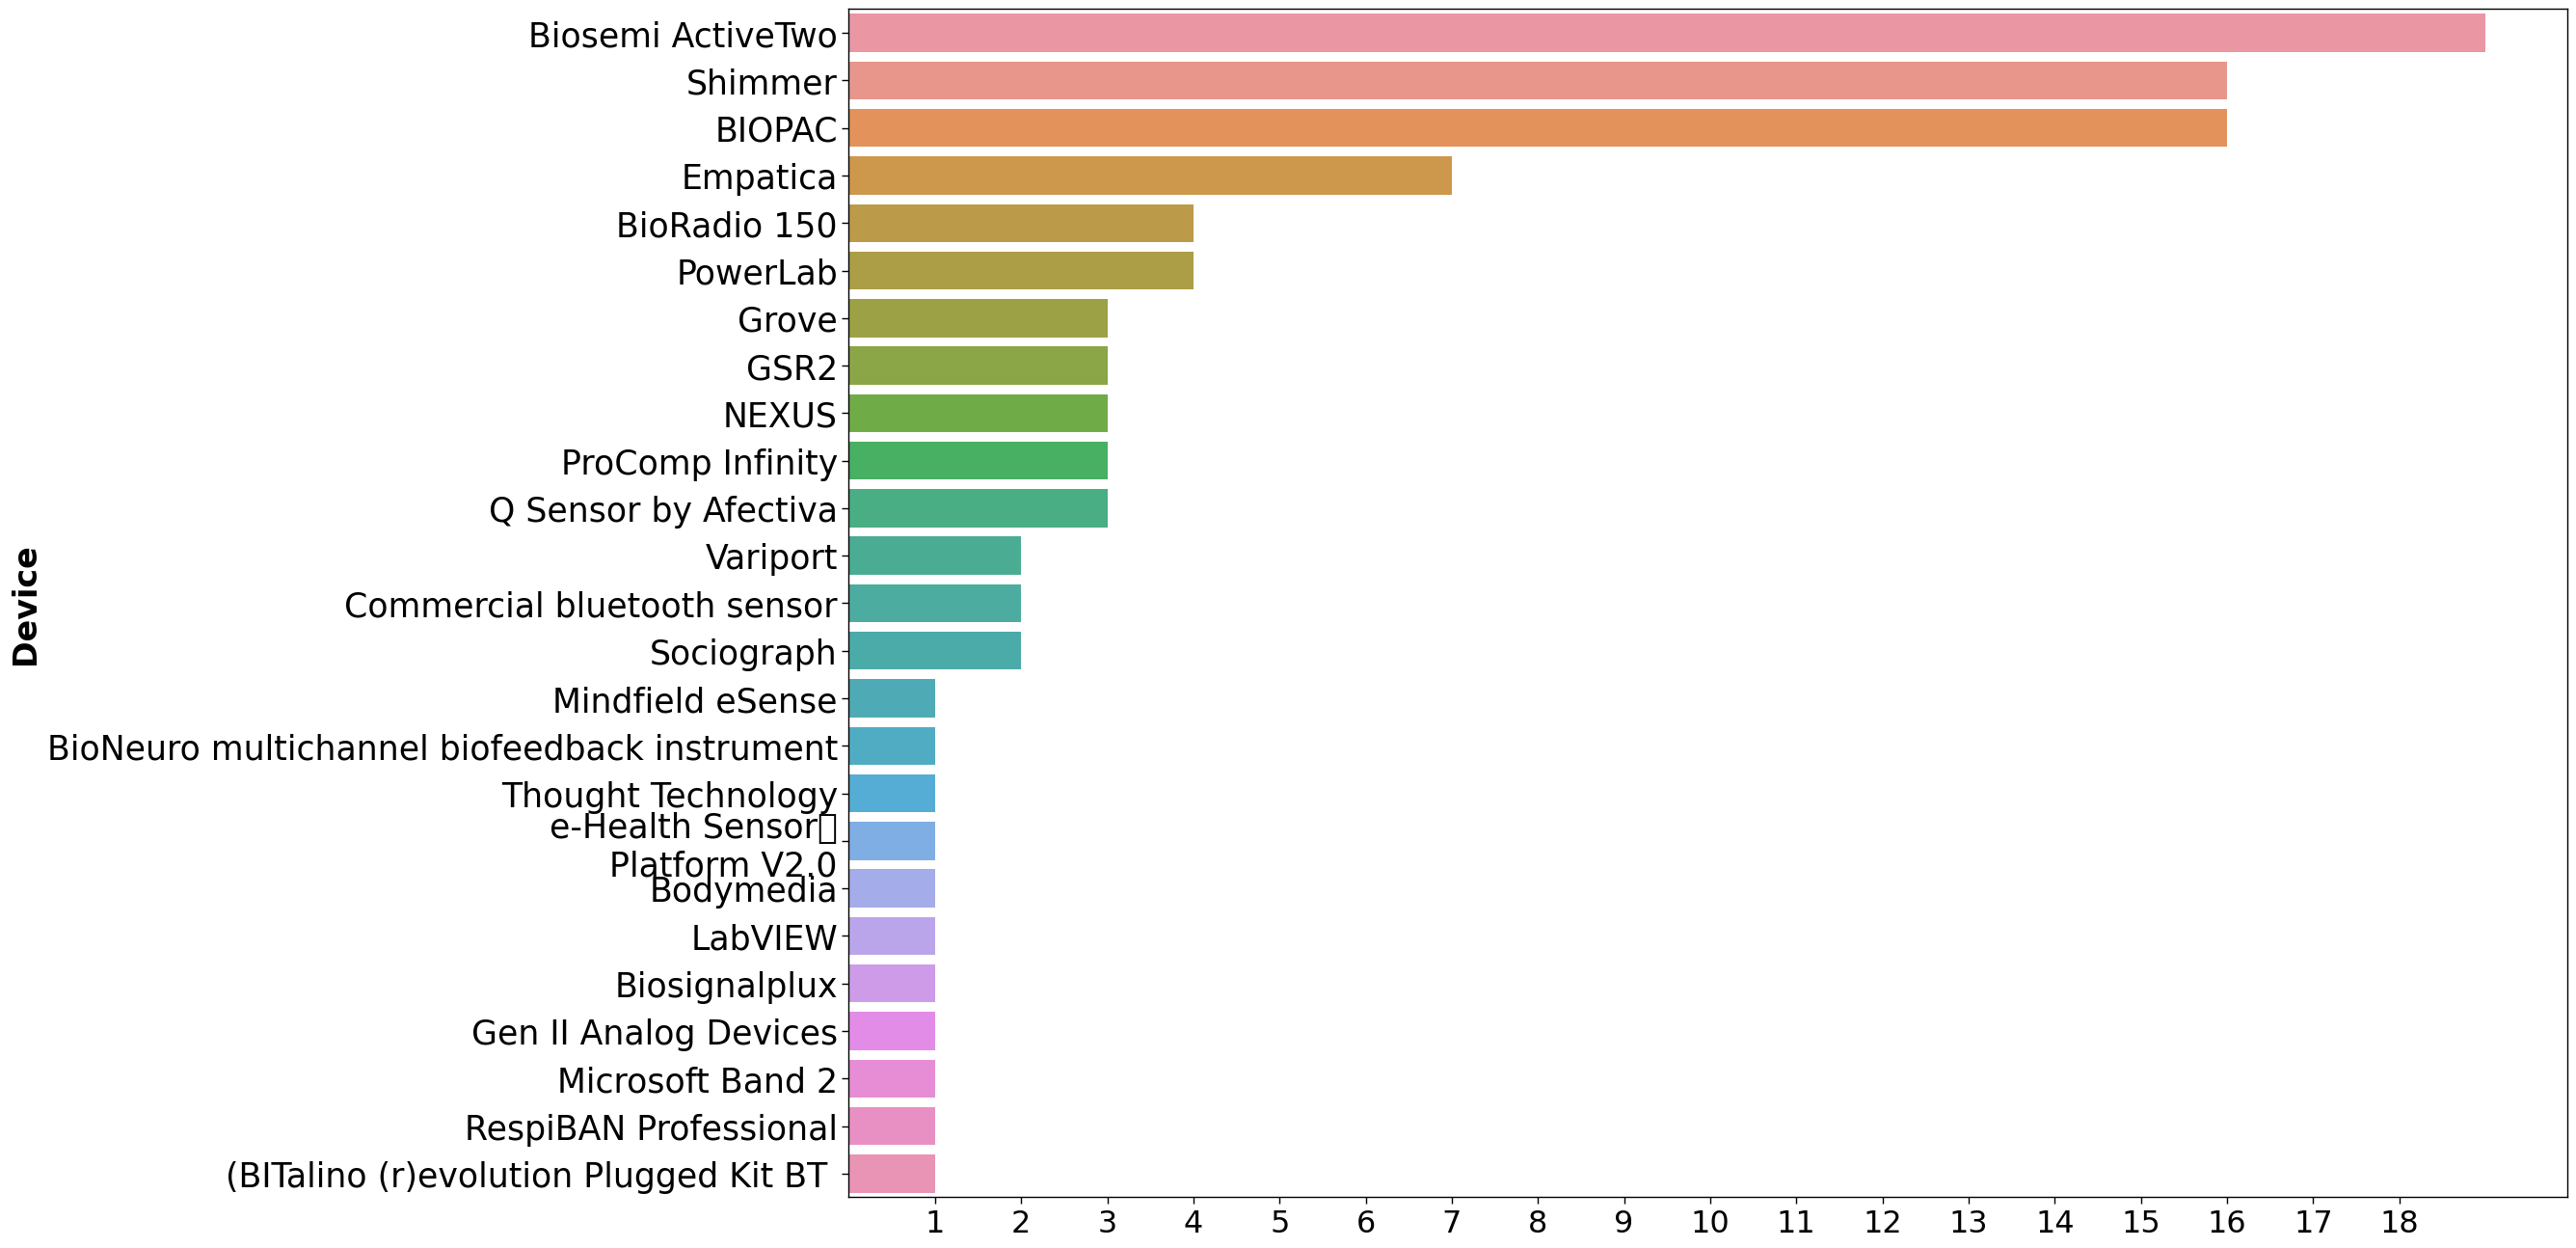

In [158]:
#Plot
from turtle import width


plt.figure(figsize = (23,16))
sns.set_context('paper')
sns.countplot(y = 'eda_device_specification',
            data = eda_devices,
            order = eda_devices['eda_device_specification'].value_counts().index)
plt.ylabel('Device',
            fontsize = 24,
            fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 25)
plt.xticks(ticks = range(1,19), fontsize = 23)
plt.show()

In [159]:
#Aquellos que tenian una frecuencia de 4 o menos los agrupamos en 'Others'
mapping_others ={
        
        'Mindfield eSense': 'Others (<1)',
        'BioNeuro multichannel biofeedback instrument': 'Others (<1)',
        'Thought Technology': 'Others (<1)',
        'e-Health Sensor Platform V2.0': 'Others (<1)',
        'Bodymedia': 'Others (<1)',
        'LabVIEW': 'Others (<1)',
        'Biosignalplux': 'Others (<1)',
        'Gen II Analog Devices': 'Others (<1)',
        'Microsoft Band 2': 'Others (<1)',
        'RespiBAN Professional': 'Others (<1)',
        '(BITalino (r)evolution Plugged Kit BT ': 'Others (<1)'}

devices_with_others = eda_devices.copy()

devices_with_others.loc[:,'eda_device_specification'] = devices_with_others.loc[:,'eda_device_specification'].replace(mapping_others)
devices_with_others['eda_device_specification'].value_counts()

eda_device_specification
Biosemi ActiveTwo                   19
Shimmer                             16
BIOPAC                              16
Others (<1)                         10
Empatica                             7
BioRadio 150                         4
PowerLab                             4
Q Sensor by Afectiva                 3
Grove                                3
NEXUS                                3
ProComp Infinity                     3
GSR2                                 3
Sociograph                           2
Commercial bluetooth sensor          2
Variport                             2
e-Health Sensor\r\nPlatform V2.0     1
Name: count, dtype: int64

In [160]:
devices_with_others

index  paper_id  model_id  \
0       1         2         2   
1       2         3         3   
2       4         4         5   
3       9         5        10   
4      11         6        12   
..    ...       ...       ...   
93    478        94       480   
94    480        95       482   
95    491        97       493   
96    493        98       495   
97    497        99       499   

                                         apa_citation eda_device_is_homemade  \
0   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...                      x   
1   Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...                      -   
2   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....                      -   
3   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....                      -   
4   Feng, H., Golshan, H. M., & Mahoor, M. H. (201...                      -   
..                                                ...                    ...   
93  Yin, G., Sun, S., Zhang, H., Yu, D., Li, C., Z...                      -   
94  Yang, H. C., & Lee, C. C. (2019, September). A...                      -   
95  Ganapathy, N., & Swaminathan, R. (2019). Emoti...                      -   
96  Subramanian, R., Wache, J., Abadi, M. K., Vier...                      -   
97  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...                      -   

            eda_device_specification location_hemibody is_hands finger_thumb  \
0   e-Health Sensor\r\nPlatform V2.0                 -        x            -   
1                  Biosemi ActiveTwo              left        x            -   
2                  Biosemi ActiveTwo                 -        x            -   
3                       BioRadio 150                 -        -            -   
4               Q Sensor by Afectiva                 -        -            -   
..                               ...               ...      ...          ...   
93                            BIOPAC      non-dominant        x            -   
94                           Shimmer              left        x            .   
95                 Biosemi ActiveTwo              left        x            -   
96       Commercial bluetooth sensor              left        x            -   
97                       Others (<1)                 -        -            -   

   finger_index finger_mIddle finger_ring finger_little phalange_proximal  \
0             x             x           -             -                 -   
1             -             x           x             -                 -   
2             x             x           -             -                 -   
3             -             -           -             -                 -   
4             -             -           -             -                 -   
..          ...           ...         ...           ...               ...   
93            -             -           -             -                 -   
94            x             x           -             -                 -   
95            -             x           x             -                 -   
96            x             x           -             -                 -   
97            -             -           -             -                 -   

   phalange_medial phalange_distal wrist chest left_lobe_temporalis  
0                -               -     -     -                    -  
1                -               -     -     -                    -  
2                -               x     -     -                    -  
3                -               -     -     -                    -  
4                -               -     x     -                    -  
..             ...             ...   ...   ...                  ...  
93               -               -     -     -                    -  
94               x               -     -     -                    -  
95               -               -     -     -                    -  
96               -               -     x     -              

In [161]:
devices_with_others['eda_device_specification'].replace('Commercial bluetooth sensor', 'Others (<1)', inplace=True)


## Figure 6

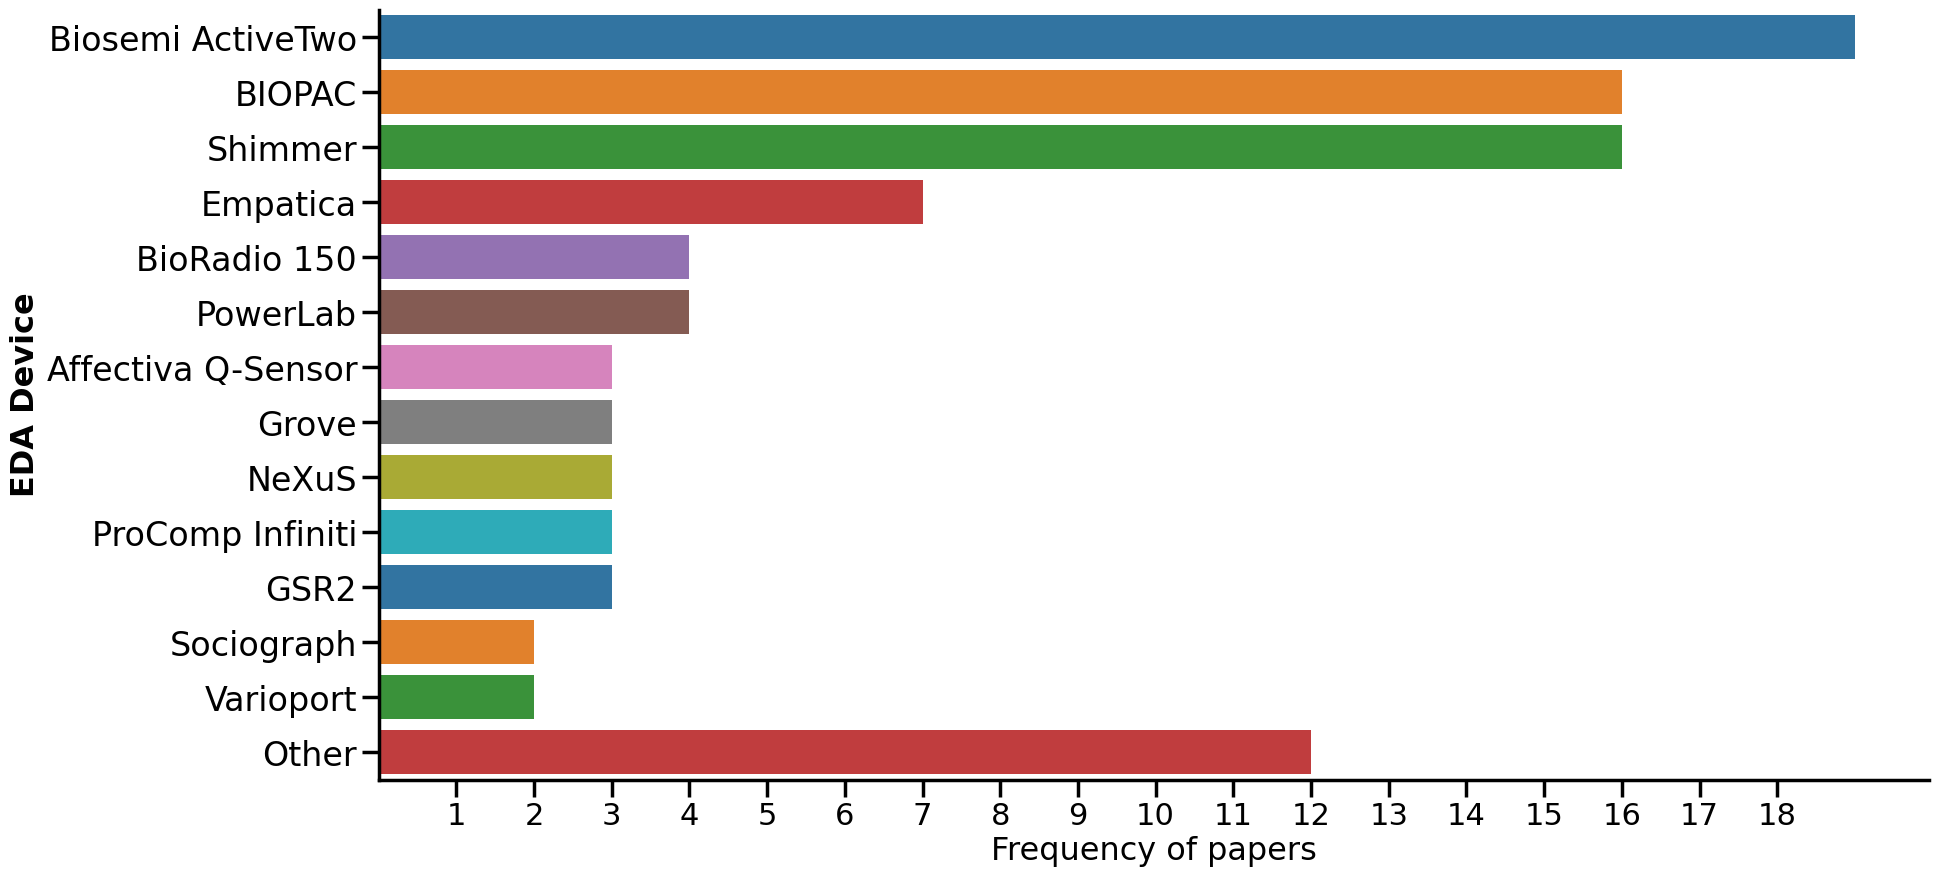

In [357]:
# Set the context for larger fonts
sns.set_context('poster')

name_changes = {
    "Q Sensor by Afectiva": "Affectiva Q-Sensor",
    "NEXUS": "NeXuS",
    "ProComp Infinity": "ProComp Infiniti",
    "Variport": "Varioport"
}

# Update name changes in DataFrame
devices_with_others['eda_device_specification'].replace(name_changes, inplace=True)

# Update the name in DataFrame
devices_with_others['eda_device_specification'].replace({'Others (<1)': 'Other'}, inplace=True)

# Update the plot_order list
plot_order = ['Biosemi ActiveTwo','BIOPAC', 'Shimmer', 'Empatica','BioRadio 150', 'PowerLab', 'Affectiva Q-Sensor' , 'Grove','NeXuS','ProComp Infiniti', 'GSR2','Sociograph', 'Varioport', 'Other']

#Plot
plt.figure(figsize = (20,10))
sns.countplot(y = 'eda_device_specification',
              data = devices_with_others,
              order = plot_order,
              palette = "tab10")
plt.ylabel('EDA Device', fontsize = 23, fontweight = 'bold')
plt.xlabel('Frequency of papers', fontsize = 23)
plt.yticks(fontsize = 24)
plt.xticks(ticks = range(1, 19), fontsize = 22)

sns.despine()

plt.show()



In [164]:
devices_with_others["eda_device_specification"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                   19.4%
Shimmer                             16.3%
BIOPAC                              16.3%
Other                               12.2%
Empatica                             7.1%
BioRadio 150                         4.1%
PowerLab                             4.1%
Affectiva Q-Sensor                   3.1%
Grove                                3.1%
NeXuS                                3.1%
ProComp Infiniti                     3.1%
GSR2                                 3.1%
Sociograph                           2.0%
Varioport                            2.0%
e-Health Sensor\r\nPlatform V2.0     1.0%
Name: proportion, dtype: object

In [188]:
df_eda['location_hemibody'] = df_eda['location_hemibody'].replace({'non-dominant': 'not dominant'})

In [189]:
hemibody = df_eda.groupby(['paper_id', 'location_hemibody']).nth(0)
hemibody.reset_index(inplace=True)
hemibody['location_hemibody'].value_counts()

location_hemibody
-               65
left            23
not dominant    10
right            3
dominant         1
Name: count, dtype: int64

In [191]:
sum(hemibody['location_hemibody'].value_counts())

102

In [192]:
hemibody['location_hemibody'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

location_hemibody
-               63.7%
left            22.5%
not dominant     9.8%
right            2.9%
dominant         1.0%
Name: proportion, dtype: object

In [193]:
hemibody_only_reported = hemibody[hemibody['location_hemibody'] != "-"]
hemibody_only_reported['location_hemibody'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

location_hemibody
left            62.2%
not dominant    27.0%
right            8.1%
dominant         2.7%
Name: proportion, dtype: object

In [194]:
sensors = df_eda.groupby(['paper_id','is_hands','wrist', 'chest', 'left_lobe_temporalis',
                    'finger_thumb', 'finger_index', 'finger_mIddle', 'finger_ring', 'finger_little',
                     'phalange_proximal', 'phalange_medial','phalange_distal',
                     ]).nth(0)
sensors.reset_index(inplace= True)

In [195]:
sensors_location = df_eda.groupby(['paper_id','is_hands','wrist', 'chest', 'left_lobe_temporalis']).nth(0)
sensors_location.reset_index(inplace = True)

PAPERS WITH NO DATA RELATED TO SENSORS LOCATION

In [196]:
len(sensors[(sensors['is_hands'] == '-') &
            (sensors['wrist'] == '-') &
            (sensors['chest'] == '-') &
            (sensors['left_lobe_temporalis'] == '-')])

27

In [197]:
general_place = fn.multi_reversing(sensors, 'model_id',sensors[['is_hands','wrist', 'chest', 'left_lobe_temporalis']])
general_place['variable'].value_counts()

variable
is_hands    68
wrist       13
chest        1
Name: count, dtype: int64

In [198]:
general_place['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
is_hands    82.9%
wrist       15.9%
chest        1.2%
Name: proportion, dtype: object

In [199]:
finger_sensor = fn.multi_reversing(sensors, 'model_id',sensors[['finger_thumb', 'finger_index', 'finger_mIddle', 'finger_ring', 'finger_little']])
finger_sensor['variable'].value_counts()

variable
finger_mIddle    52
finger_index     43
finger_ring      22
finger_little     2
finger_thumb      1
Name: count, dtype: int64

In [200]:
finger_sensor['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
finger_mIddle    43.3%
finger_index     35.8%
finger_ring      18.3%
finger_little     1.7%
finger_thumb      0.8%
Name: proportion, dtype: object

In [201]:
location_phalanges = fn.multi_reversing(sensors, 'model_id',sensors[['phalange_proximal', 'phalange_medial','phalange_distal']])
location_phalanges['variable'].value_counts()

variable
phalange_distal      21
phalange_medial      11
phalange_proximal     2
Name: count, dtype: int64

In [202]:
finger_sensor['variable'].value_counts()

variable
finger_mIddle    52
finger_index     43
finger_ring      22
finger_little     2
finger_thumb      1
Name: count, dtype: int64

In [203]:
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_mIddle','Middle')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_index','Index')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_ring','Ring')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_thumb','Thumb')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_little','Little')

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticklabels())


"ax1.legend(title='Modelo afectivo', loc='upper left')\nax2.legend(title='Tipo de algoritmo', loc='upper left')"

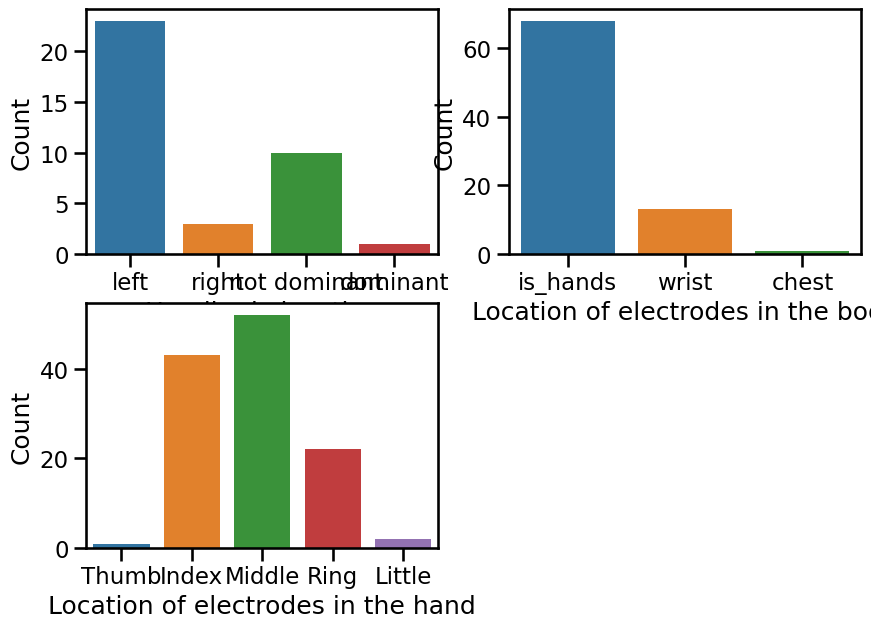

In [204]:
fig, axes = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)
plot_order = ['left', 'right', 'not dominant', 'dominant']
ax1 = sns.countplot(x = 'location_hemibody',
    data = hemibody,
    order = plot_order,
    ax=axes[0,0])

ax2 = sns.countplot(x = 'variable', data = general_place,
    ax=axes[0,1])

ax3 = sns.countplot(x = 'variable', data = finger_sensor,
    ax=axes[1,0])

fig.delaxes(axes[1,1])

"""ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])"""

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax3.set_yticklabels(ax3.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())
ax3.set_xticklabels(ax3.get_xticklabels())

ax1.set_xlabel("Hemibody location")
ax1.set_ylabel("Count")
ax2.set_xlabel("Location of electrodes in the body")
ax2.set_ylabel("Count")
ax3.set_xlabel("Location of electrodes in the hand")
ax3.set_ylabel("Count")

"""ax1.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional")
ax2.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de algoritmo")"""

"""ax1.legend(title='Modelo afectivo', loc='upper left')
ax2.legend(title='Tipo de algoritmo', loc='upper left')"""

## Figure 7

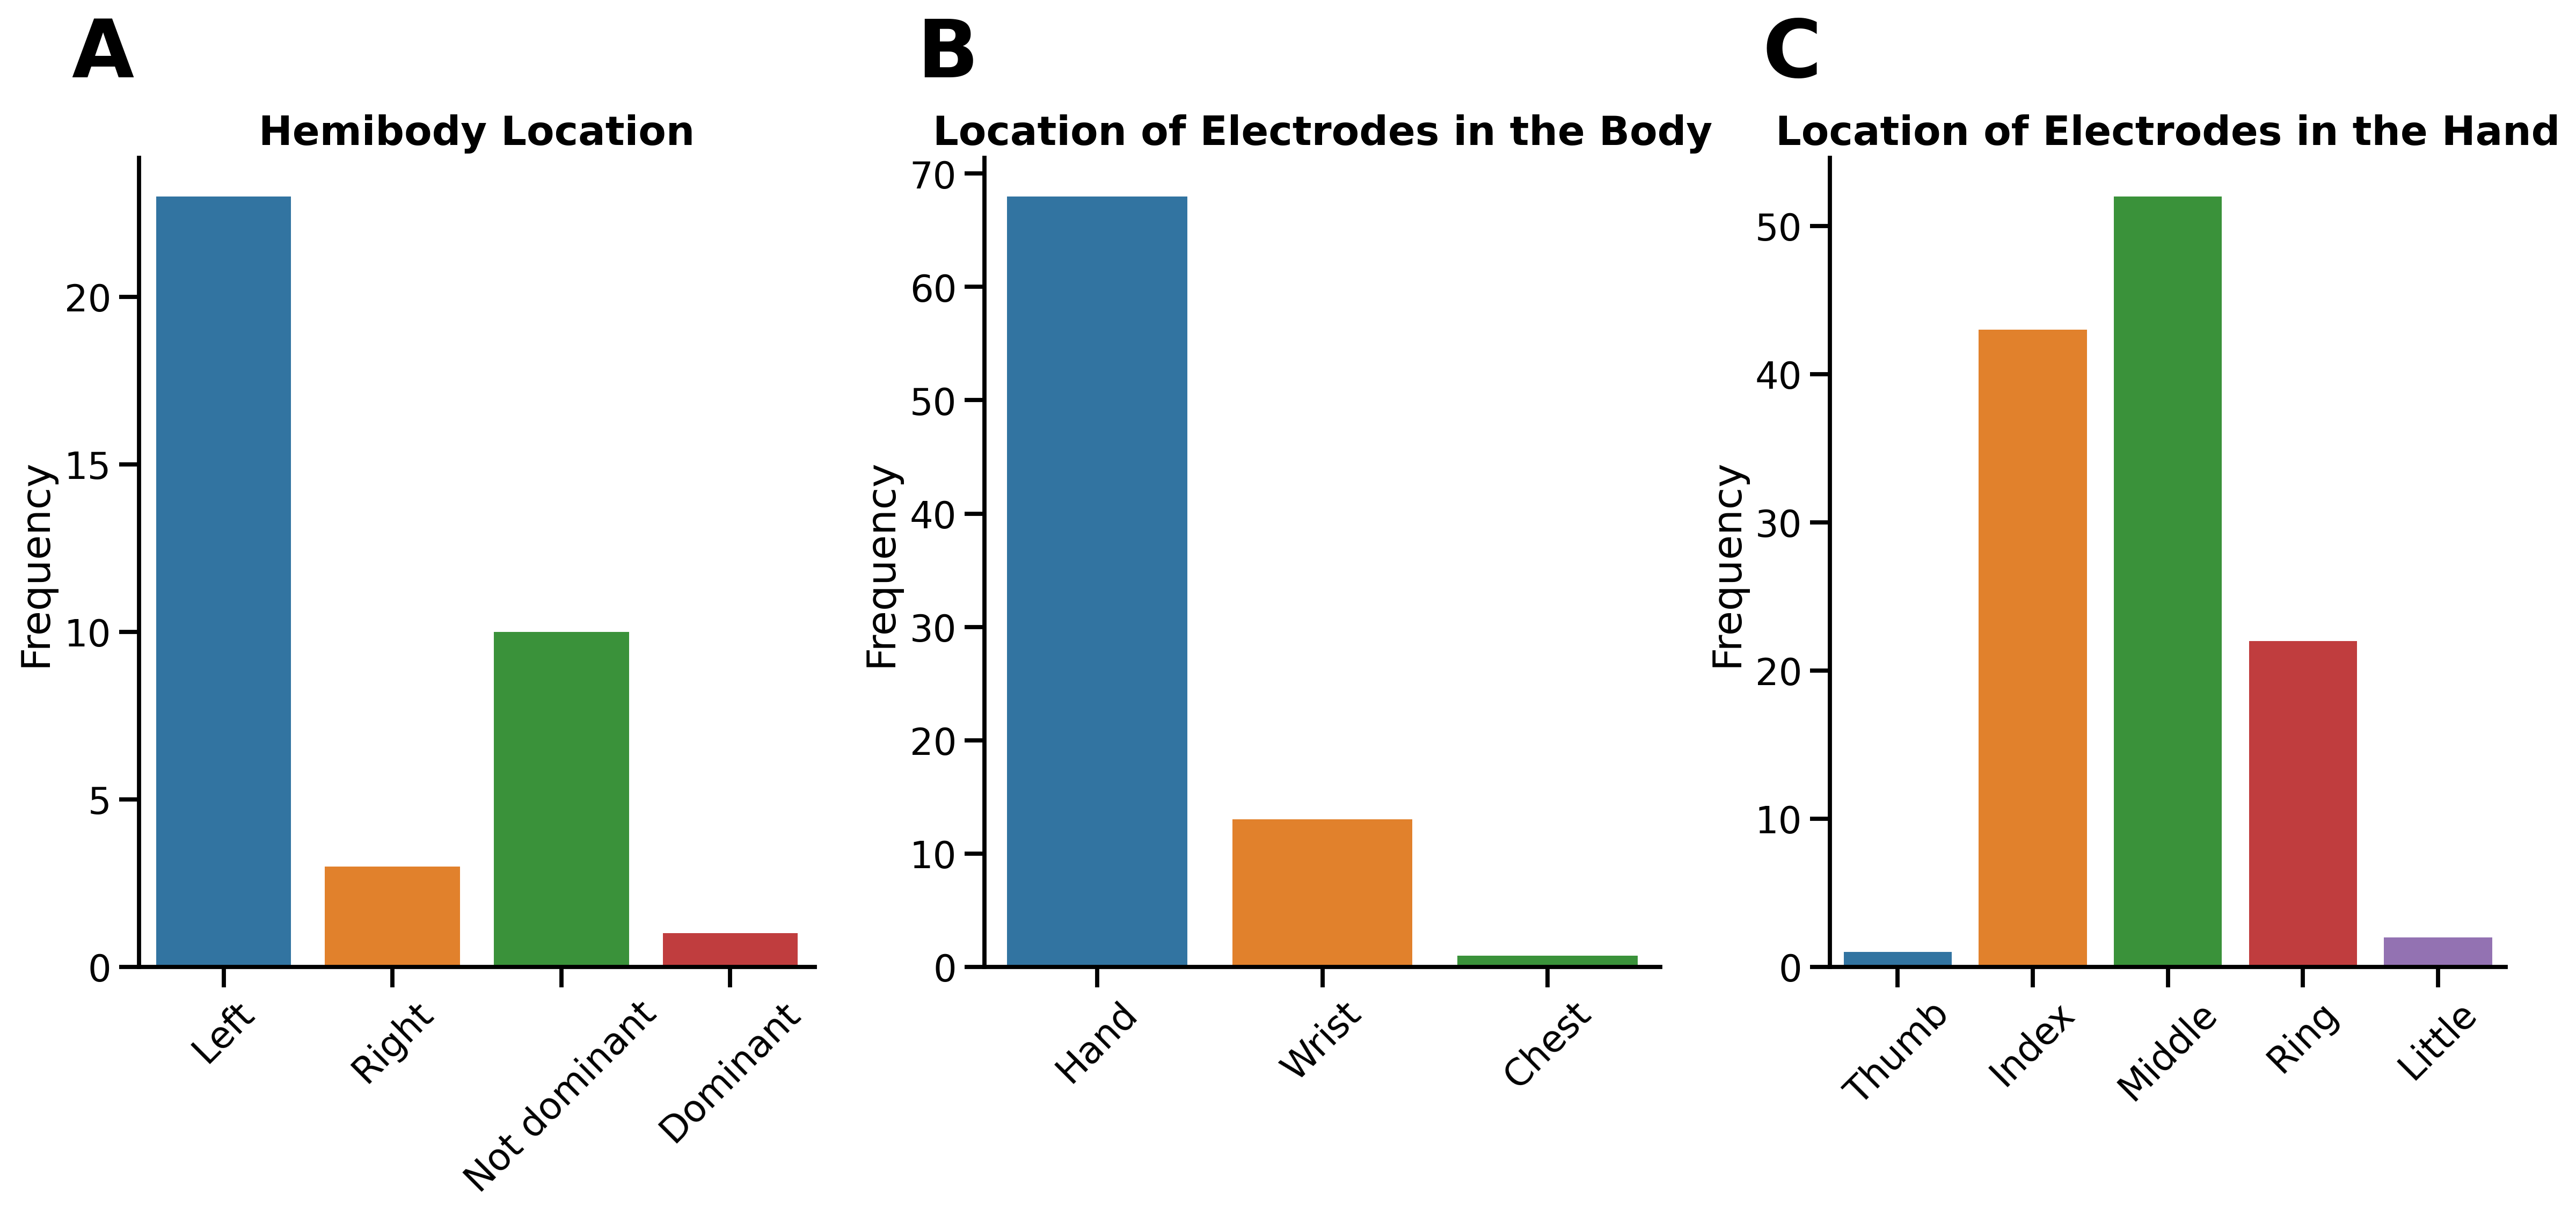

In [358]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

# Set the context for even bigger fonts
sns.set_context("talk")

# Create figure with custom GridSpec
fig = plt.figure(figsize=(16, 8), dpi=300)
gs = gridspec.GridSpec(1, 3)

# Data (dummy data for the example)
# hemibody, general_place, and finger_sensor should be defined


new_labels_ax1 = ['Left', 'Right', 'Not dominant', 'Dominant']
new_labels_ax2 = ['Hand', 'Wrist', 'Chest']



# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
plot_order = ['left', 'right', 'not dominant', 'dominant']
sns.countplot(x='location_hemibody', data=hemibody, order=plot_order, ax=ax1, palette="tab10")
ax1.set_title('Hemibody Location', fontweight='bold')
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(new_labels_ax1, rotation=45)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
ax1.set_xlabel('')
sns.despine(ax=ax1)




# SUBPLOT B
ax2 = plt.subplot(gs[0, 1])
sns.countplot(x='variable', data=general_place, ax=ax2, palette="tab10")
ax2.set_title('Location of Electrodes in the Body', fontweight='bold')
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(new_labels_ax2, rotation=45)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
ax2.set_xlabel('')
sns.despine(ax=ax2)

# SUBPLOT C
ax3 = plt.subplot(gs[0, 2])
sns.countplot(x='variable', data=finger_sensor, ax=ax3, palette="tab10")
ax3.set_title('Location of Electrodes in the Hand', fontweight='bold')
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=36, fontweight='bold')
ax3.set_xlabel('')
sns.despine(ax=ax3)

# Tight layout and show
plt.tight_layout()
plt.show()




### 7. Statistical learning models

In [230]:
df_statistical_learning_models = df_alg_perf.fillna('-')

#### 7.1. Affective models

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de papers')]

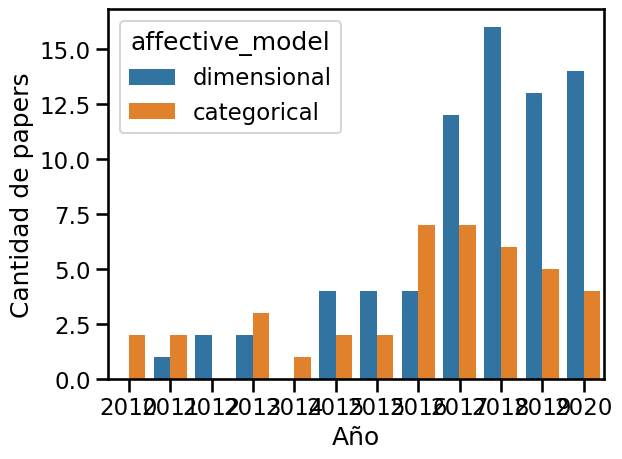

In [231]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_statistical_learning_models_0, 
    hue='affective_model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de papers')

In [232]:
df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)
df_statistical_learning_models_0

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\125309588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)


index  paper_id  model_id  \
0        0         1         1   
1        1         2         2   
2        2         3         3   
3        4         4         5   
4        9         5        10   
..     ...       ...       ...   
102    480        95       482   
103    490        96       492   
104    491        97       493   
105    493        98       495   
106    497        99       499   

                                          apa_citation  year affective_model  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  2017     dimensional   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  2016     categorical   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018     dimensional   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  2018     dimensional   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016     dimensional   
..                                                 ...   ...             ...   
102  Yang, H. C., & Lee, C. C. (2019, September). A...  2020     dimensional   
103  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020     dimensional   
104  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  2020     dimensional   
105  Subramanian, R., Wache, J., Abadi, M. K., Vier...  2018     dimensional   
106  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  2019     dimensional   

    is_classifier class_model_output_number  \
0               x                         2   
1               x                         5   
2               x                         2   
3               x                         4   
4               -                         -   
..            ...                       ...   
102             x                         2   
103             x                         2   
104             x                         2   
105             x                         2   
106             x                         4   

           class_model_output_categories class_logistic_regression  ...  \
0                         calm, distress                         -  ...   
1    Happiness, Grief, Fear, Anger, Calm                         -  ...   
2                                 LA, HA                         -  ...   
3                 HAHV, HALV, LAHV, LALV                         -  ...   
4                                      -                         -  ...   
..                                   ...                       ...  ...   
102                               HA, LA                         -  ...   
103                               HA, LA                         -  ...   
104                               HA, LA                         -  ...   
105                               HV, LV                         -  ...   
106               HAHV, HALV, LAHV, LALV                         -  ...   

    mean_absolute_error concordance_correlation_coefficient  \
0                     -                                   -   
1                     -                                   -   
2                     -                                   -   
3                     -                                   -   
4                     -                                   -   
..                  ...                                 ...   
102                   -                                   -   
103                   -                                   -   
104                   -                                   -   
105                   -                                   -   
106                   -                                   -   

    spearmans_ranking_correlation mean_square_error root_mean_square_error  \
0                               -                 -                      -   
1                               -                 -                      -   
2                               -                 -                      -   
3                               -                 -                      -   
4                     

#### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos de regresion y categoriales empleados?
Cantidad de modelos de regresion o categorial por anio

2. Hacer un plot de la progresión de modelos de regresión vs clasificación de 2010 a 2020. Este plot deberia ser igual al plot que ve la progresion de modelos dimensioanles vs categoriales. La idea con este plot seria analizar sin la progresion de papers basados en modelos dimensioanels se acompaña con modelso estadísticos de regresion (que es lo que se esperaria dado el tipo de variable, pero asumimos que no sucede)

In [233]:
df_statistical_learning_models=df_statistical_learning_models.fillna('-')

In [234]:
df_statistical_learning_models["is_regressor"].value_counts()

is_regressor
-    448
x     51
Name: count, dtype: int64

In [235]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [236]:
df_statistical_learning_models['model']  = df_statistical_learning_models.apply(lambda row: label_model(row), axis=1)

In [237]:
df_statistical_learning_models['model'].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [238]:
df_models = df_statistical_learning_models[["apa_citation",'model', "year", "model_id"]]

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de modelos')]

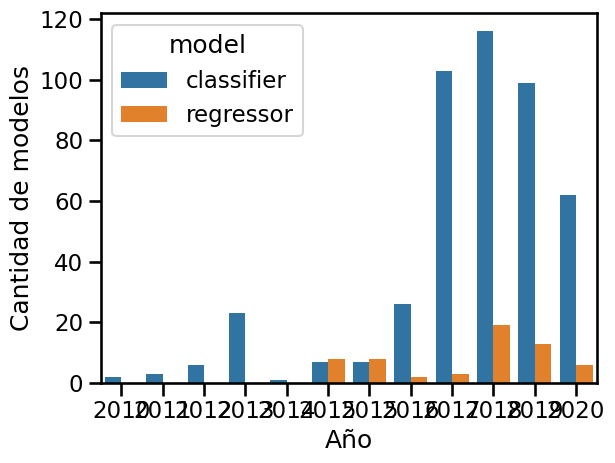

In [239]:
#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de modelos')

#### ¿Cual es la frecuencia del uso de modelos algoritmicos de regresion y clasificacion?
3. Gráficos frencuencia de los modelos algoritimicos, según modelos de regresión y clasificación

- Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?
- Nota: ordenar los valores de los gráficos y unirlos en uno, buscar graficar los mas usados (primeros 5 o 10) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'decision_tree'),
  Text(1, 0, 'linear_regression'),
  Text(2, 0, 'support_vector_regression'),
  Text(3, 0, 'knn'),
  Text(4, 0, 'convolutional_neuronal_network'),
  Text(5, 0, 'recurrent_neuronal_network'),
  Text(6, 0, 'fully_connected_neuronal_network_or_multi_layer_perceptron'),
  Text(7, 0, 'ridge_regression'),
  Text(8, 0, 'logistic_regression'),
  Text(9, 0, 'multilayer_regression'),
  Text(10, 0, 'boosted_regression_trees'),
  Text(11, 0, 'polynomial_regression')])

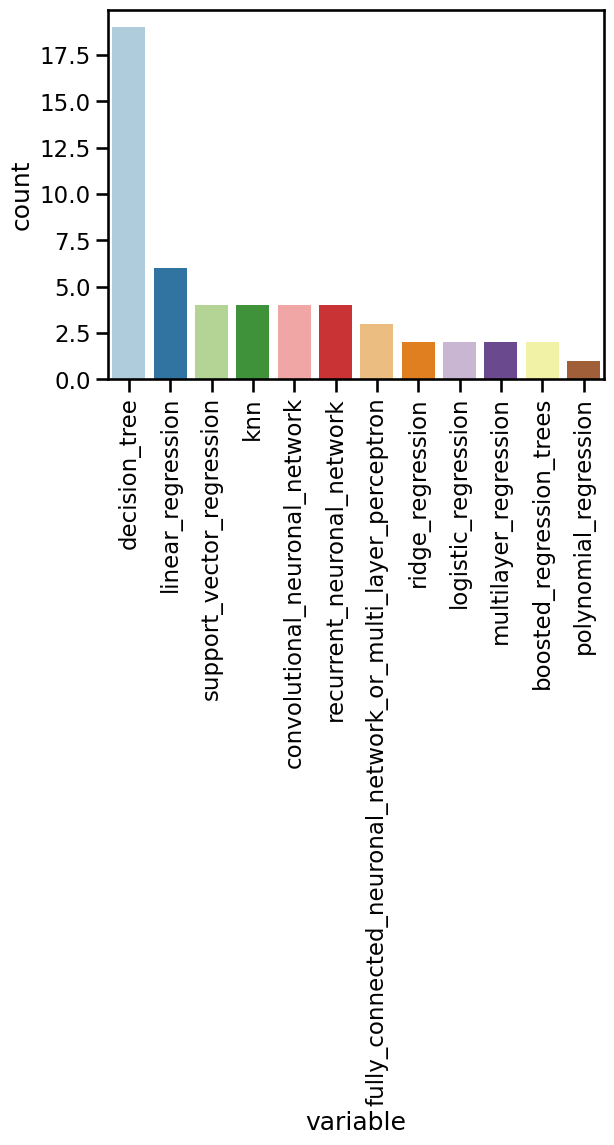

In [240]:
#para regressor
df_algoritmos_regre = fn.multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,43:57])
df_algoritmos_regre['variable'] = df_algoritmos_regre['variable'].str.replace('regre_','')

sns.countplot(x='variable', data=df_algoritmos_regre, order = getattr(df_algoritmos_regre, 'variable').value_counts().index, palette="Paired")
plt.xticks(rotation=90)

c:\Users\dameliotomas\review-emotion-recognition-eda\scripts\functions.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


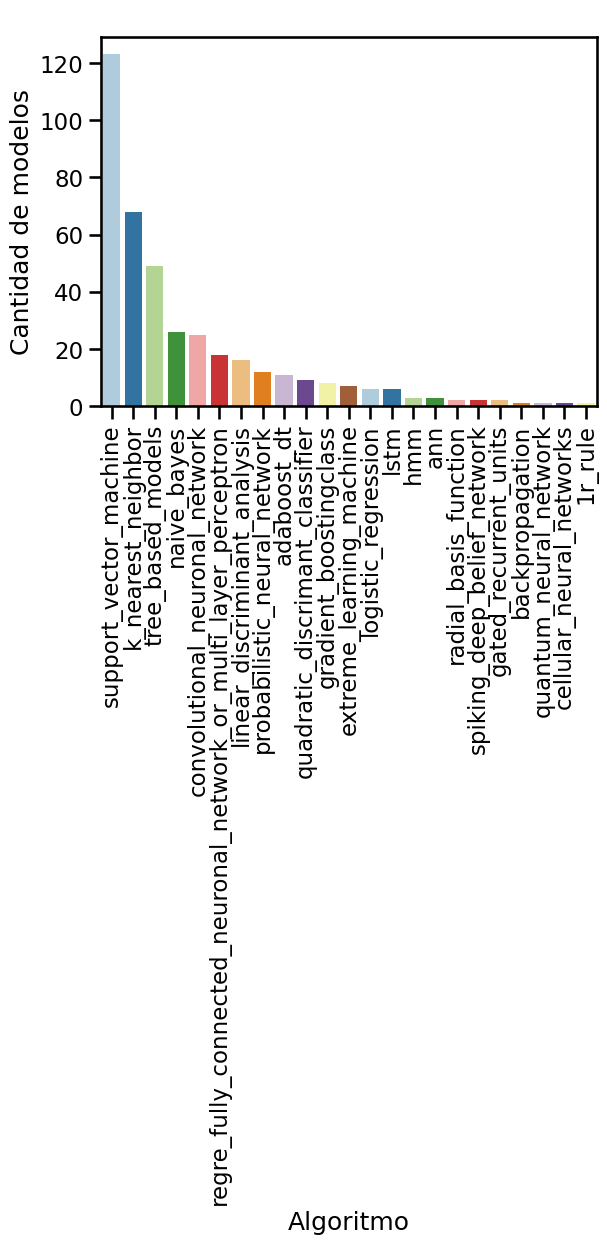

In [241]:
#para classifier

df_algoritmos_class = fn.multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,8:40])
df_algoritmos_class['variable'] = df_algoritmos_class['variable'].str.replace('class_','')

#Lista de algoritmos unicos de clasificacion
algoritmos_de_clasificacion = df_algoritmos_class["variable"].unique()
#print(algoritmos_de_clasificacion)

titulos = [' ', 'Algoritmo', 'Cantidad de modelos']
fn.bar_plot('variable',df_algoritmos_class,titulos)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'support_vector_machine'),
  Text(1, 0, 'k_nearest_neighbor'),
  Text(2, 0, 'tree_based_models'),
  Text(3, 0, 'convolutional_neuronal_network'),
  Text(4, 0, 'naive_bayes'),
  Text(5, 0, 'fully_connected_neuronal_network_or_multi_layer_perceptron'),
  Text(6, 0, 'decision_tree'),
  Text(7, 0, 'linear_discriminant_analysis'),
  Text(8, 0, 'probabilistic_neural_network'),
  Text(9, 0, 'adaboost_dt'),
  Text(10, 0, 'quadratic_discrimant_classifier'),
  Text(11, 0, 'logistic_regression'),
  Text(12, 0, 'gradient_boostingclass'),
  Text(13, 0, 'extreme_learning_machine'),
  Text(14, 0, 'lstm'),
  Text(15, 0, 'linear_regression'),
  Text(16, 0, 'knn'),
  Text(17, 0, 'support_vector_regression'),
  Text(18, 0, 'recurrent_neuronal_network'),
  Text(19, 0, 'ann'),
  Text(20, 0, 'hmm'),
  Text(21, 0, 'spiking_deep_belief_network'),
  Text

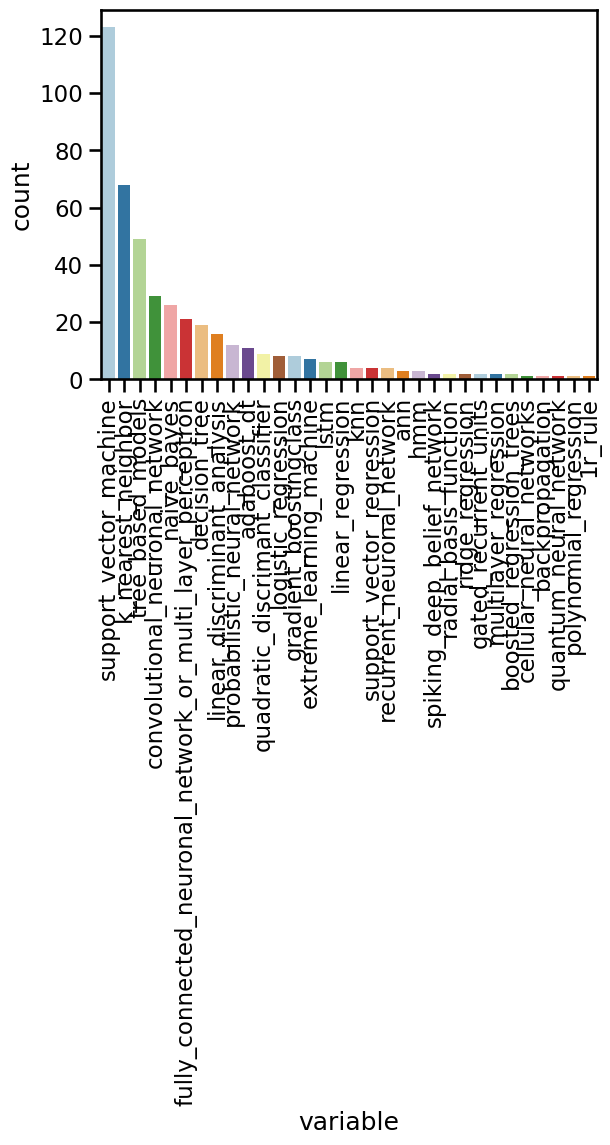

In [242]:
df_all_models = df_statistical_learning_models.iloc[:,1:57]
df_all_models.drop(df_all_models.columns[[1,2,3,4,5,6,39,40,41]], axis=1, inplace=True)

df_all_models = fn.multi_reversing(df_all_models, 'model_id', df_all_models.iloc[:,1:])
df_all_models['variable'] = df_all_models['variable'].str.replace('class_','')
df_all_models['variable'] = df_all_models['variable'].str.replace('regre_','')

sns.countplot(x='variable', data=df_all_models, order = getattr(df_all_models, 'variable').value_counts().index, palette="Paired")
plt.xticks(rotation=90)

In [243]:
vc = df_all_models['variable'].value_counts()
vc = vc.iloc[:10]
df_dv = vc.to_frame()
df_dv = df_dv.reset_index()
df_dv.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

titulos = [' ', 'Algoritmo', 'Cantidad de modelos']
g = sns.barplot(data=df_dv, x='algoritmo', y='cantidad', palette="Paired")
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)

ValueError: Could not interpret input 'algoritmo'

### 8. Algorithms and performances

#### Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional y tipo de algoritmo

In [254]:
df_models = df_statistical_learning_models[["paper_id","apa_citation",'model', "year", "model_id"]]

df_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
df_models.reset_index(inplace=True)

In [255]:
"""df_statistical_learning_models['affective_model'] = df_statistical_learning_models['affective_model'].str.replace('categorical','categorial')"""

"df_statistical_learning_models['affective_model'] = df_statistical_learning_models['affective_model'].str.replace('categorical','categorial')"

In [256]:
models = df_statistical_learning_models[["paper_id", "year", "affective_model", "model_id"]]

models = models.groupby(
        ["paper_id",'affective_model']
        ).nth(0)
models.reset_index(inplace=True)

models["year"] = models["year"].astype(int)

In [257]:
models["affective_model"].value_counts()

affective_model
dimensional    68
categorical    39
Name: count, dtype: int64

In [258]:
models_crosstab = pd.crosstab(index=models['year'], columns=models['affective_model'],normalize='index')

In [259]:
"""df_models['model'] = df_models['model'].str.replace('classifier','clasificación')
df_models['model'] = df_models['model'].str.replace('regressor','regresión')"""

"df_models['model'] = df_models['model'].str.replace('classifier','clasificación')\ndf_models['model'] = df_models['model'].str.replace('regressor','regresión')"

In [260]:
n_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
n_models.reset_index(inplace=True)

n_models["year"] = n_models["year"].astype(int)

In [261]:
n_models_crosstab = pd.crosstab(index=n_models['year'], columns=n_models['model'],normalize='index')

## Figure 8

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3573763391.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3573763391.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


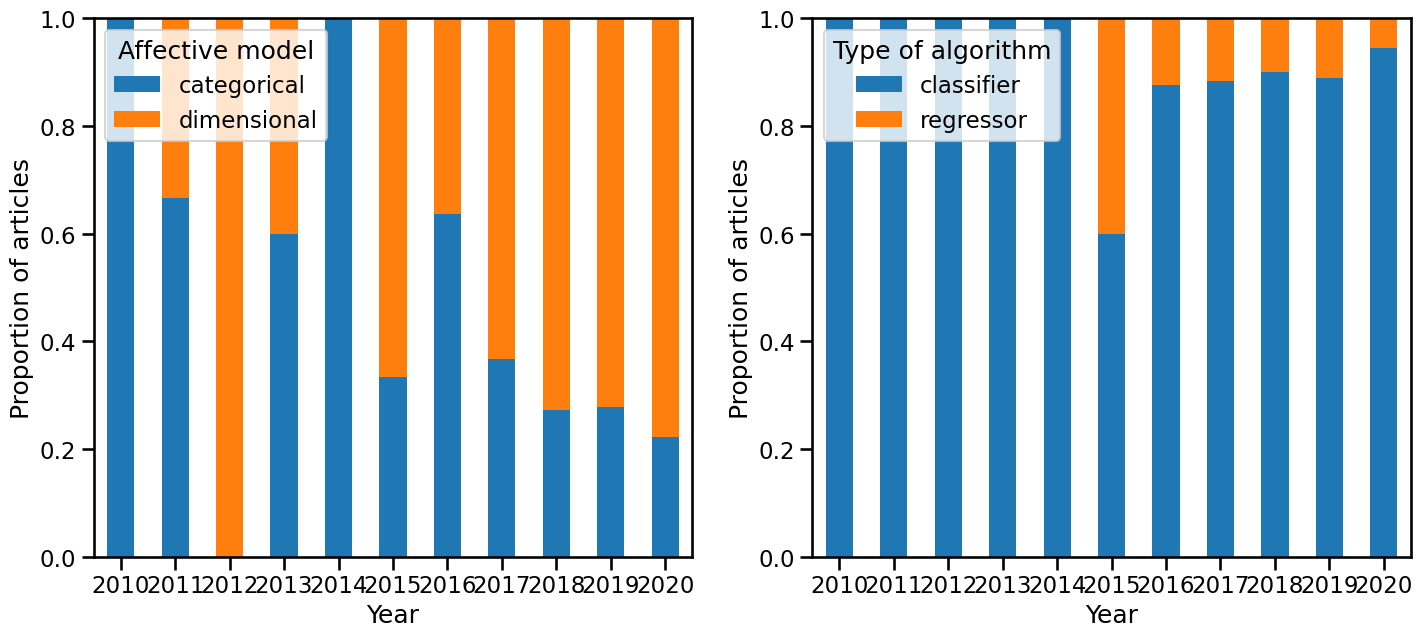

In [359]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(17)

ax1 = models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[0])

ax2 = n_models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[1])

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of articles")
ax2.set_xlabel("Year")
ax2.set_ylabel("Proportion of articles")

"""ax1.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional")
ax2.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de algoritmo")"""

ax1.legend(title='Affective model', loc='upper left')
ax2.legend(title='Type of algorithm', loc='upper left')

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\1111829687.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\1111829687.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


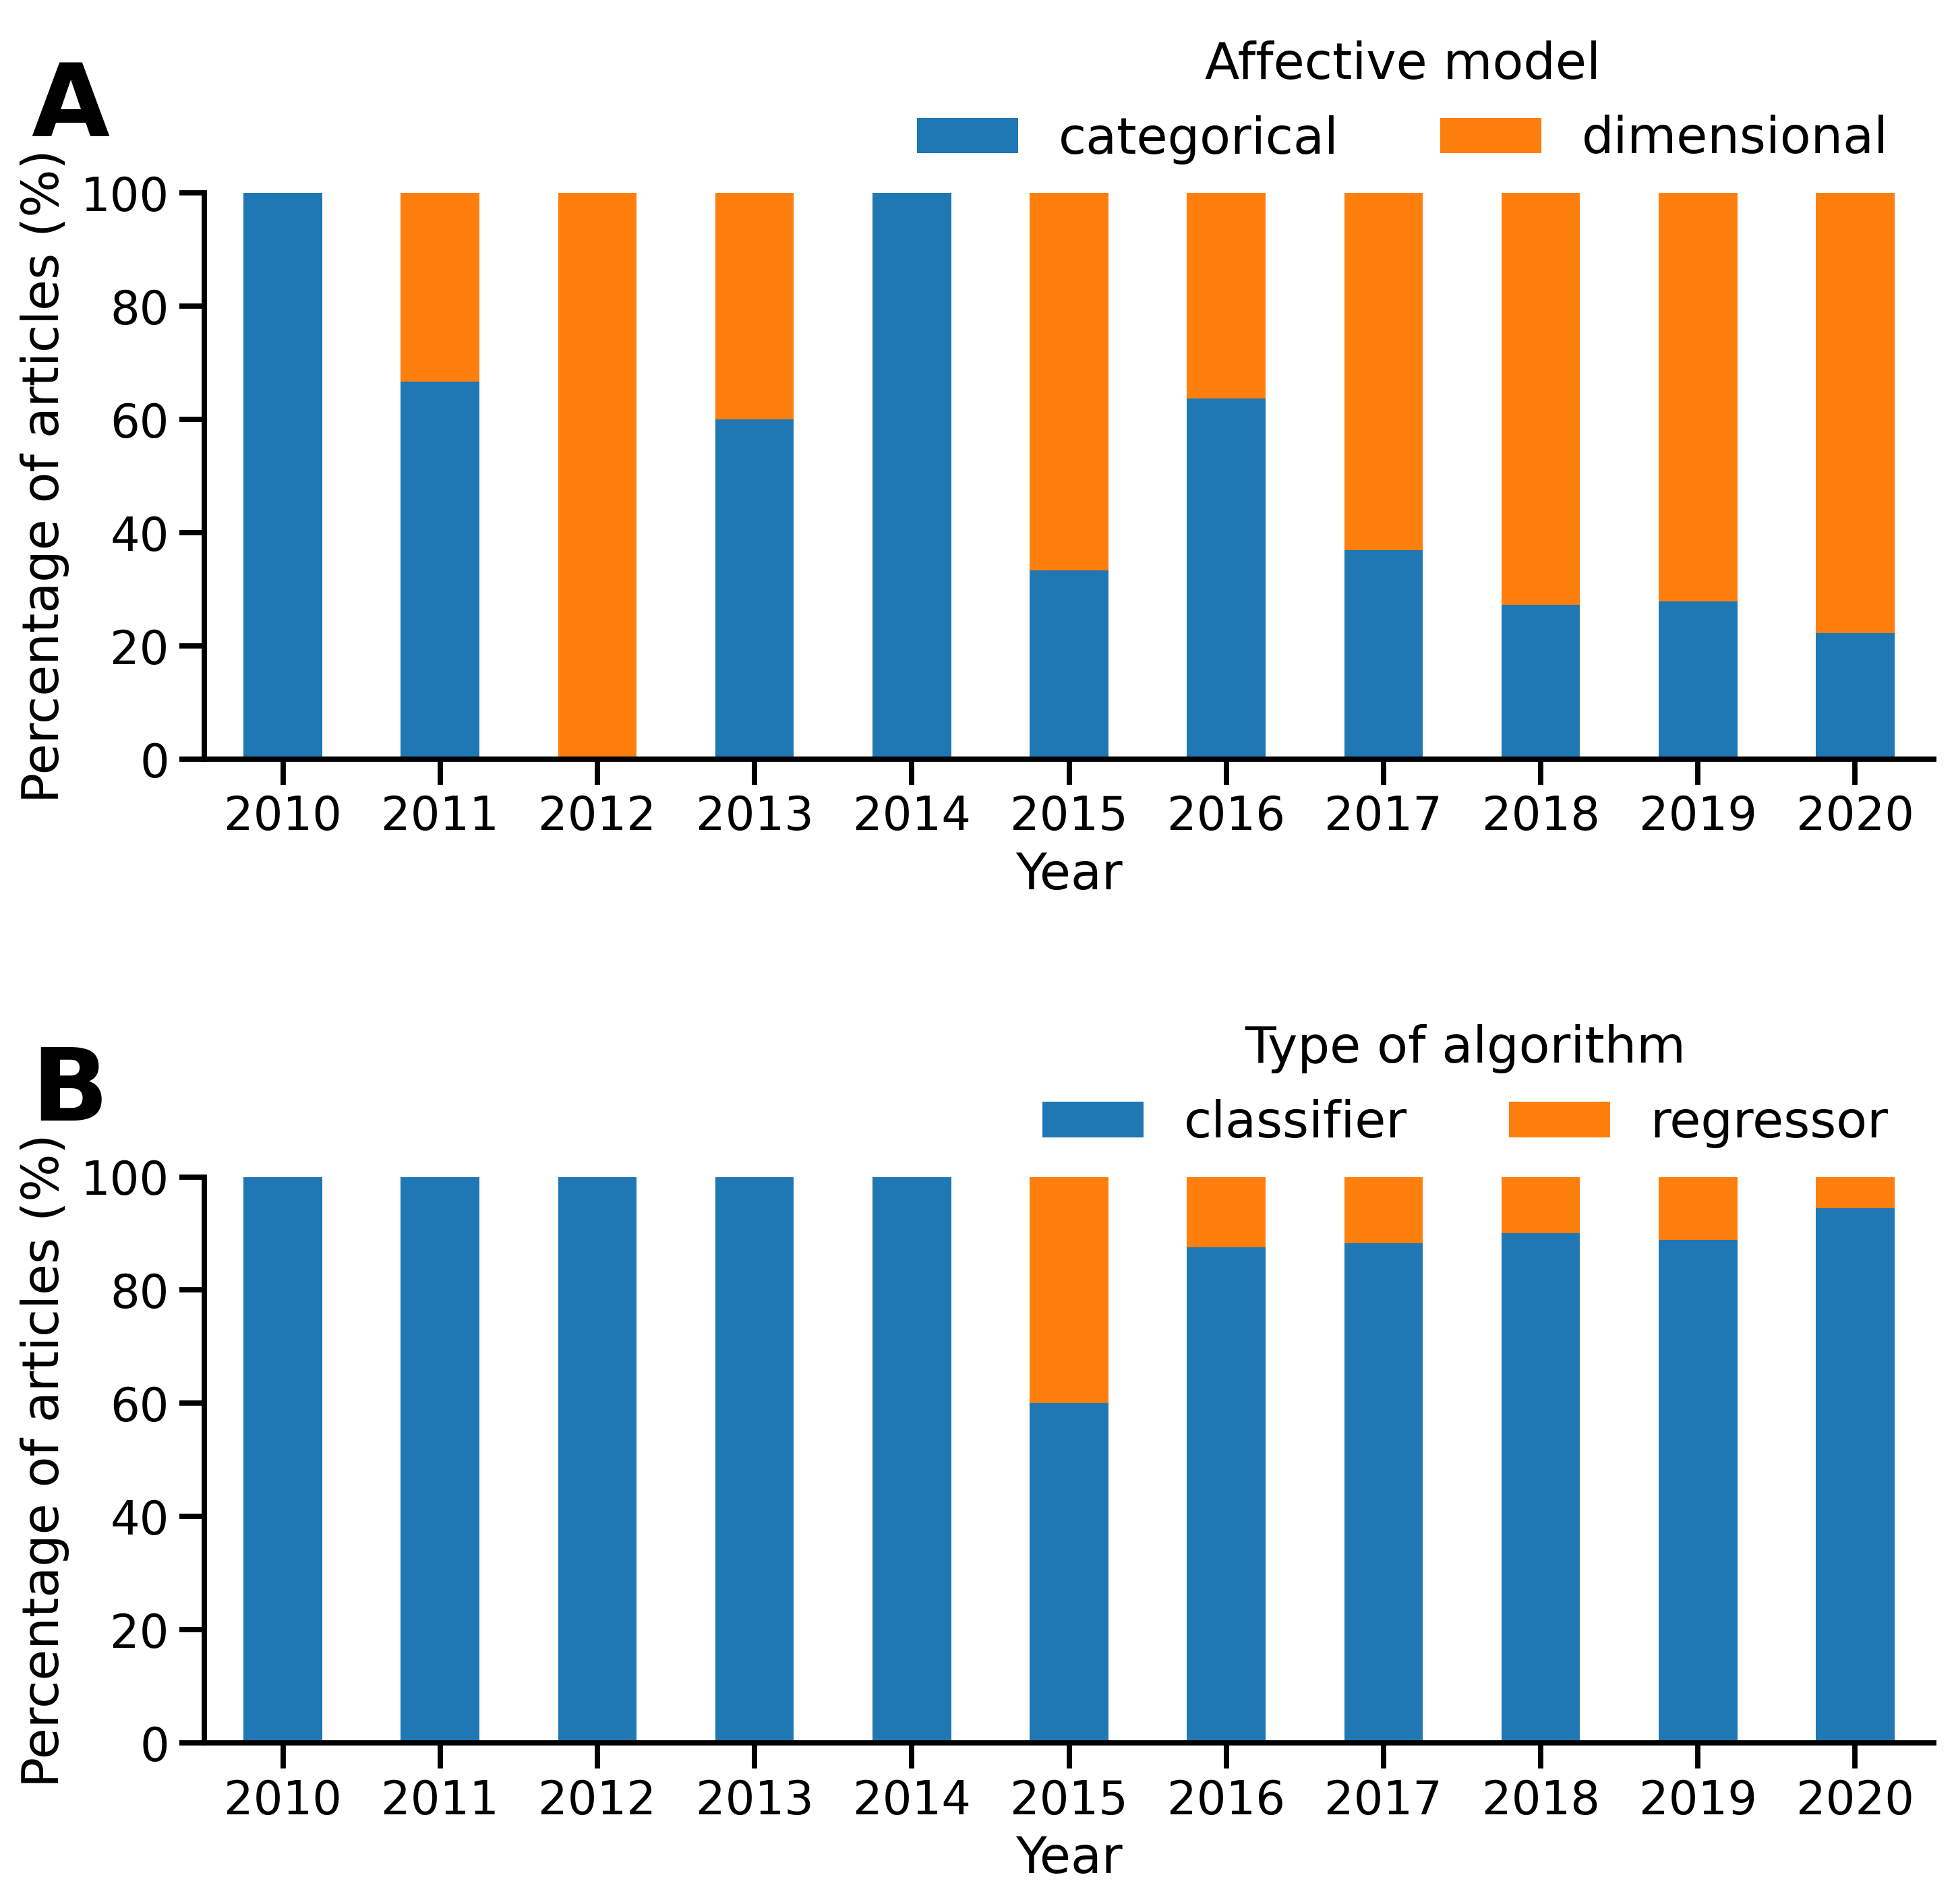

In [368]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


# Set the context for even bigger fonts
sns.set_context("talk")

# Create figure with custom GridSpec
fig = plt.figure(figsize=(10, 10), dpi=300)
gs = gridspec.GridSpec(2, 1)

# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
(models_crosstab * 100).plot(kind='bar',  # Multiply by 100 for percentages
                            stacked=True,
                            rot=0,
                            ax=ax1,
                            color=plt.cm.tab10(np.linspace(0, 1, len(models_crosstab))))
ax1.set_ylim([0, 100])  # Updated for percentages
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_yticklabels(ax1.get_yticklabels())
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of articles (%)")  # Updated label
ax1.legend(title='Affective model', loc='upper right',bbox_to_anchor=(1, 1.35),
          frameon=False, fancybox=True, ncol=2, fontsize=18)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
sns.despine(ax=ax1)

# SUBPLOT B
ax2 = plt.subplot(gs[1, 0])
(n_models_crosstab * 100).plot(kind='bar',  # Multiply by 100 for percentages
                              stacked=True,
                              rot=0,
                              ax=ax2,
                              color=plt.cm.tab10(np.linspace(0, 1, len(n_models_crosstab))))
ax2.set_ylim([0, 100])  # Updated for percentages
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax2.set_xlabel("Year")
ax2.set_ylabel("Percentage of articles (%)")  # Updated label
ax2.legend(title='Type of algorithm', loc='upper right',bbox_to_anchor=(1, 1.35),
          frameon=False, fancybox=True, ncol=2, fontsize=18)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
sns.despine(ax=ax2)


# Tight layout and show
plt.tight_layout()
plt.show()


#### Interpretation

In [ ]:
data_interpretation_model = pd.read_csv('.\data\cleaned\\Normalized Table - Statistical Learning model - Performances.csv')
data_interpretation_model= data_interpretation_model.fillna('-')
model_interpretion = data_interpretation_model[data_interpretation_model['model_interpretation'] !='-']
model_interpretation = model_interpretion.groupby(['paper_id', 'model_interpretation']).nth(0)

In [ ]:
model_interpretation.reset_index(inplace= True)
model_interpretation.drop_duplicates(subset = ['paper_id'],inplace=True)
model_interpretation

paper_id                               model_interpretation  model_id  \
0          5  By using the gradient fields (see Fig. 6(c,d))...        10   
1         12  Figure 6 shows similar EDA signal behaviour du...        47   
2         17  After preprocessing and windowing the signals,...        95   
3         19  The relationship between visual descriptors an...       129   
4         21  Physiological measures in the real world are m...       132   
5         29  Furthermore, it is worth noting that quality a...       167   
6         30  Poor classification accuracy may arise because...       175   
8         35  Compare to some references [1], [3], [4], the ...       195   
9         43   Electrodermal Activity. Interestingly, EDA se...       261   
10        57  Additionally, we showed that psychological tra...       296   
11        60  Additionally, analyzing the results of the sta...       310   
12        61  Another major finding is that EEG and GSR appe...       330   
13        64  Another\r\nreason for the better performance o...       344   
14        65  Particularly, although EDA is one of\r\nthe mo...       345   
15        75  Finally, significant correlates were found bet...       388   
16        77  This research analyzed the physiological compo...       420   
17        78  While our study shows that with TEM, the emoti...       422   
18        82  Physiological datasets with a large number of ...       439   
19        85  The proposed framework has enhanced the perfor...       455   
20        88   relevant information on the ANS activity can ...       464   
21        92  the initial analysis also shows some noticeabl...       477   
22        95  Second, our error analysis suggests that\nthe ...       489   
24        96  The best features that were repeated\r\nin the...       492   

                                         apa_citation  year affective_model  \
0   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016     dimensional   
1   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...  2018     categorical   
2   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...  2017     categorical   
3   Hernández-García, A., Fernández-Martínez, F., ...  2017     dimensional   
4   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...  2017     dimensional   
5   Gupta, R., Abadi, M. K., Cabré, J. A. C., Morr...  2016     dimensional   
6   Ooi, J. S. K., Ahmad, S. A., Chong, Y. Z., Ali...  2016     categorical   
8   Ferdinando, H., & Alasaarela, E. (2018). Emoti...  2018     dimensional   
9   Barral, O., Kosunen, I., & Jacucci, G. (2017)....  2017     categorical   
10  Henriques, R., Paiva, A., & Antunes, C. (2013)...  2013     categorical   
11  Al Machot, F., Elmachot, A., Ali, M., Al Macho...  2019     dimensional   
12  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...  2019     dimensional   
13  Dar, M. N., Akram, M. U., Khawaja, S. G., & Pu...  2020     dimensional   
14  Greco, A., Marzi, C., Lanata, A., Scilingo, E....  2019     dimensional   
15  Song, T., Zheng, W., Lu, C., Zong, Y., Zhang, ...  2019     categorical   
16  Pinto, G., Carvalho, J. M., Barros, F., Soares...  2020     categorical   
17  Raheel, A., Majid, M., Alnowami, M., & Anwar, ...  2020     categorical   
18  Santamaria-Granados, L., Munoz-Organero, M., R...  2019     dimensional   
19  Xie, J., Xu, X., & Shu, L. (2018, May). WT fea...  2018     categorical   
20  Ghiasi, S., Greco, A., Barbieri, R., Scilingo,...  2020     dimensional   
21  Rahman, J. S., Hossain, M. Z., & Gedeon, T. (2...  2019     categorical   
22  Yang, H. C., & Lee, C. C. (2019, September). A...  2020     dimensional   
24  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020     dimensional   

   is_classifier class_model_output_number  \
0              -                         -   
1              x                         2   
2              x                         2   
3              -                         -   
4              x            

In [ ]:
print(f' En {len(model_interpretation)} papers se realizan interpretaciones emocionales de los modelos')

 En 23 papers se realizan interpretaciones emocionales de los modelos


In [ ]:
# lista papers id
model_interpretation_list = model_interpretation["paper_id"].to_list()
model_interpretation_list = [int(a) for a in model_interpretation_list]
model_interpretation_list

[5,
 12,
 17,
 19,
 21,
 29,
 30,
 35,
 43,
 57,
 60,
 61,
 64,
 65,
 75,
 77,
 78,
 82,
 85,
 88,
 92,
 95,
 96]

In [ ]:
df_metadata_filtered = df_metadata[df_metadata['paper_id'].isin(model_interpretation_list)]
df_metadata_filtered.drop_duplicates("paper_id", inplace= True)
df_metadata_filtered[["paper_id", "apa_citation", "year", "source_title"]]

C:\Users\someo\AppData\Local\Temp\ipykernel_112240\3128163824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata_filtered.drop_duplicates("paper_id", inplace= True)


paper_id                                       apa_citation  year  \
9           5  Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016   
46         12  Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...  2018   
94         17  Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...  2017   
128        19  Hernández-García, A., Fernández-Martínez, F., ...  2017   
131        21  Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...  2017   
166        29  Gupta, R., Abadi, M. K., Cabré, J. A. C., Morr...  2016   
172        30  Ooi, J. S. K., Ahmad, S. A., Chong, Y. Z., Ali...  2016   
194        35  Ferdinando, H., & Alasaarela, E. (2018). Emoti...  2018   
260        43  Barral, O., Kosunen, I., & Jacucci, G. (2017)....  2017   
293        57  Henriques, R., Paiva, A., & Antunes, C. (2013)...  2013   
308        60  Al Machot, F., Elmachot, A., Ali, M., Al Macho...  2019   
328        61  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...  2019   
342        64  Dar, M. N., Akram, M. U., Khawaja, S. G., & Pu...  2020   
343        65  Greco, A., Marzi, C., Lanata, A., Scilingo, E....  2019   
383        75  Song, T., Zheng, W., Lu, C., Zong, Y., Zhang, ...  2019   
418        77  Pinto, G., Carvalho, J. M., Barros, F., Soares...  2020   
420        78  Raheel, A., Majid, M., Alnowami, M., & Anwar, ...  2020   
437        82  Santamaria-Granados, L., Munoz-Organero, M., R...  2019   
453        85  Xie, J., Xu, X., & Shu, L. (2018, May). WT fea...  2018   
462        88  Ghiasi, S., Greco, A., Barbieri, R., Scilingo,...  2020   
475        92  Rahman, J. S., Hossain, M. Z., & Gedeon, T. (2...  2019   
480        95  Yang, H. C., & Lee, C. C. (2019, September). A...  2020   
490        96  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020   

                                          source_title  
9                                   Scientific Reports  
46   International Journal of Medical Engineering a...  
94                  Signal, Image and Video Processing  
128  Proceedings - 2017 IEEE/WIC/ACM International ...  
131  2017 IEEE International Conference on Pervasiv...  
166  ICMR 2016 - Proceedings of the 2016 ACM Intern...  
172  IECBES 2016 - IEEE-EMBS Conference on Biomedic...  
194  Journal of Telecommunication, Electronic and C...  
260     ACM Transactions on Computer-Human Interaction  
293  Humaine Association Conference on Affective Co...  
308                                            Sensors  
328                                            Sensors  
342                                            Sensors  
343  Annual International Conference of the IEEE En...  
383                                        IEEE Access  
418                                            Sensors  
420                                            Sensors  
437                                        IEEE Access  
453  Asian Conf. Affective Comput. Intell. Interact...  
462                                 Scientific Reports  
475  Australian Conference on Human-Computer-Intera...  
480  International Conference on Affective Computin...  
490  Bulletin of the Polish Academy of Sciences: Te...

In [ ]:
list_journal_int = df_metadata_filtered["source_title"].unique()
list_journal_int = list_journal_int.tolist()
list_journal_int

['Scientific Reports',
 'International Journal of Medical Engineering and Informatics',
 'Signal, Image and Video Processing',
 'Proceedings - 2017 IEEE/WIC/ACM International Conference on Web Intelligence, WI 2017',
 '2017 IEEE International Conference on Pervasive Computing and Communications Workshops, PerCom Workshops 2017',
 'ICMR 2016 - Proceedings of the 2016 ACM International Conference on Multimedia Retrieval',
 'IECBES 2016 - IEEE-EMBS Conference on Biomedical Engineering and Sciences',
 'Journal of Telecommunication, Electronic and Computer Engineering',
 'ACM Transactions on Computer-Human Interaction',
 'Humaine Association Conference on Affective Computing and Intelligent Interaction',
 'Sensors',
 'Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. Annual International Conference',
 'IEEE Access',
 'Asian Conf. Affective Comput. Intell. Interaction, ACII Asia',
 'Australian Conference

C:\Users\someo\AppData\Local\Temp\ipykernel_112240\1692122345.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


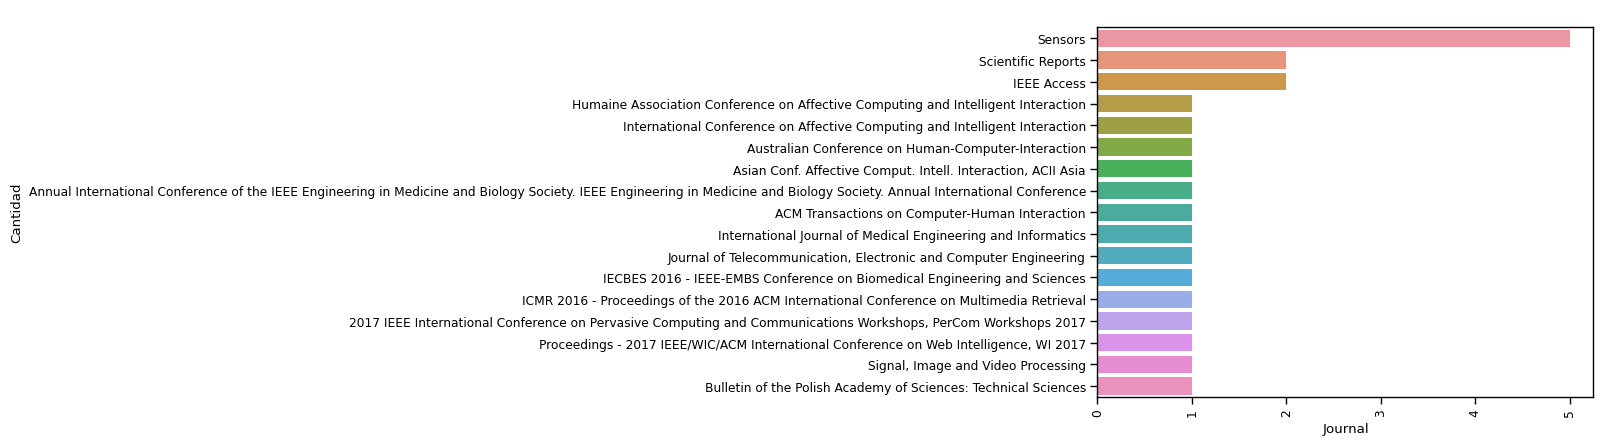

In [ ]:
titulos = [' ', 'Journal', 'Cantidad']

var_x = "source_title"
df = df_metadata_filtered

g = sns.countplot(y=var_x, data=df, order = getattr(df, var_x).value_counts().index)
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()